In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns
import impyute as impy

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [32]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [33]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [34]:
cleaned_dataset = pd.read_csv('cleaned_dataset.csv')

In [35]:
# drop cloumn Unnamed: 0

# Fixing date column datatype
cleaned_dataset['date'] = pd.to_datetime(cleaned_dataset['date']);
# all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');
# all_countries_dataset['continent'] = all_countries_dataset['continent'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)

In [36]:
# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index',
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

varmax_dataset = cleaned_dataset.copy()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

obj_dataset = varmax_dataset[non_numerical_variables].copy()
num_dataset = varmax_dataset[numerical_variables].copy()
# num_dataset = sc.fit_transform(num_dataset)

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)


num_dataset = np.log(num_dataset)

# Take First Difference to Remove Trend
num_dataset = num_dataset.diff()

num_dataset = num_dataset.diff()

# Remove Increasing Volatility
# num_dataset = num_dataset.groupby(num_dataset.index.year).std()

svr_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

svr_dataset.dtypes

continent                          object
location                           object
date                       datetime64[ns]
new_cases                         float64
new_deaths                        float64
icu_patients                      float64
new_tests                         float64
positive_rate                     float64
people_vaccinated                 float64
new_vaccinations                  float64
total_boosters                    float64
stringency_index                  float64
population                        float64
population_density                float64
cardiovasc_death_rate             float64
diabetes_prevalence               float64
human_development_index           float64
dtype: object

In [37]:
svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

In [38]:
def replace_nans(dataset):
    # for each country
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        for variable in numerical_variables:
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]) or row[variable] == float('inf') or row[variable] == float('-inf'):
                    previous_timestamp = index - pd.Timedelta(days=1)
                    if previous_timestamp in country_dataset.index and pd.isna(country_dataset.loc[previous_timestamp, variable]) == False:
                        country_dataset.at[index, variable] = country_dataset.at[previous_timestamp, variable]
                    else:
                        country_dataset.at[index, variable] = 0
                        
        new_dataset = pd.concat([new_dataset, country_dataset], axis=0)

    return new_dataset

In [39]:
svr_dataset = replace_nans(svr_dataset)

In [43]:
# split into train and test
training_date_limit = date(2021, 9, 1)

svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

svr_train_dataset = svr_dataset[svr_dataset['date'].dt.date < training_date_limit]
svr_test_dataset = svr_dataset[svr_dataset['date'].dt.date >= training_date_limit]

In [44]:
# import SVR
from sklearn.svm import SVR


def svr(country):
    best_score = -np.Infinity
    best_C = 1
    best_svr_model = None

    X = svr_train_dataset[numerical_variables].loc[svr_train_dataset['location'] == country]
    X = X.drop(columns=['new_deaths'])
    y = svr_train_dataset['new_deaths'].loc[svr_train_dataset['location'] == country]

    # show score
    X_test = svr_test_dataset[numerical_variables].loc[svr_test_dataset['location'] == country]
    # remove new_deaths from X_test
    X_test = X_test.drop(columns=['new_deaths'])
    y_test = svr_test_dataset['new_deaths'].loc[svr_test_dataset['location'] == country]

    C = 1
    while C < 10:
        svr_model = SVR(kernel='rbf', C=C)
        svr_model.fit(X, y)

        svr_predictions = svr_model.predict(X_test)

        score = svr_model.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_C = C
            best_svr_model = svr_model
        C = C + 0.1

    print("Country: {} - C: {} - SVR Score: {}".format(country, best_C, best_score))

    predictions = best_svr_model.predict(X_test)

    # plot predictions vs actual
    plt.figure(figsize=(50, 25))
    plt.plot(svr_test_dataset['date'].loc[svr_test_dataset['location'] == country], predictions, label='Predictions')
    plt.plot(svr_test_dataset['date'].loc[svr_test_dataset['location'] == country], y_test, label='Actual')
    plt.title("Country: {} - SVR Predictions vs Actual".format(country))
    plt.xlabel("Date")
    plt.ylabel("New Deaths")
    plt.legend()
    plt.show()

    return predictions

Country: Austria - C: 1 - SVR Score: -0.21914387983715633


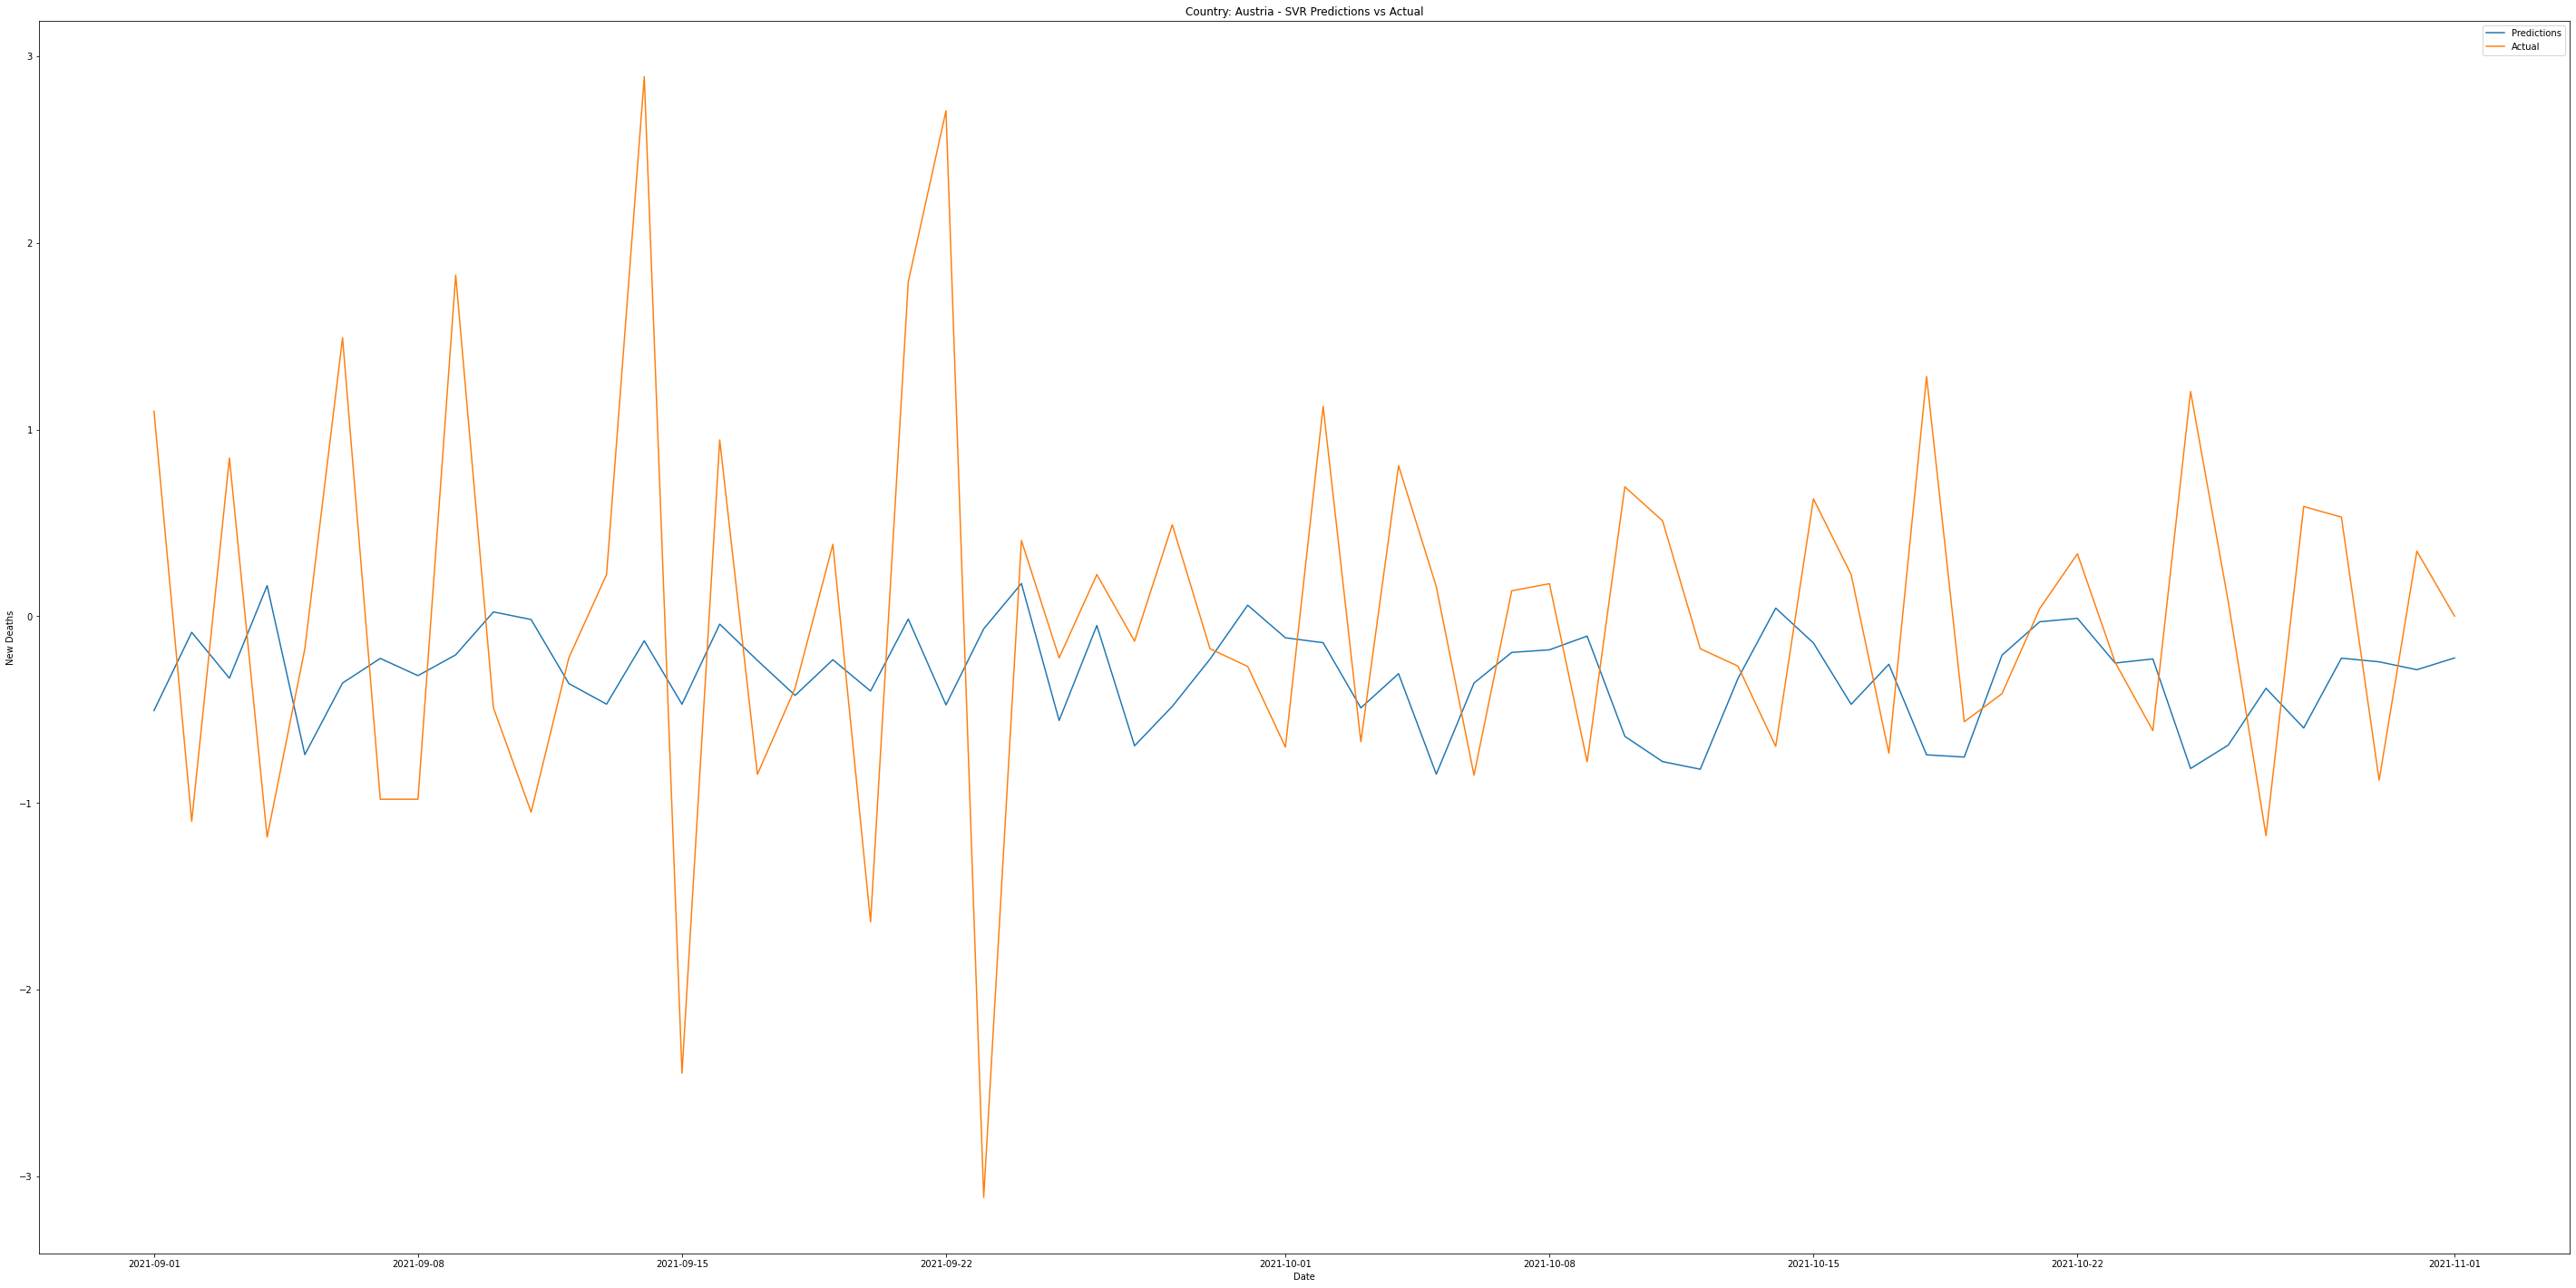

Country: Belgium - C: 1 - SVR Score: -0.011919118904532011


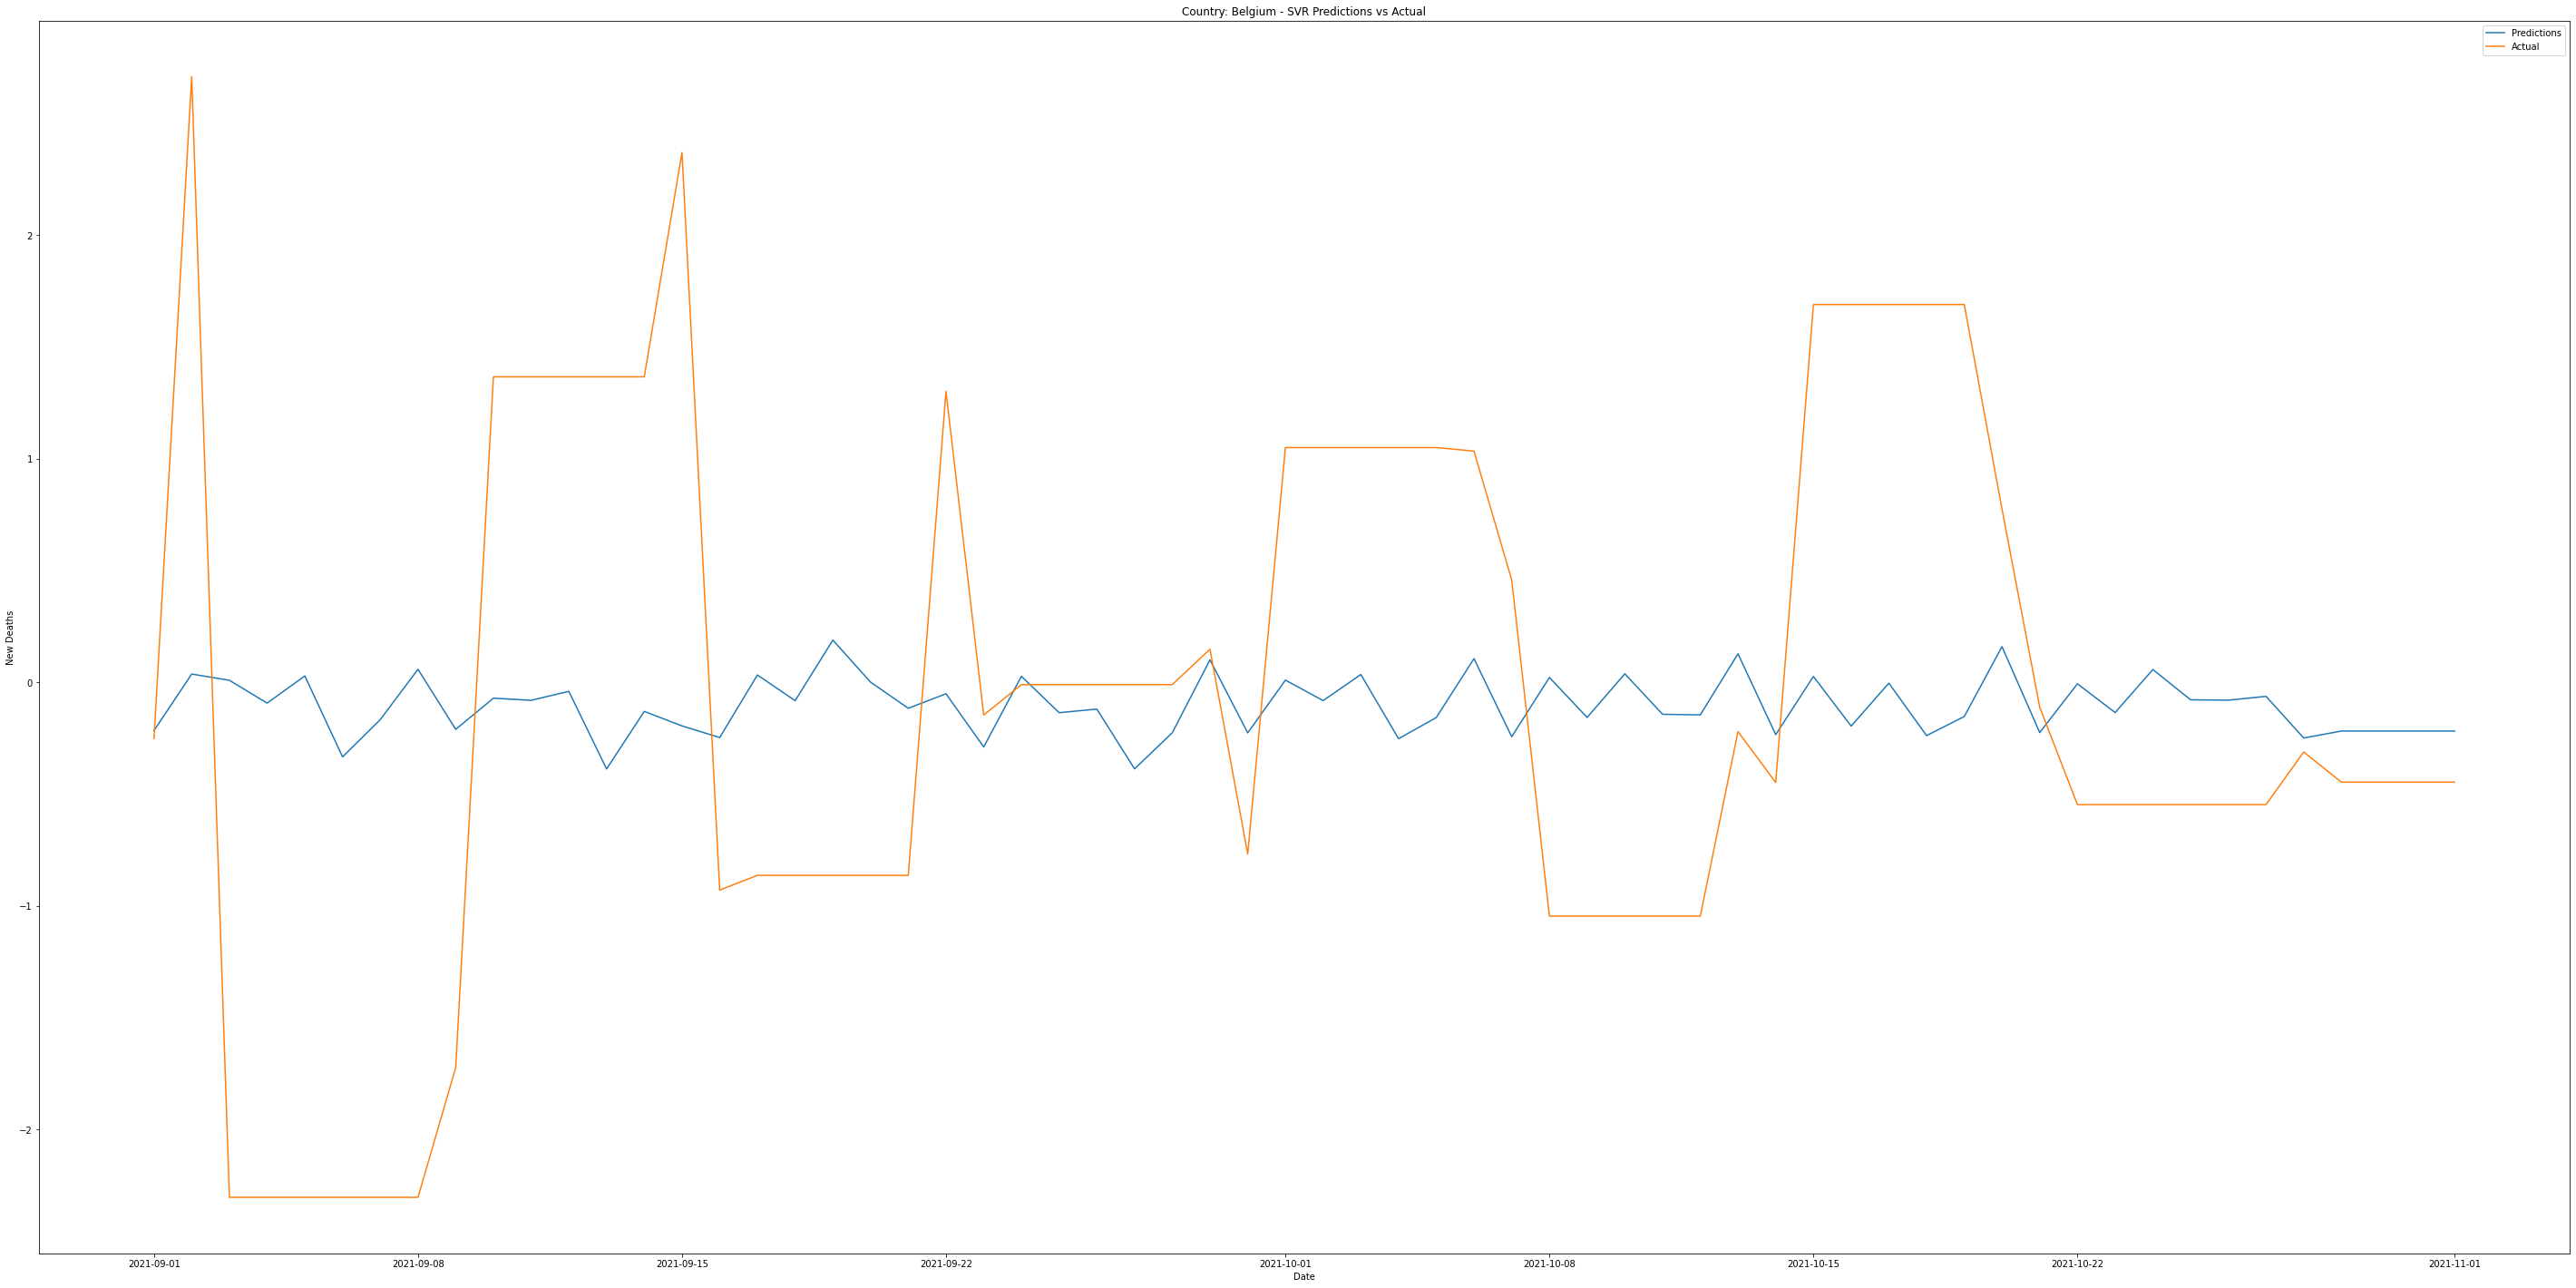

Country: Bulgaria - C: 1 - SVR Score: 0.26095914740890624


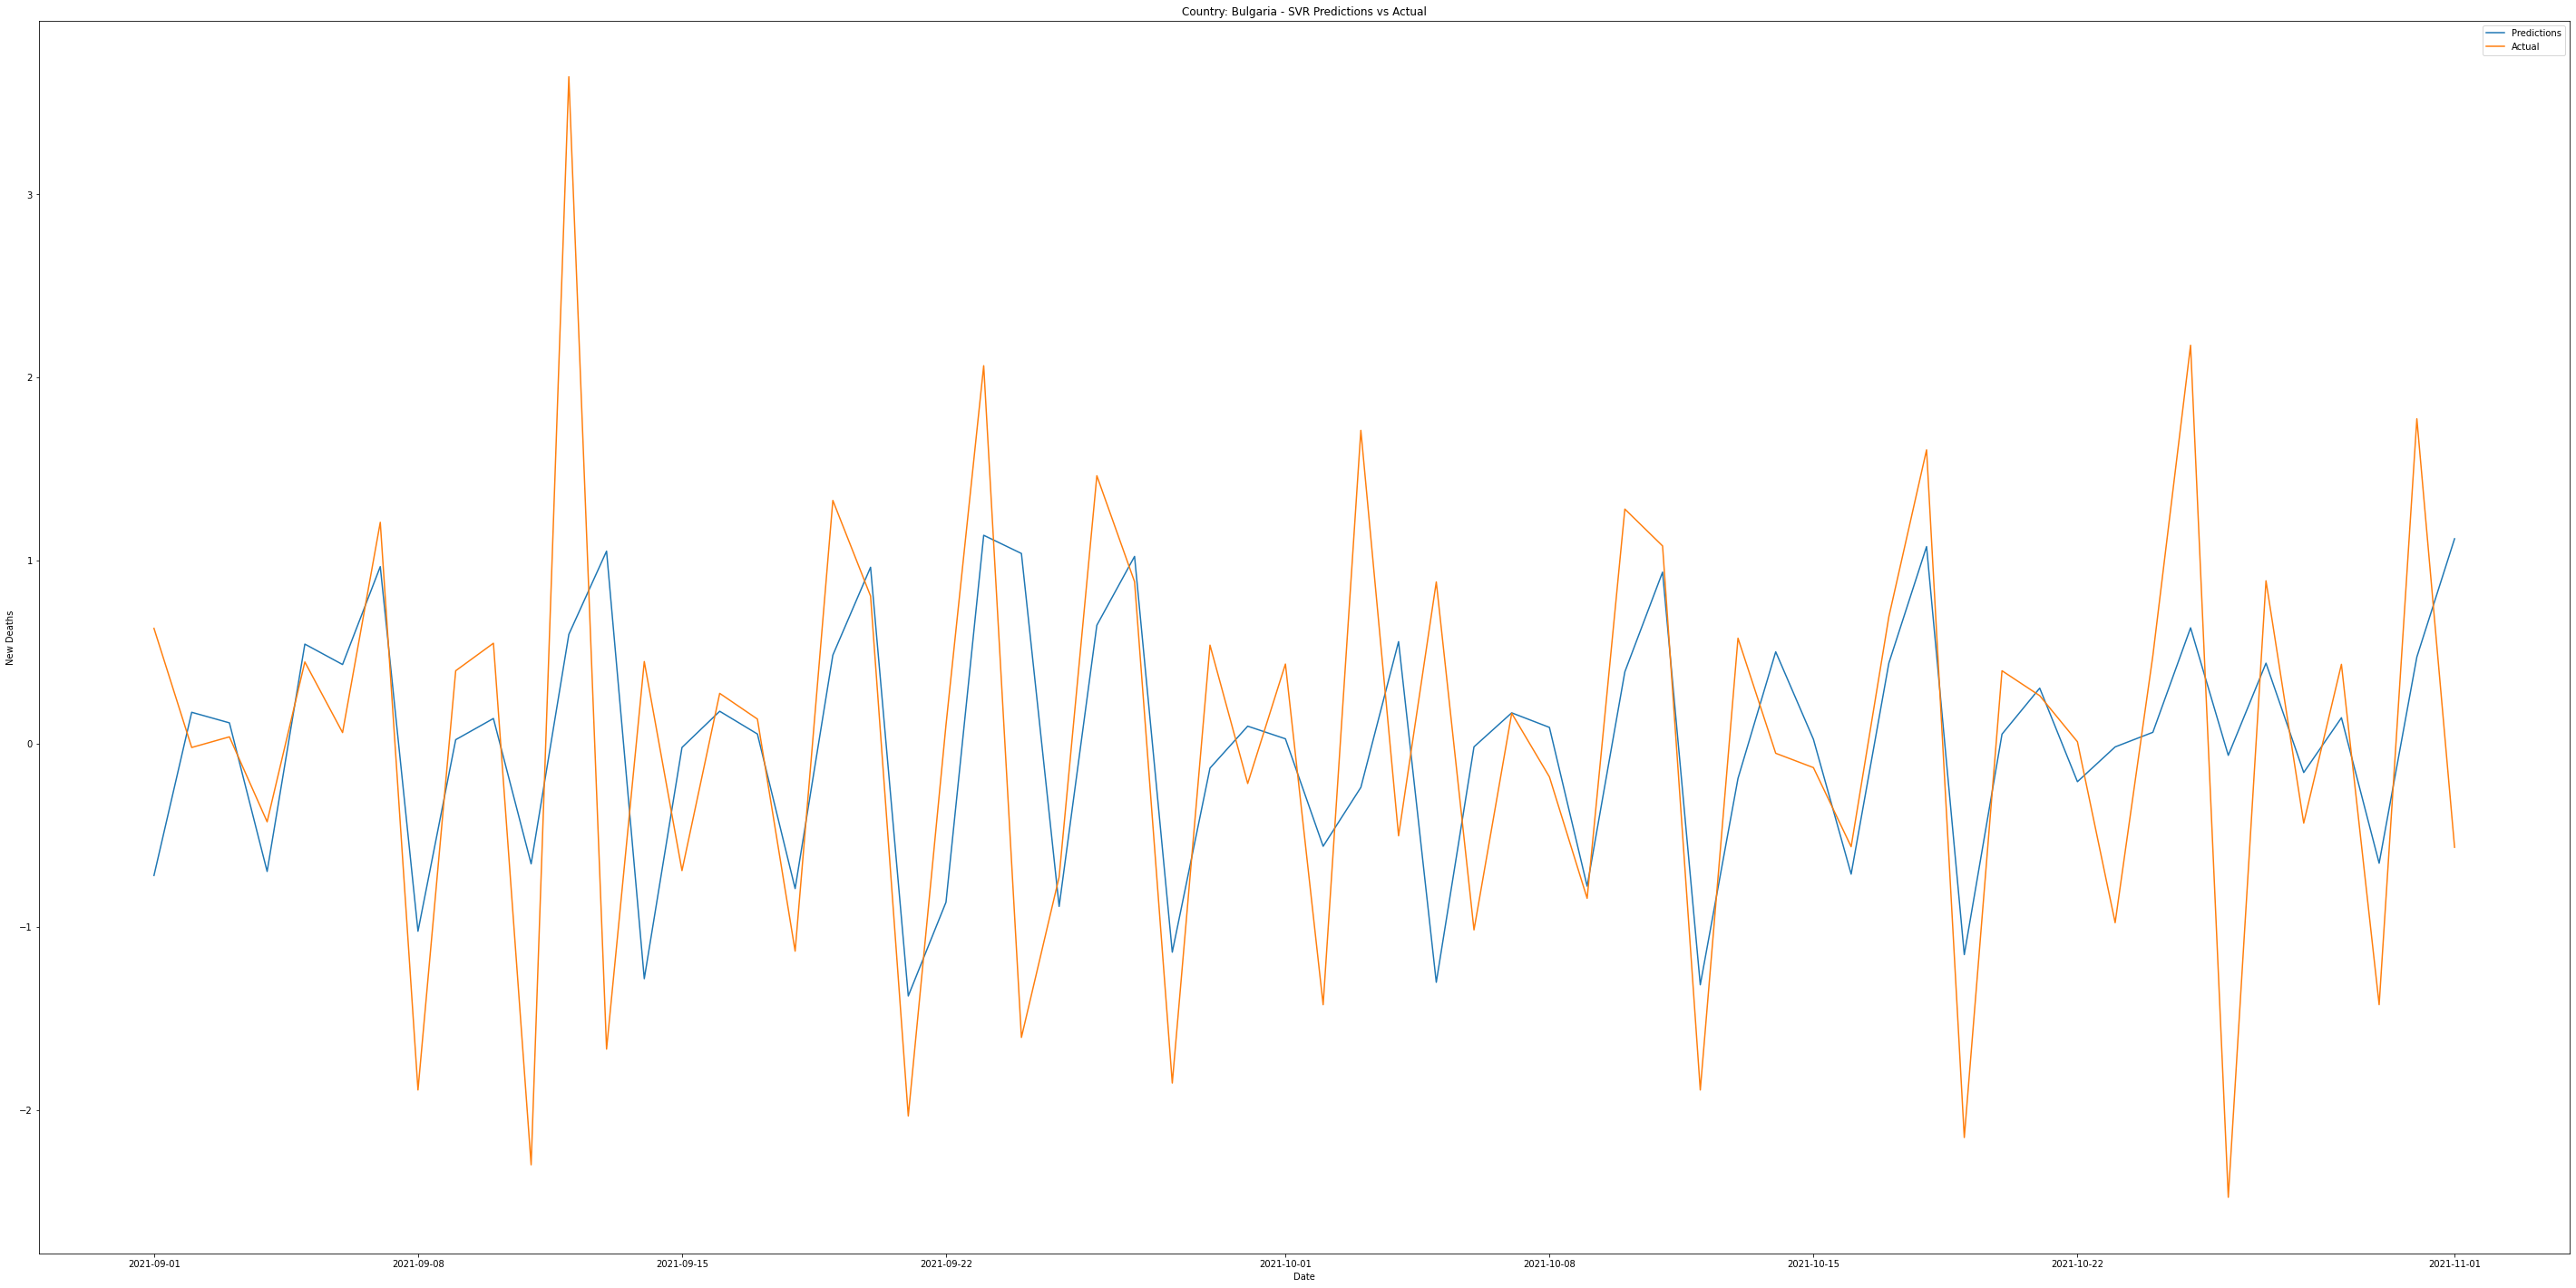

Country: Cyprus - C: 5.699999999999997 - SVR Score: -0.0542782703520448


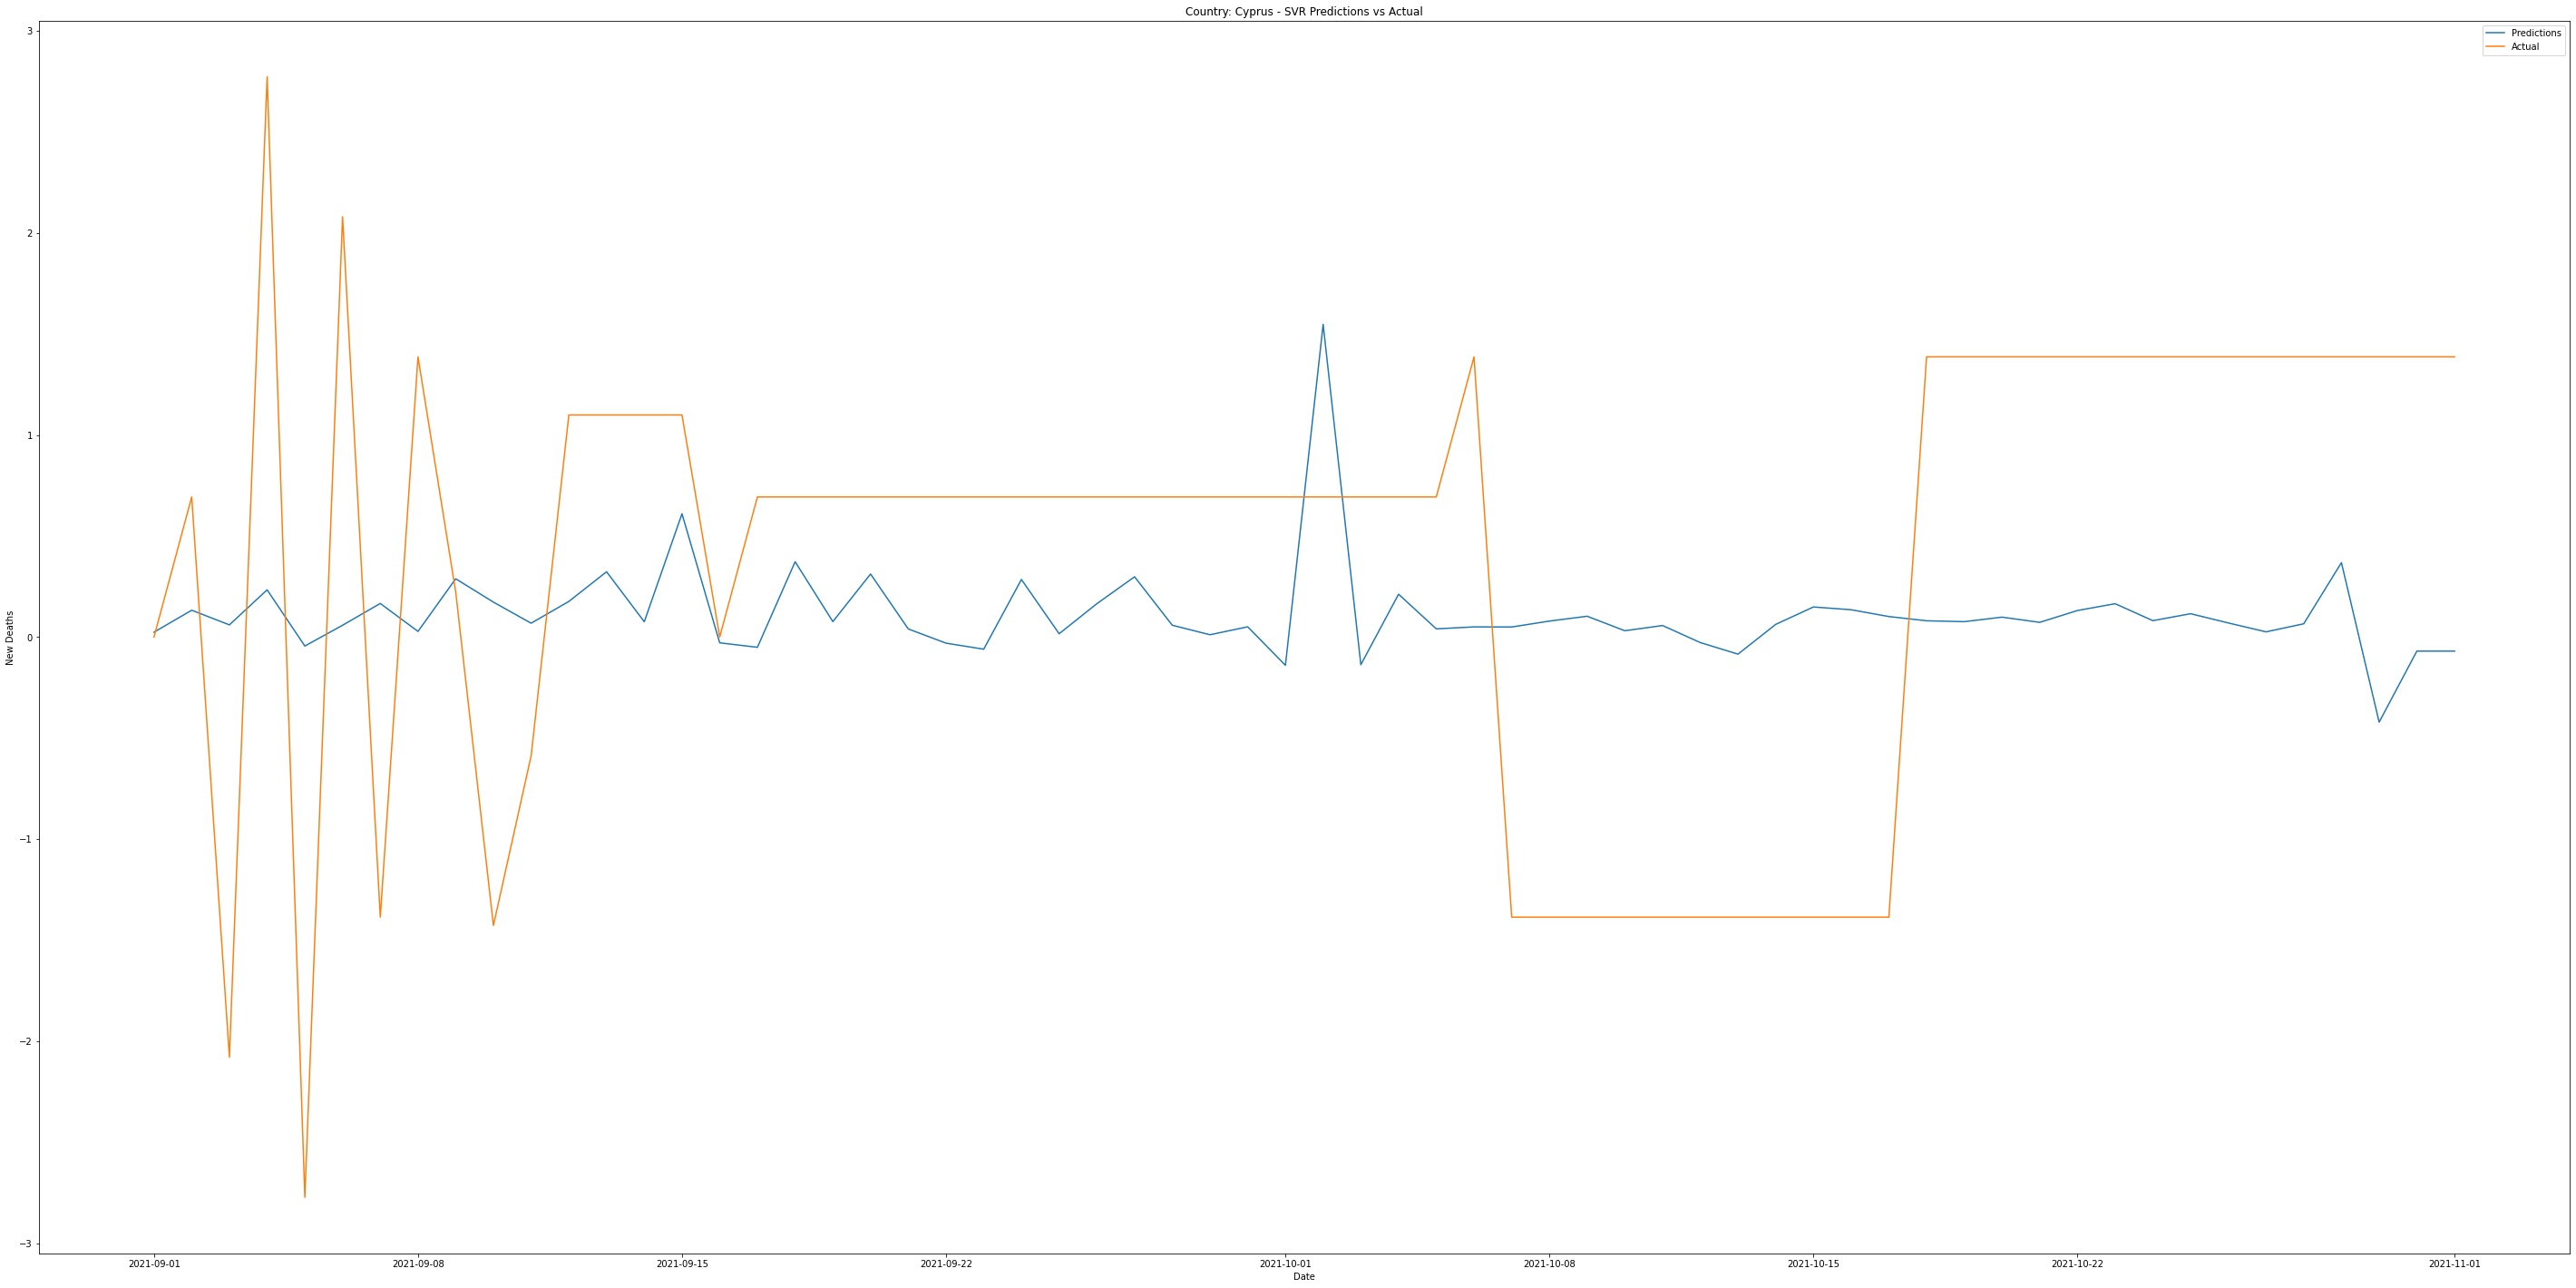

Country: Czechia - C: 3.7000000000000024 - SVR Score: 0.08896135879078404


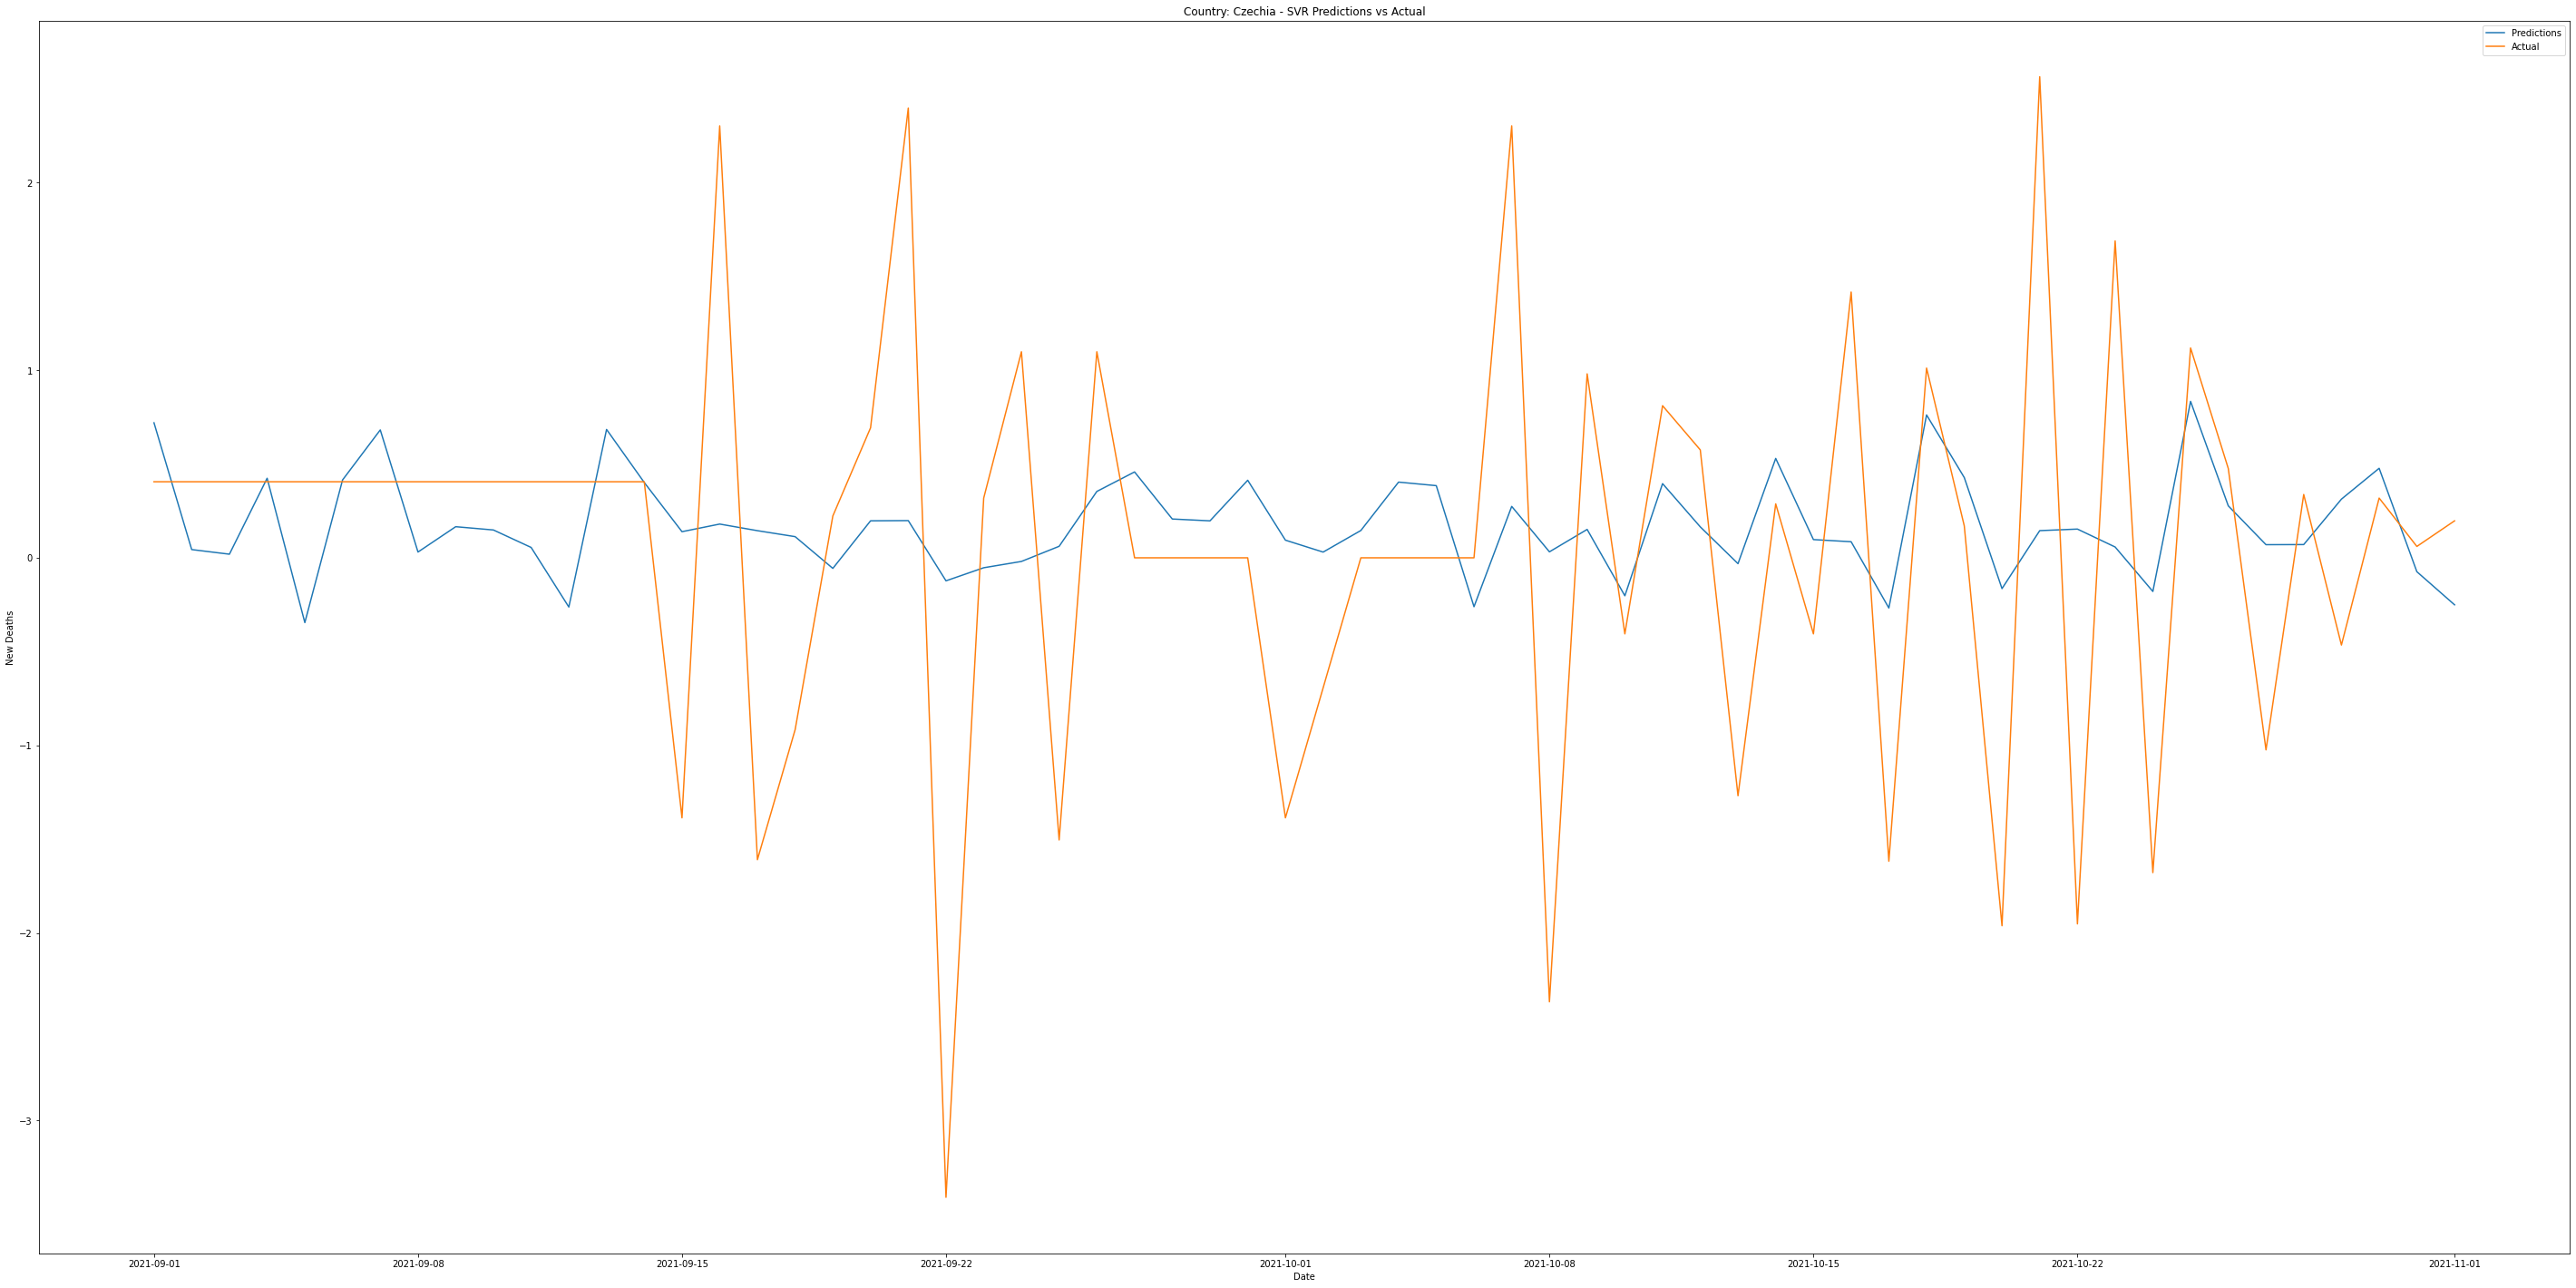

Country: Denmark - C: 1 - SVR Score: -0.09882913519843317


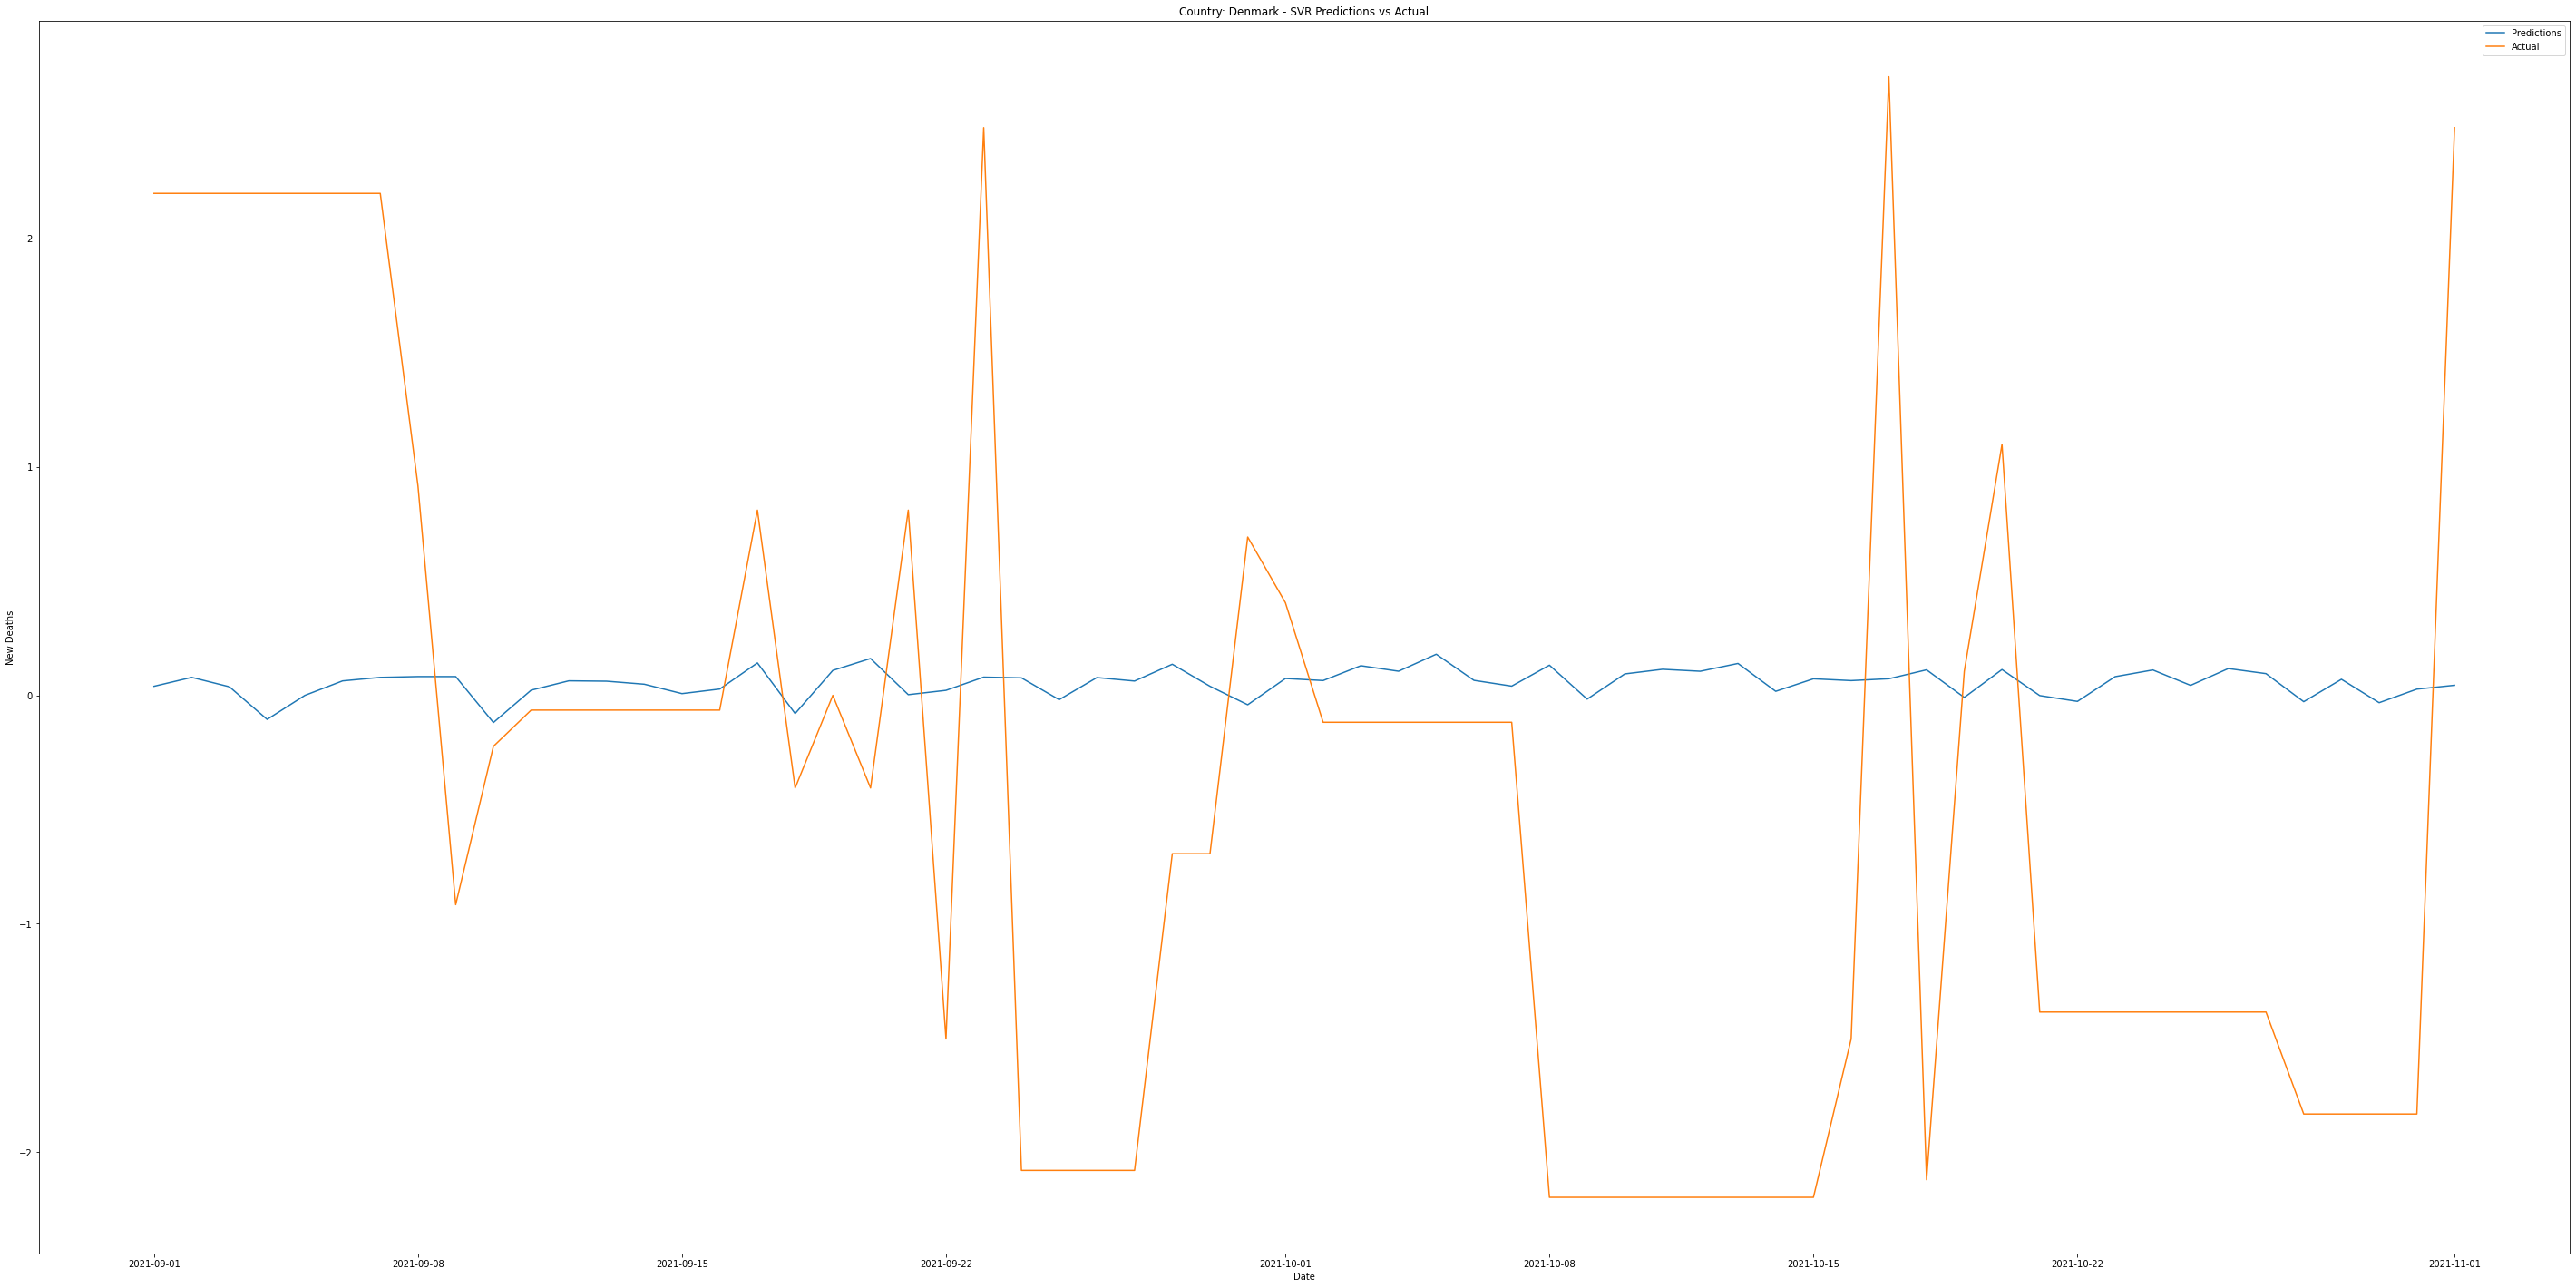

Country: Estonia - C: 1 - SVR Score: -0.035471325599844006


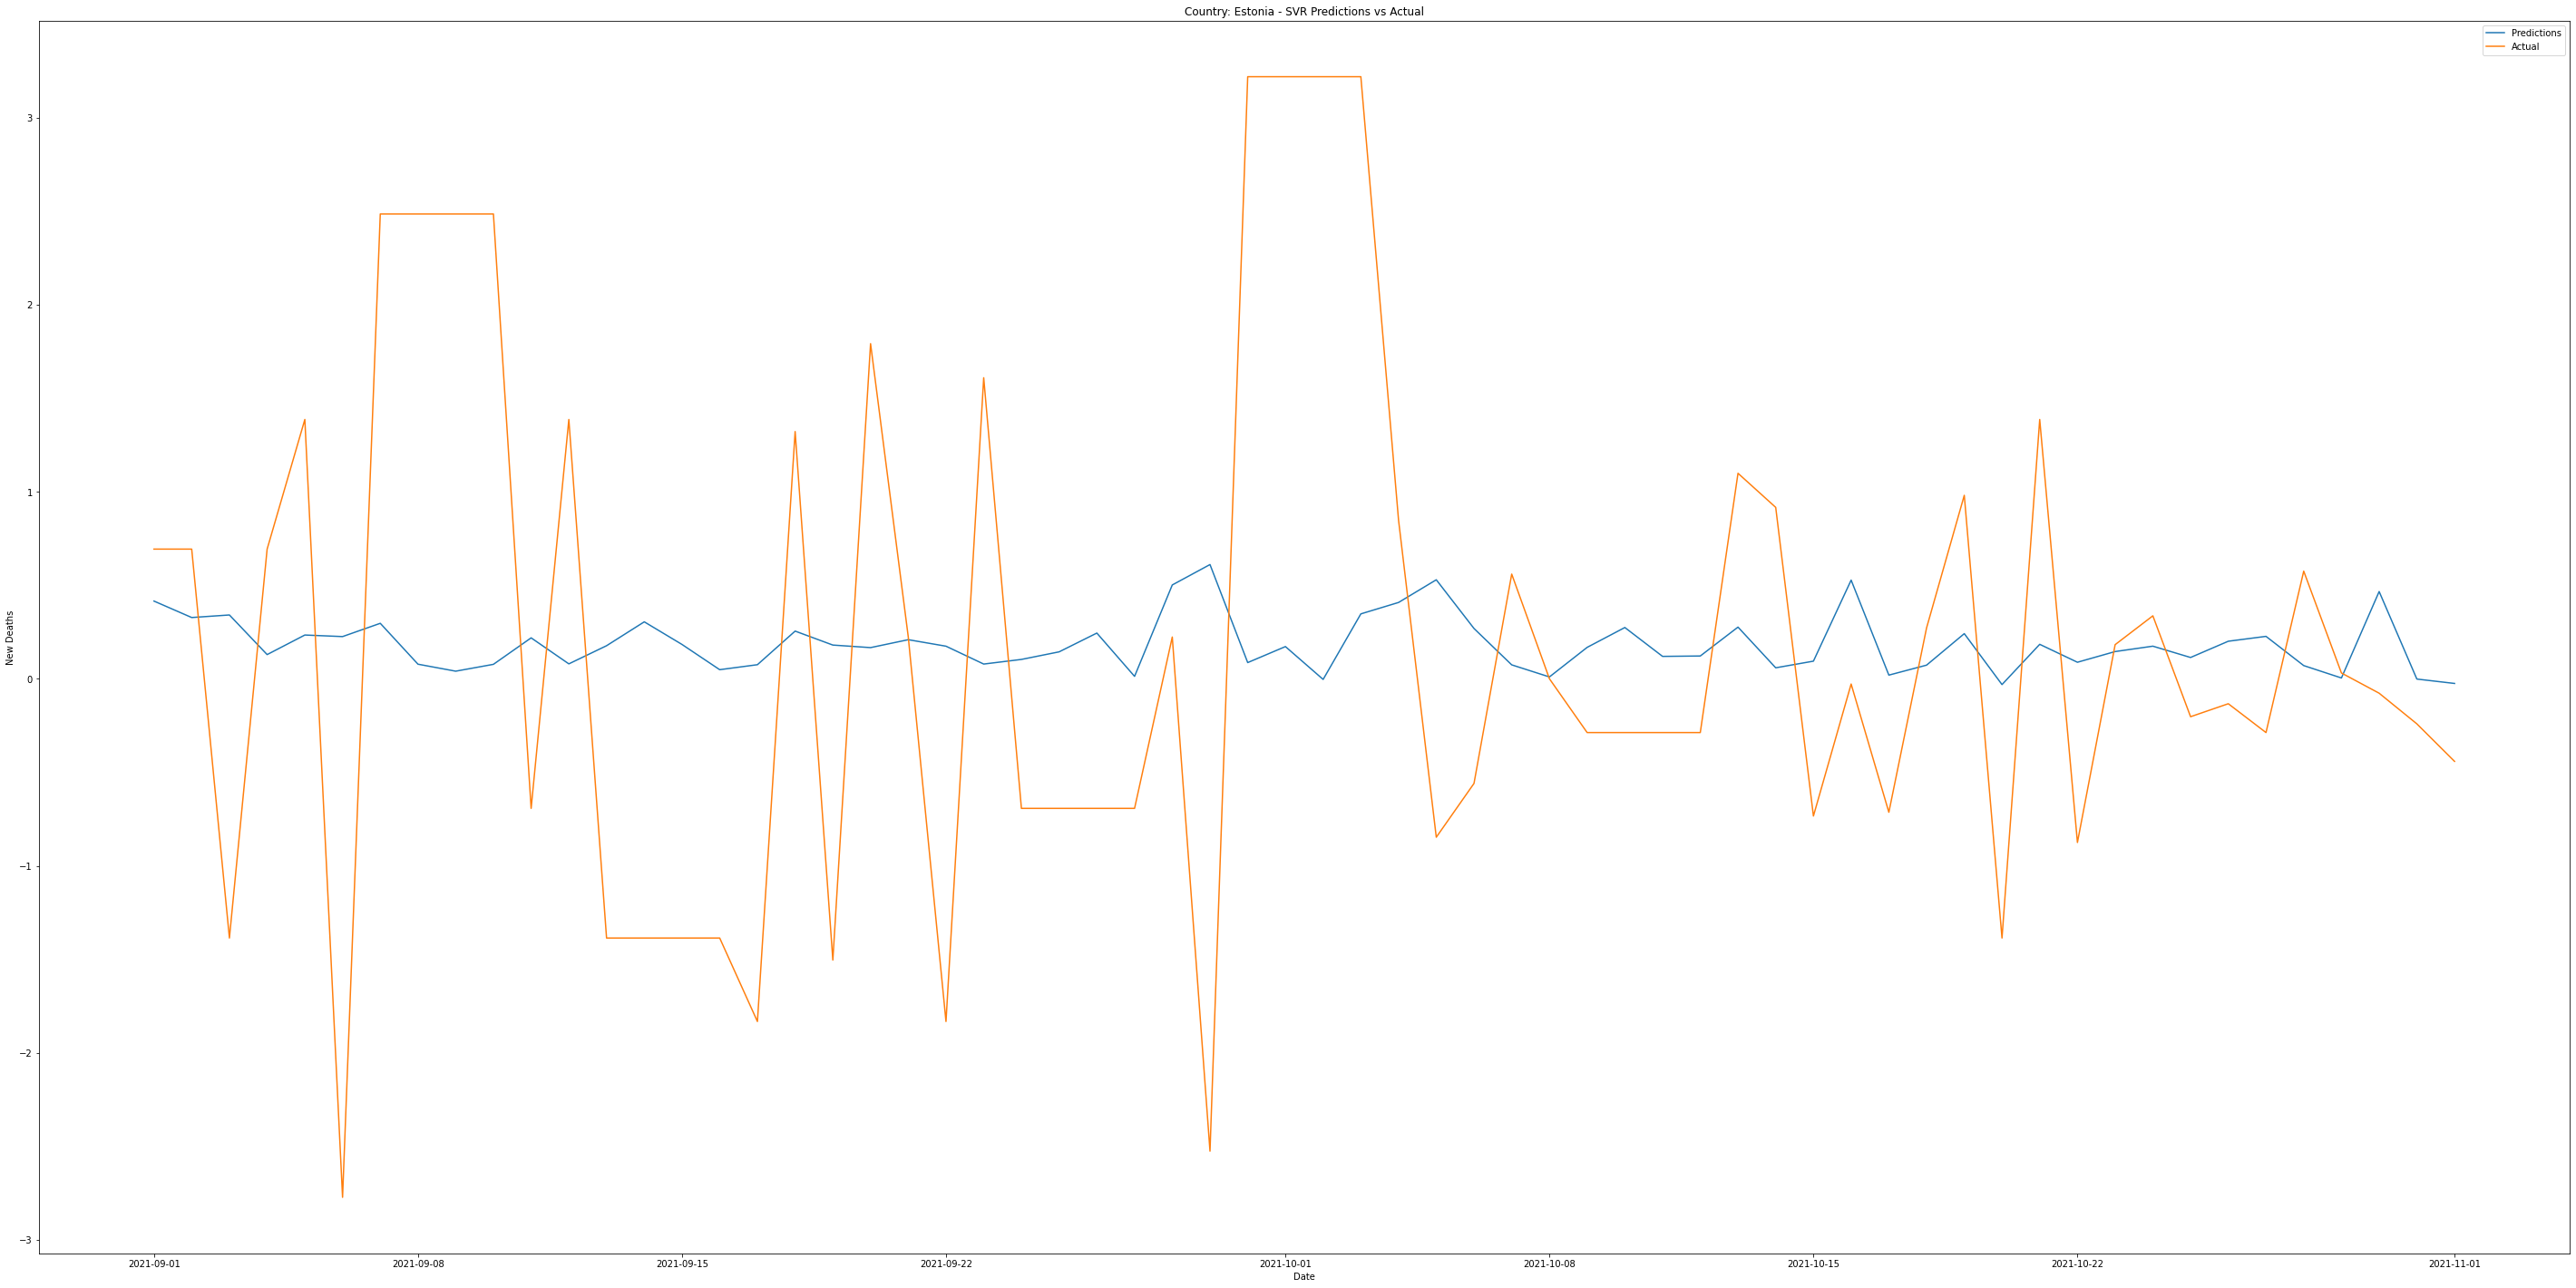

Country: Finland - C: 1.2000000000000002 - SVR Score: 0.0021734037562090025


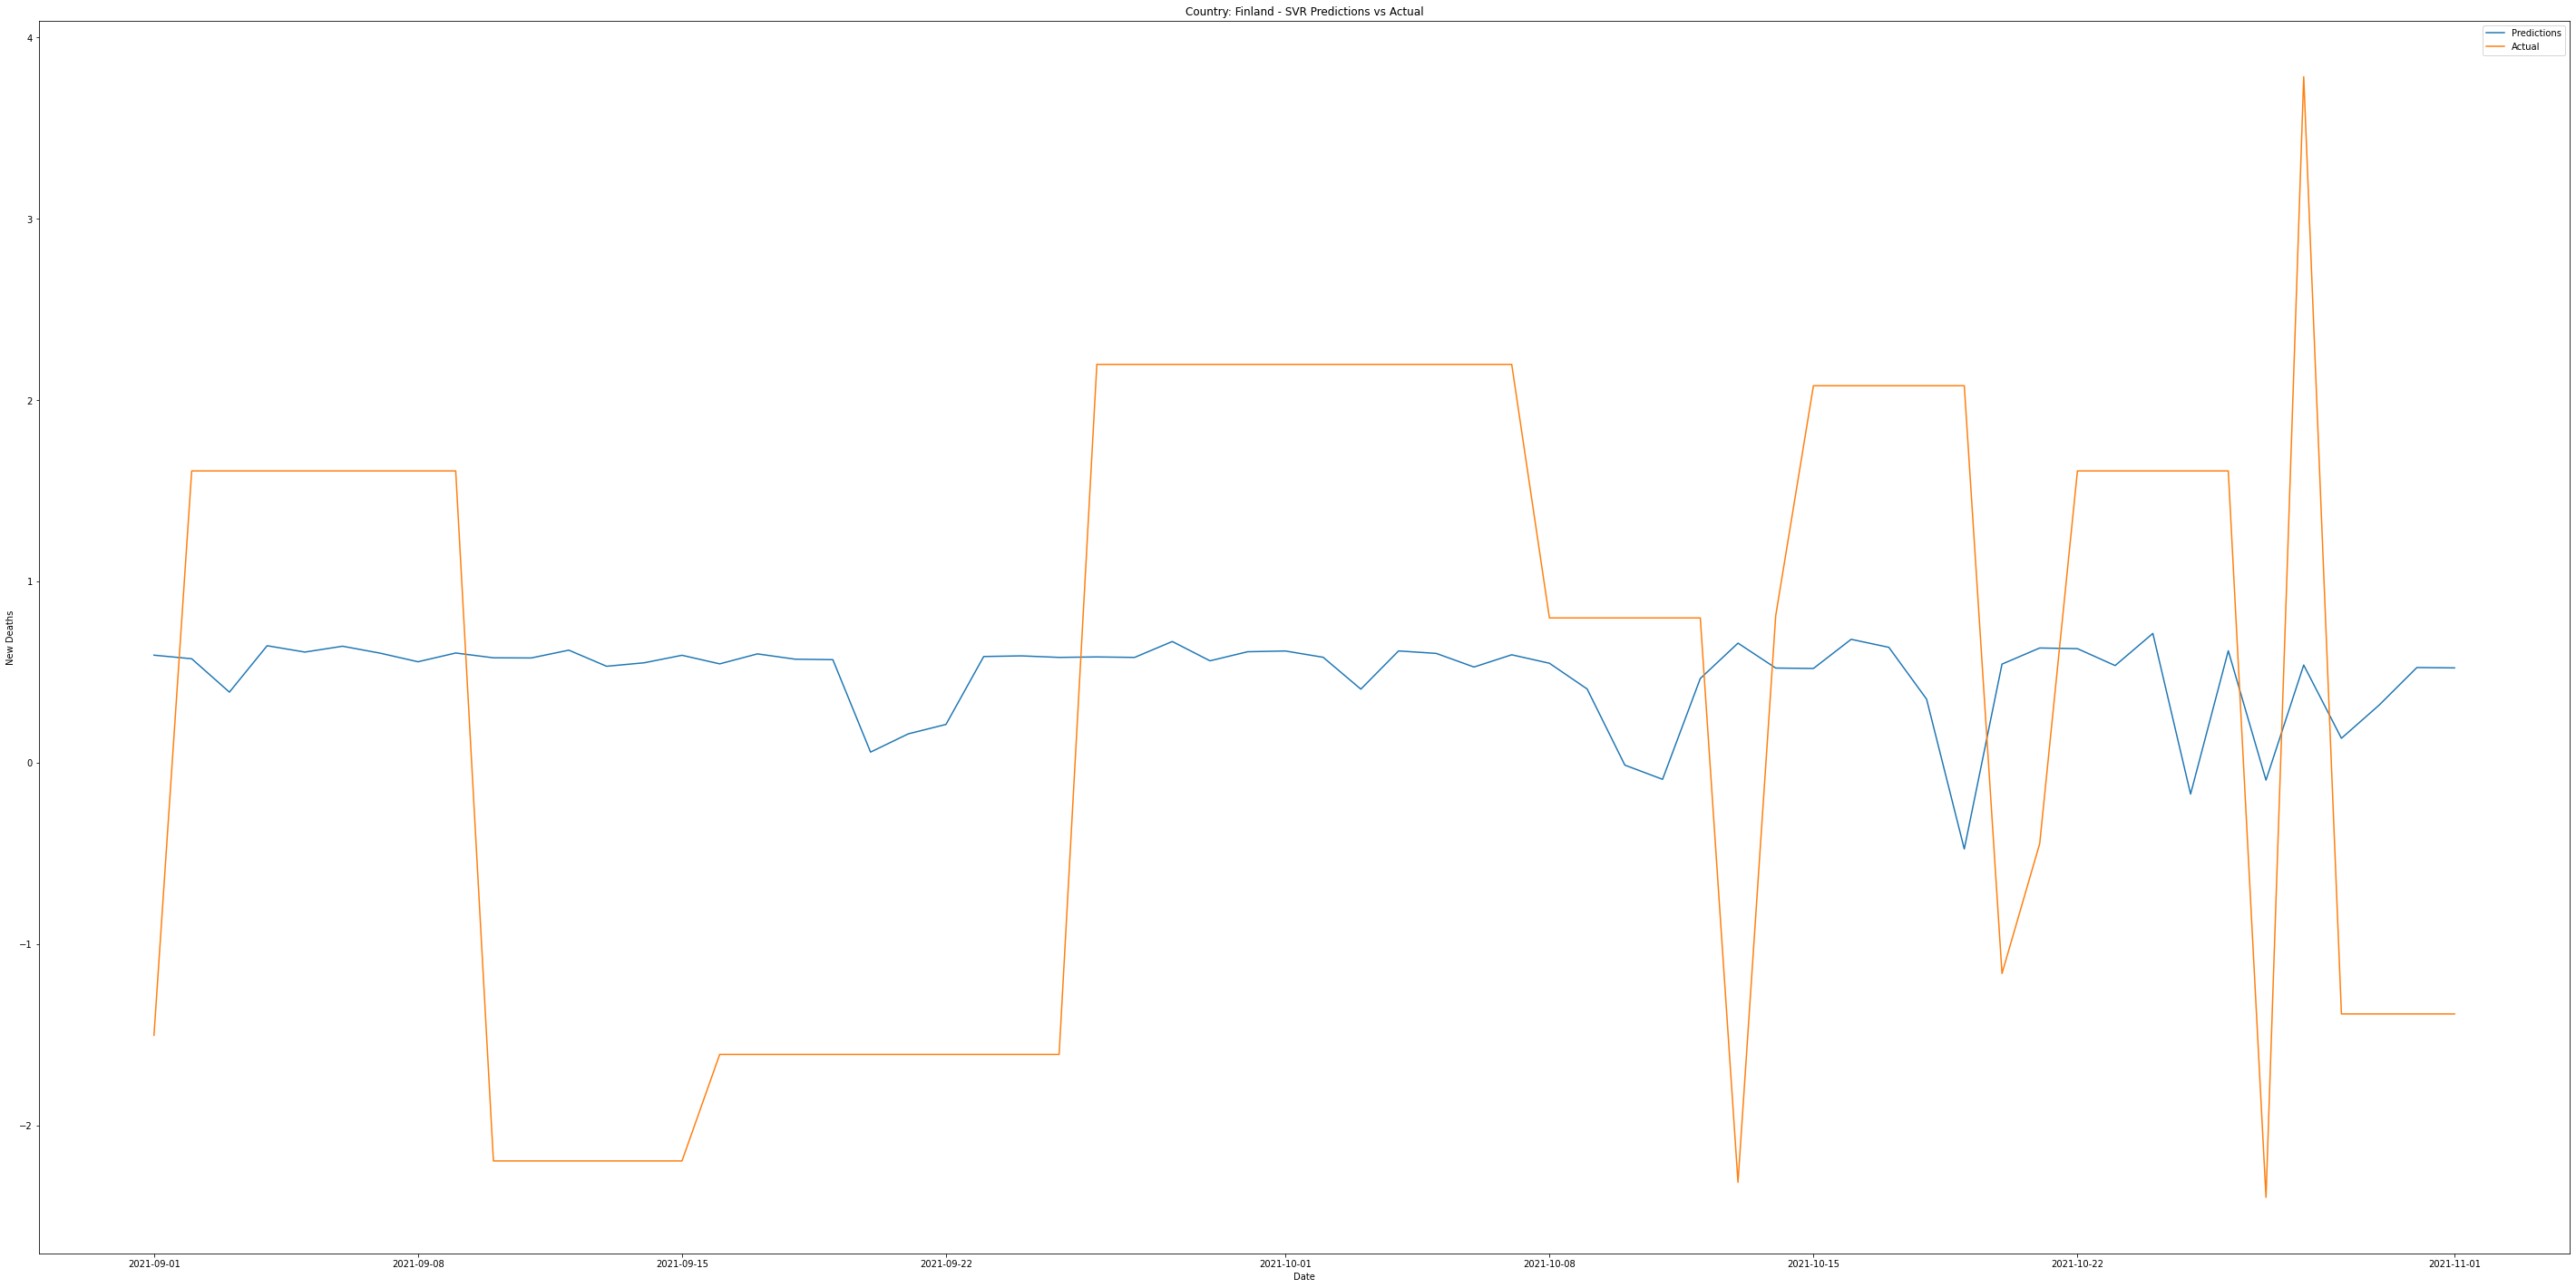

Country: France - C: 9.599999999999984 - SVR Score: 0.390628508179481


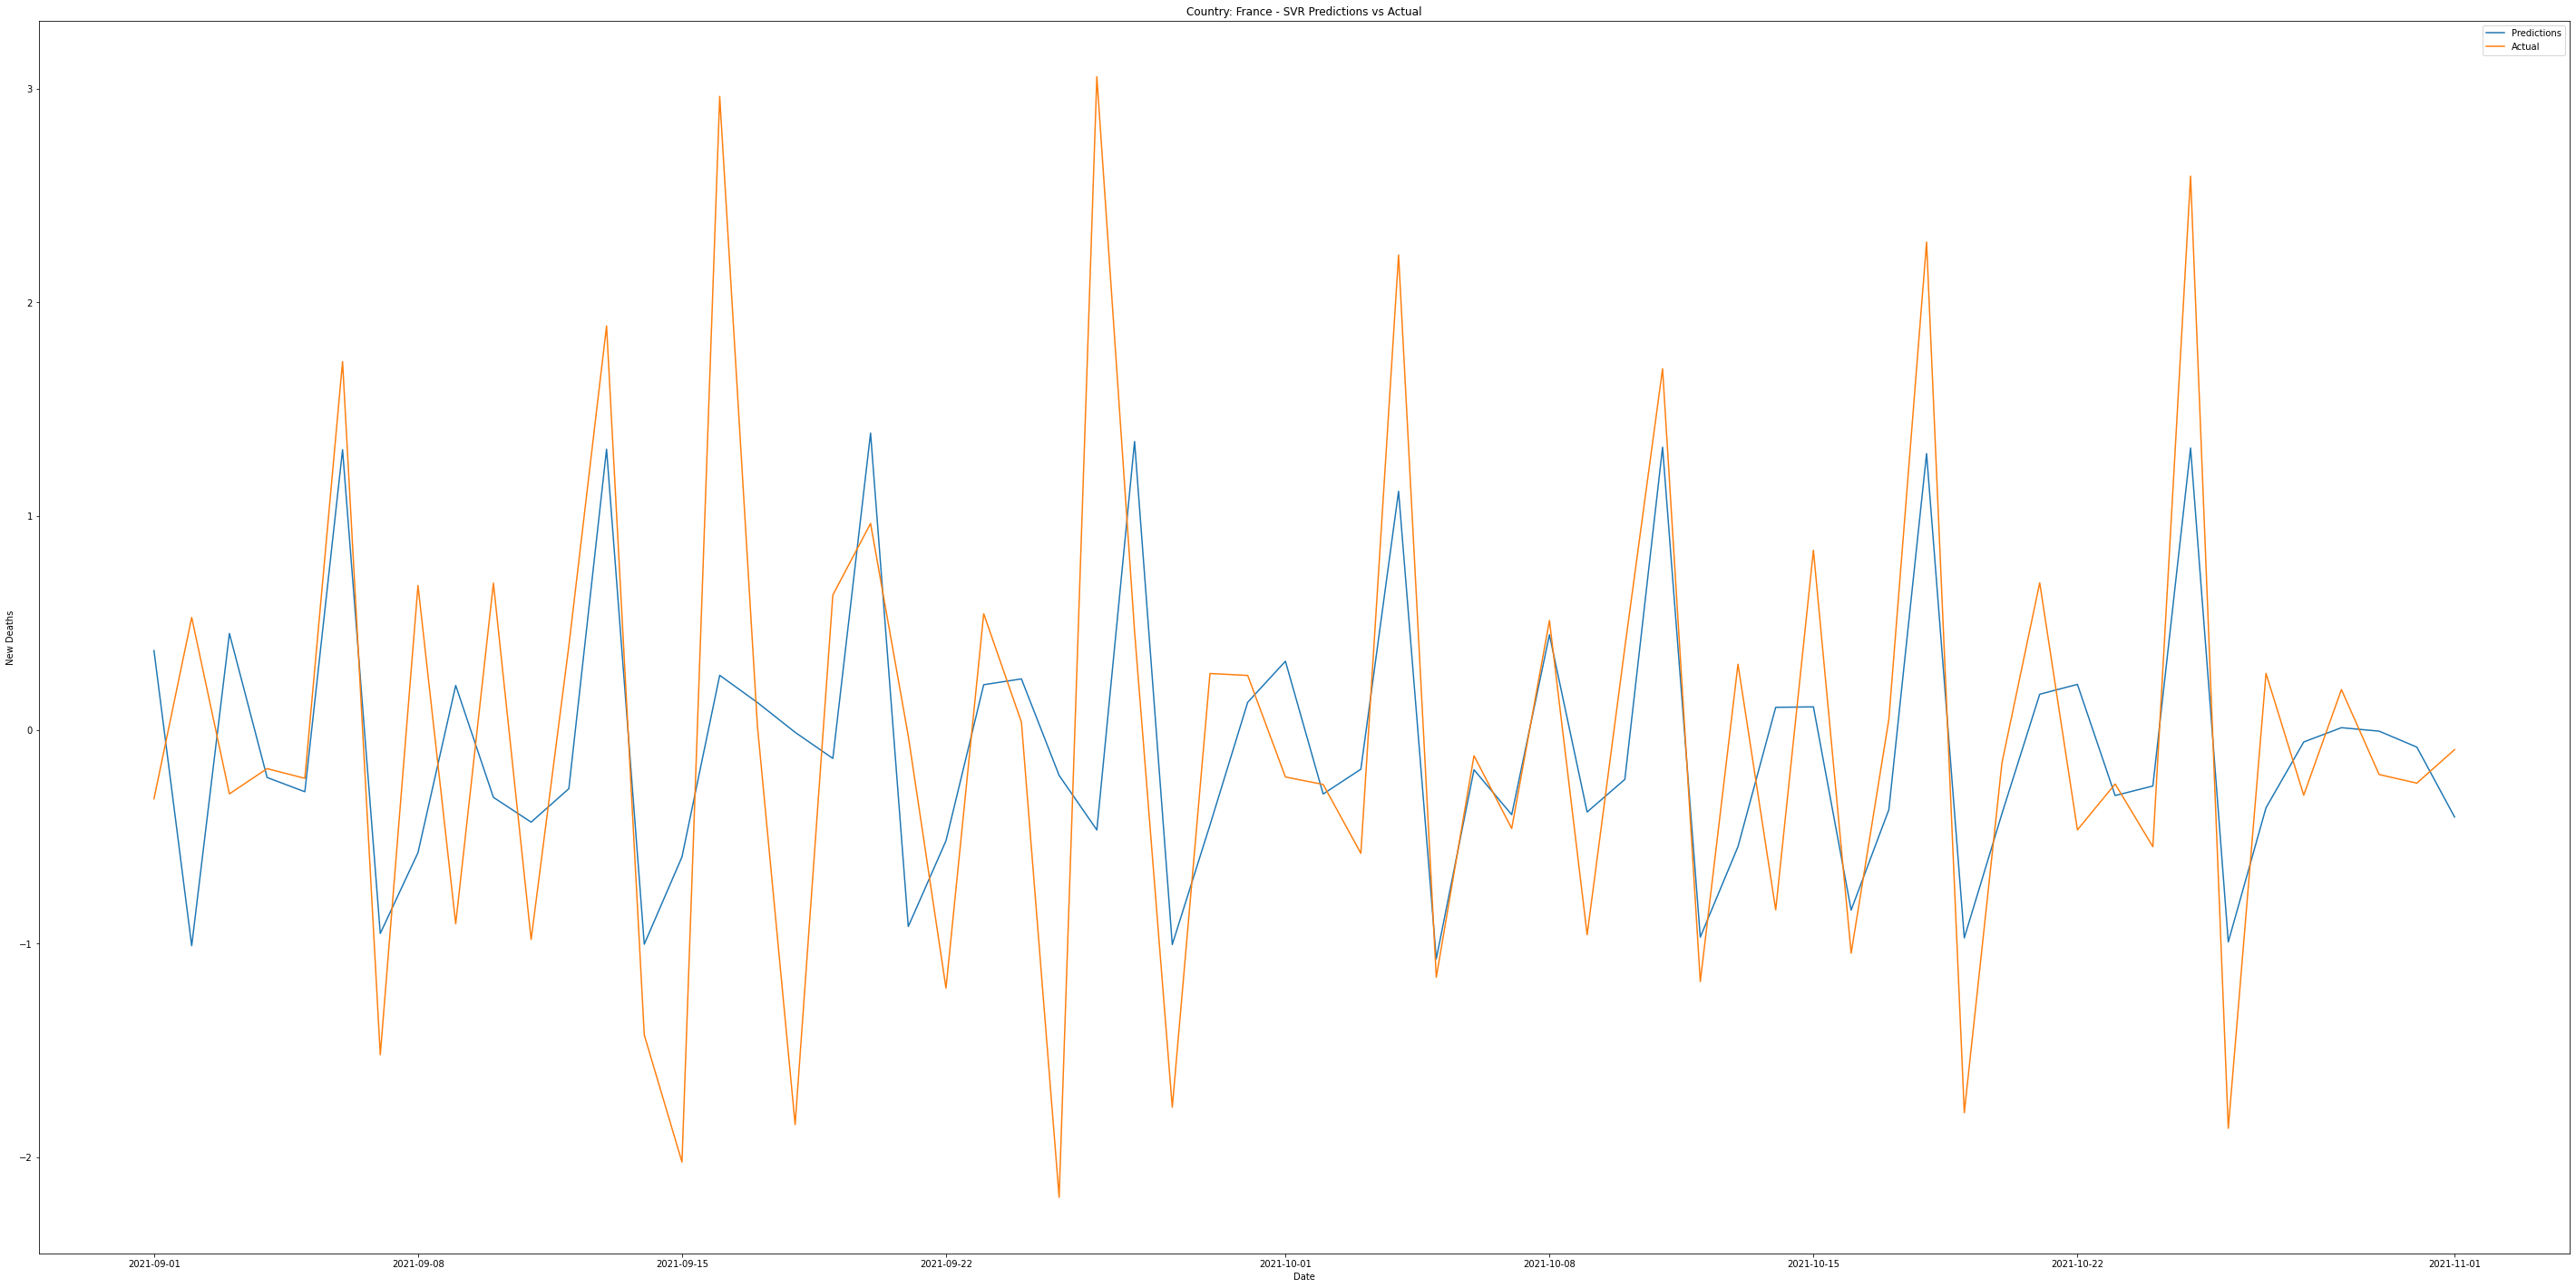

Country: Germany - C: 1.3000000000000003 - SVR Score: 0.2740992211114862


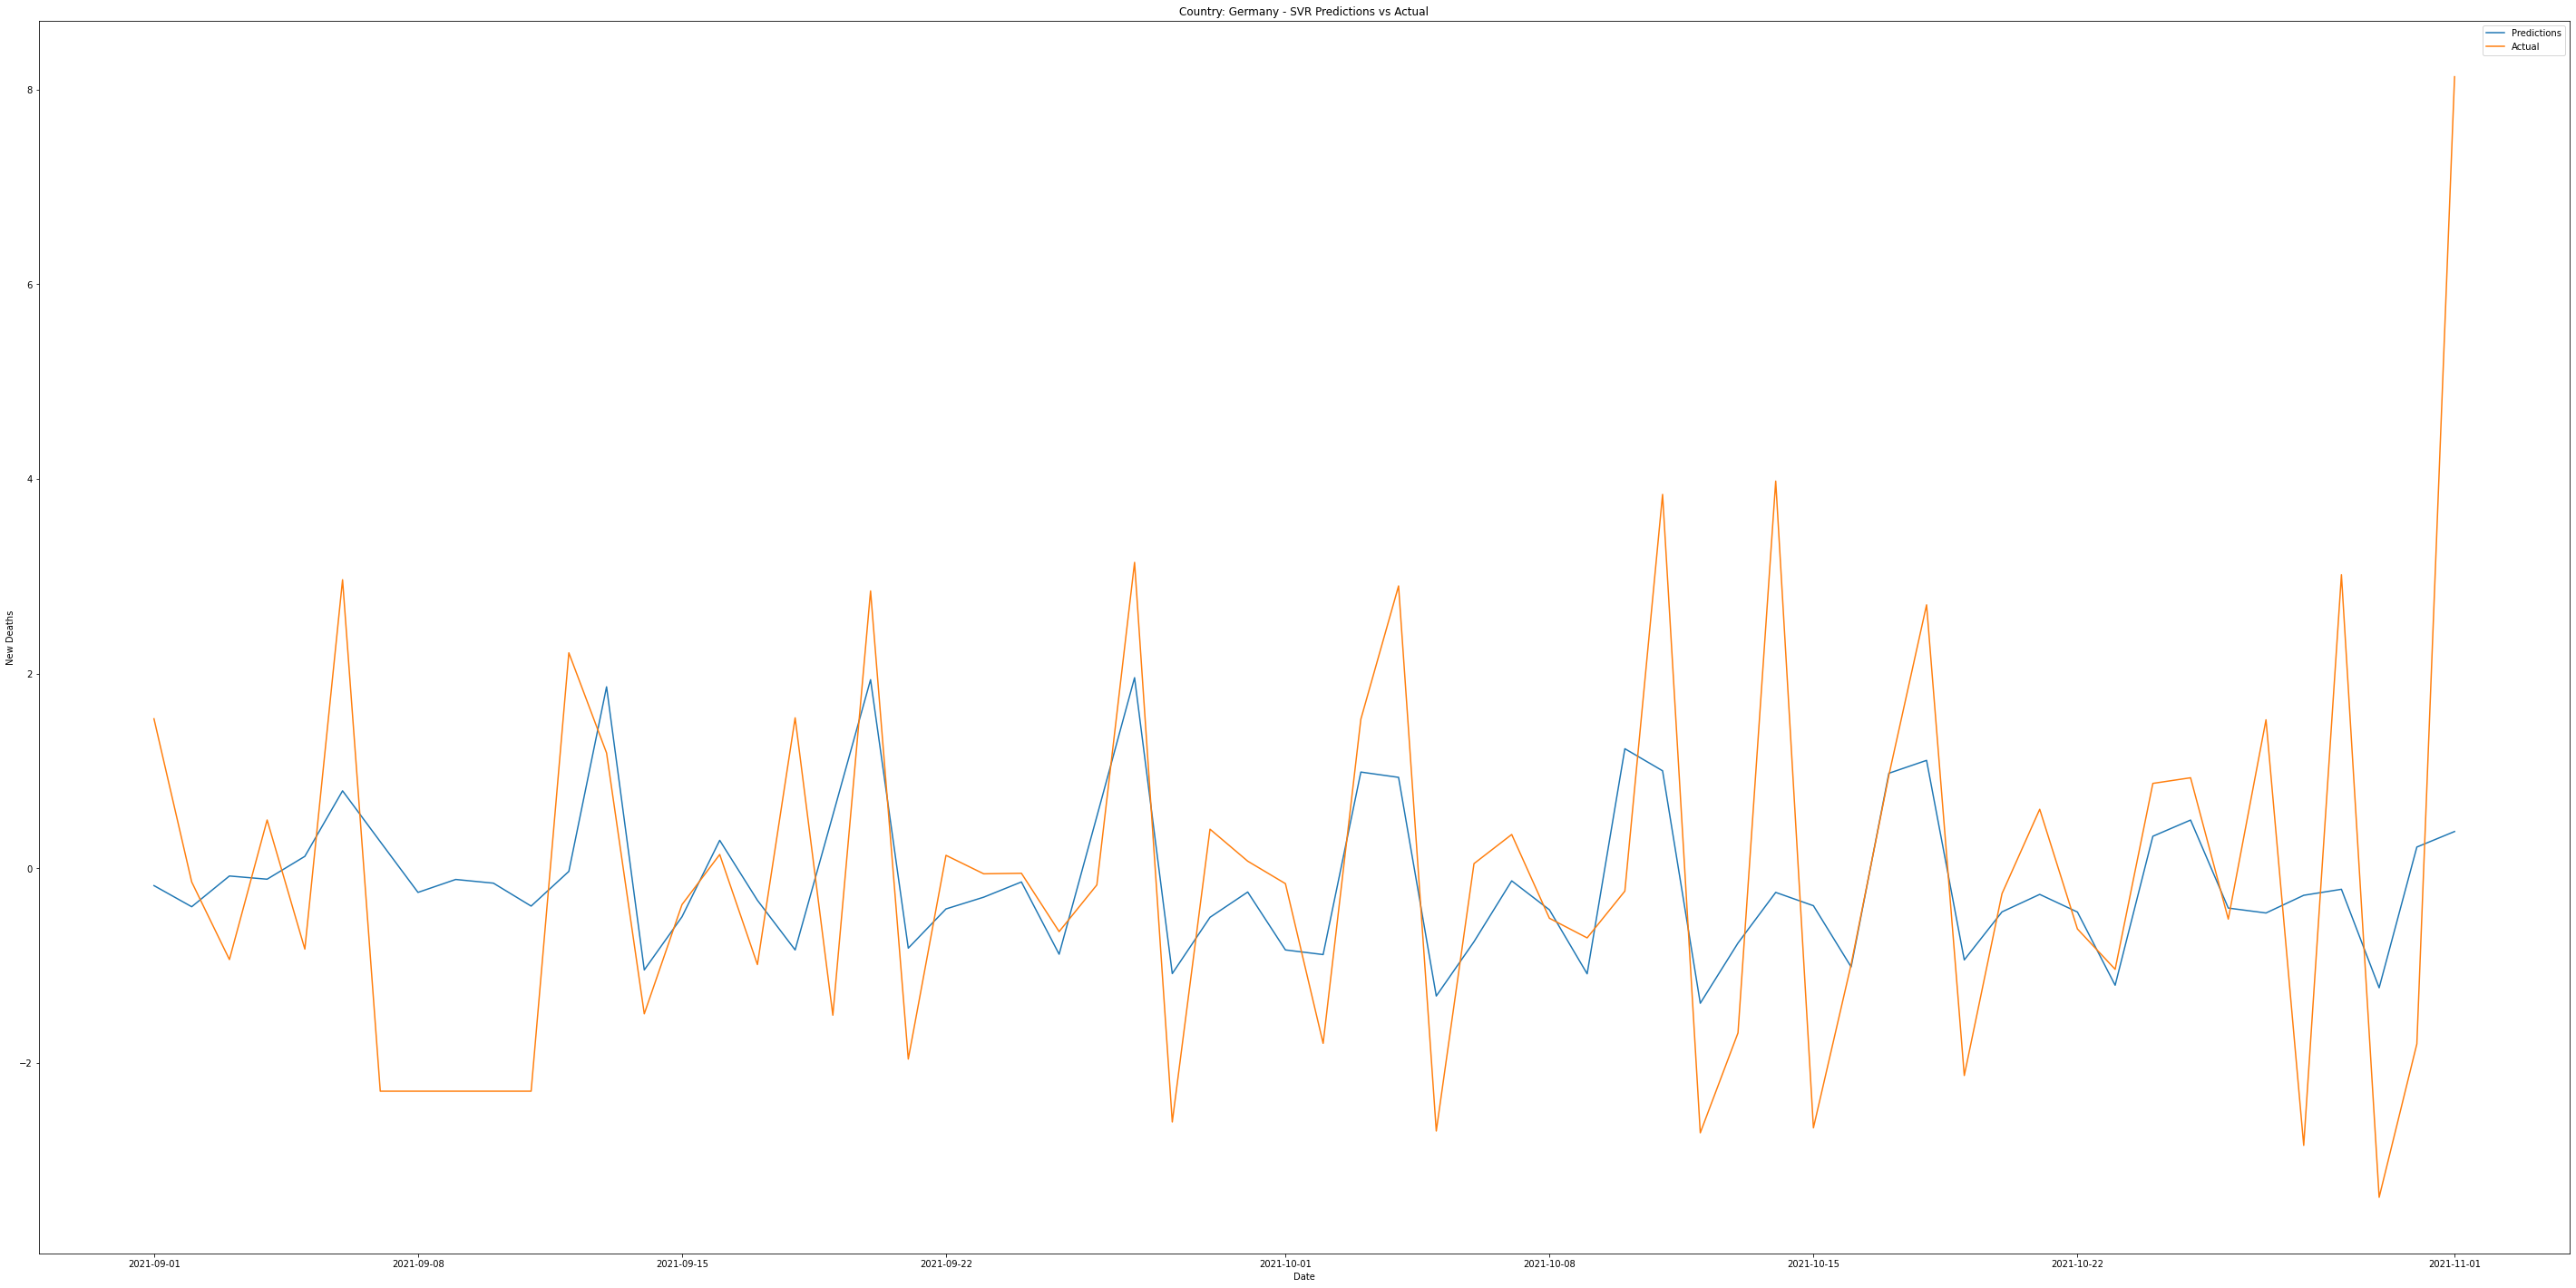

Country: Ireland - C: 1 - SVR Score: 0.0


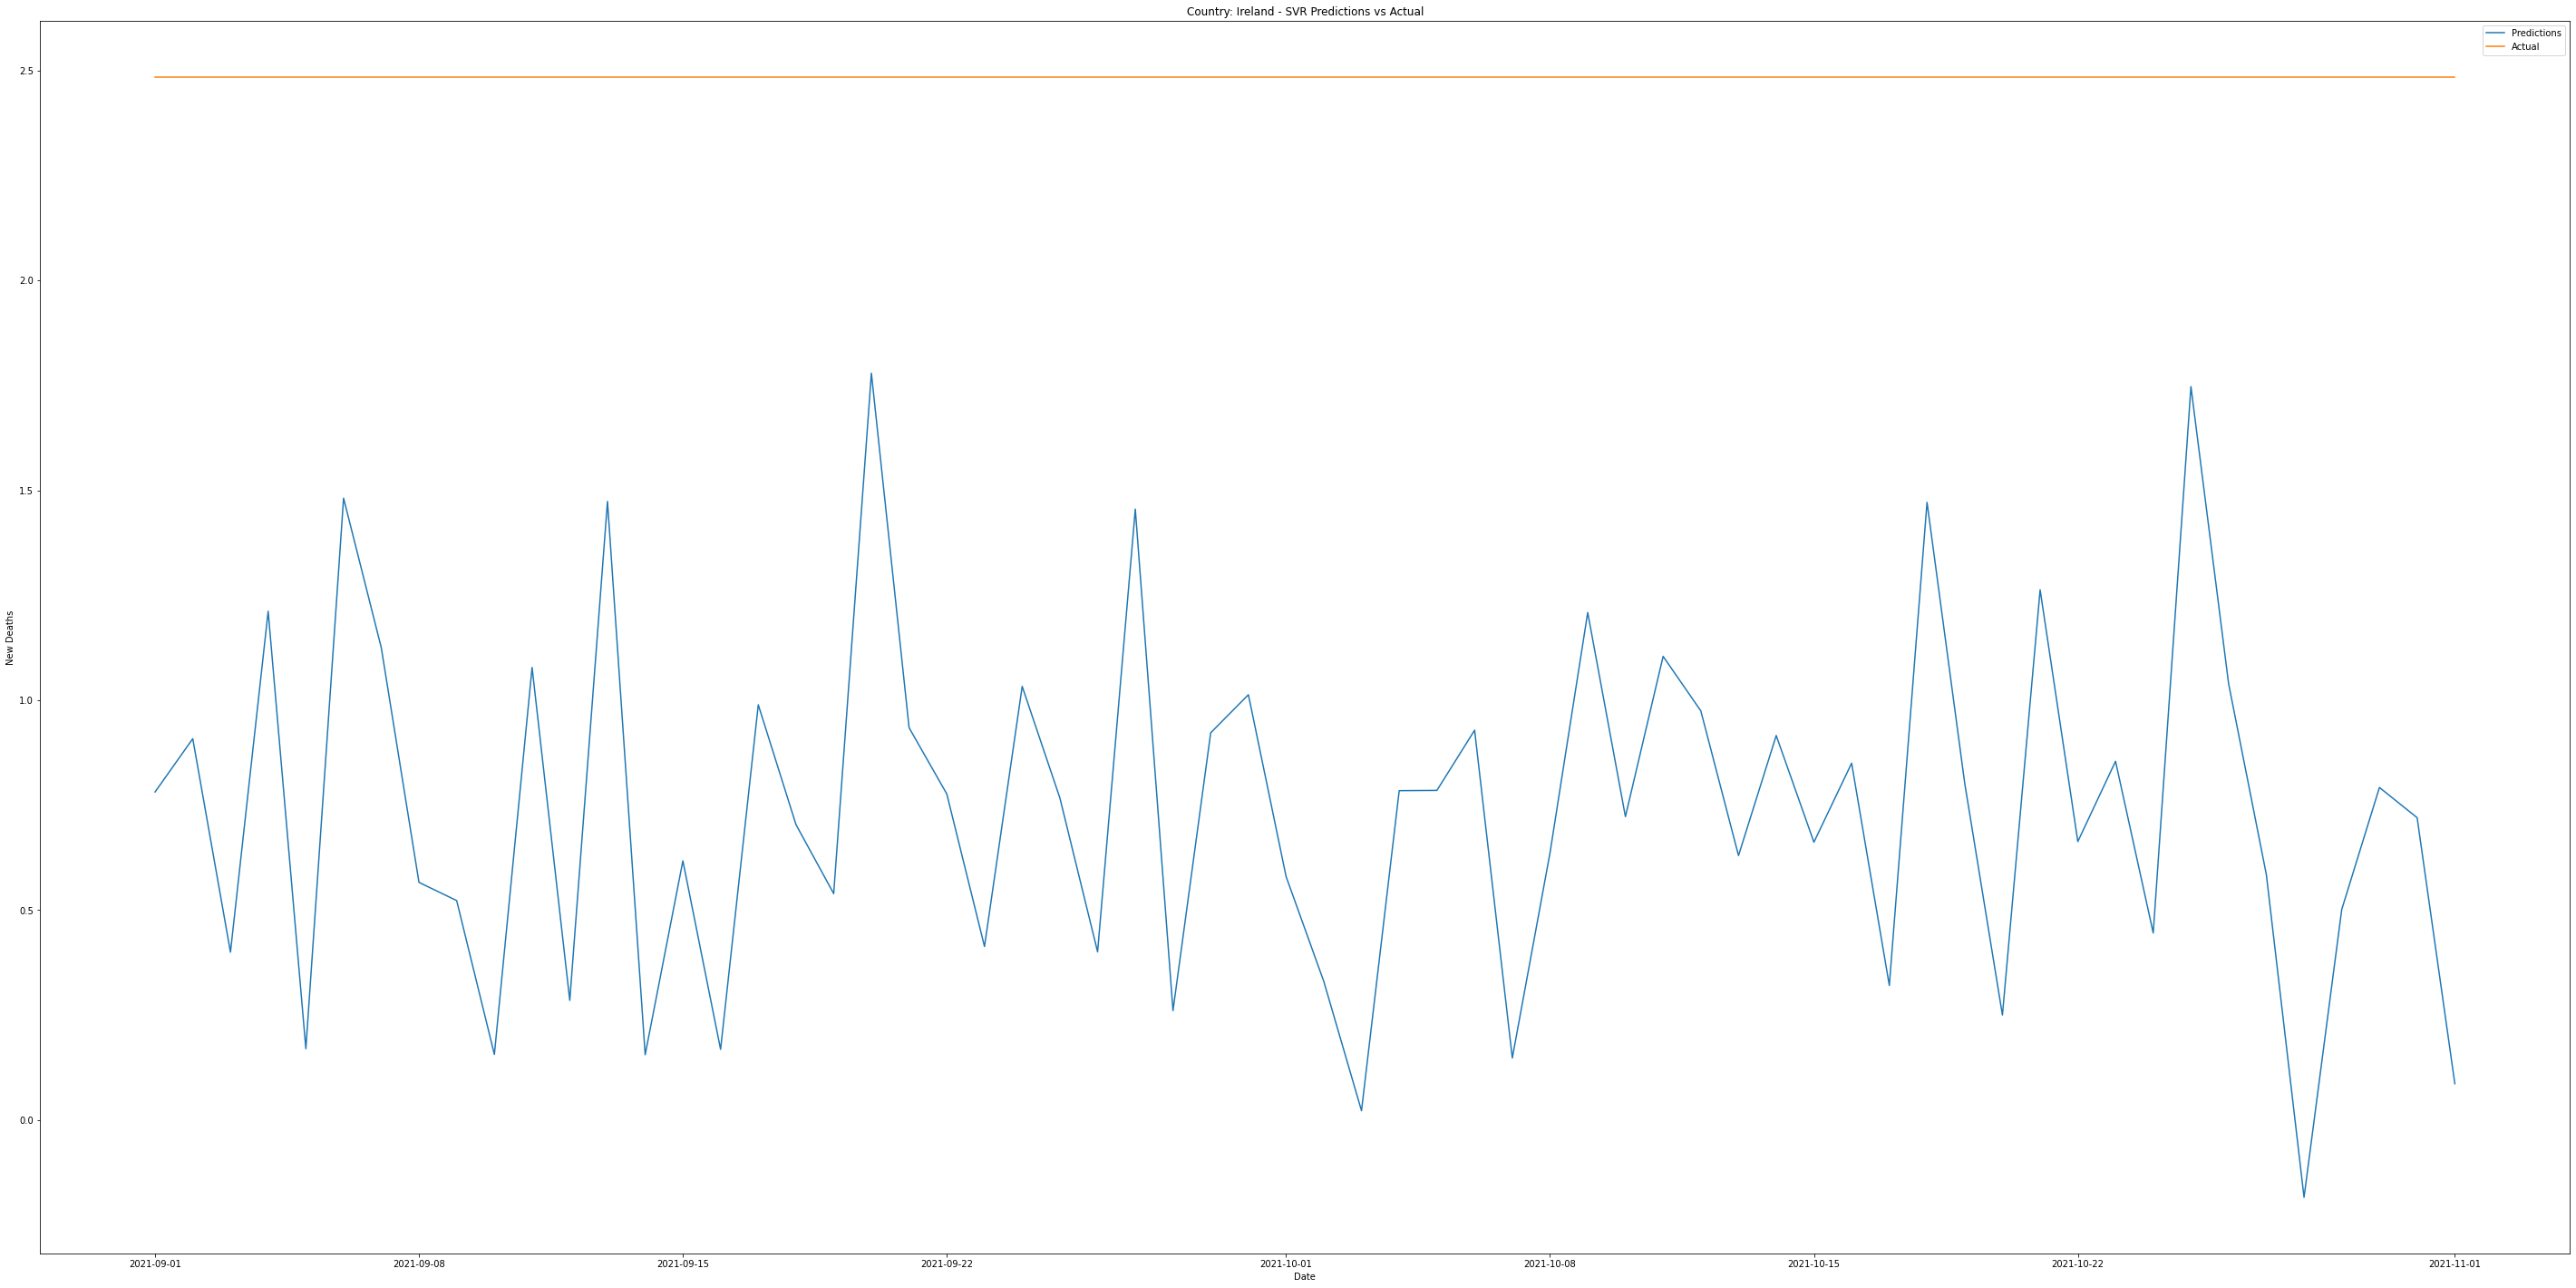

Country: Italy - C: 1 - SVR Score: -0.04244636868956797


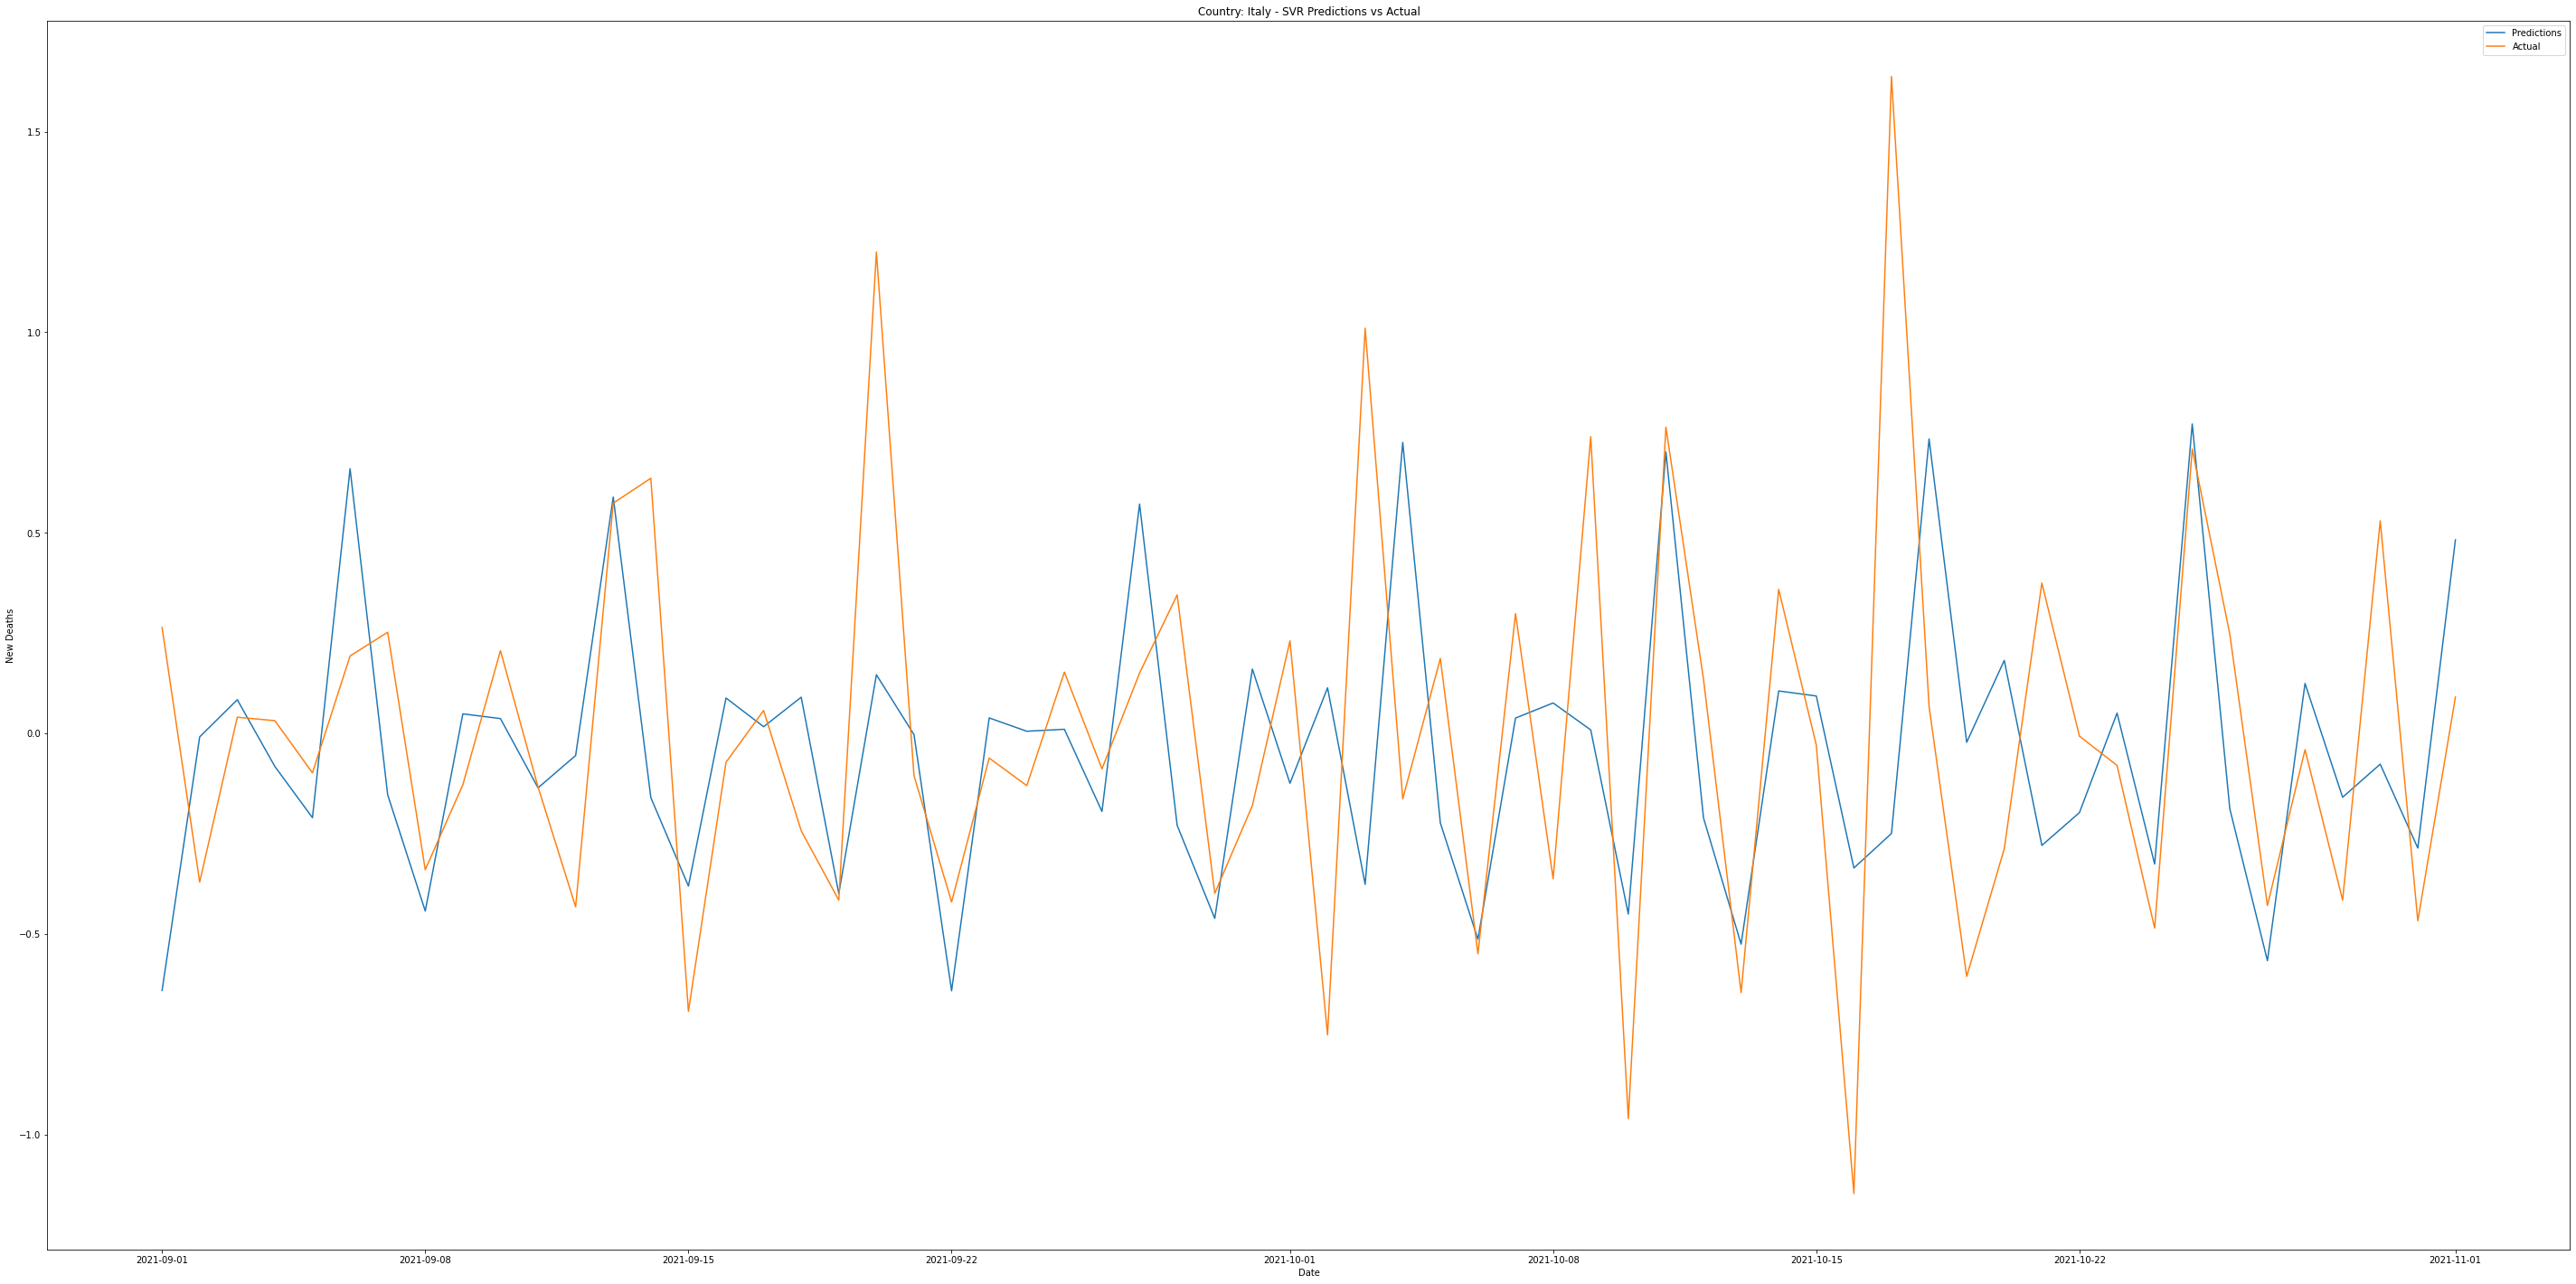

Country: Luxembourg - C: 1.2000000000000002 - SVR Score: -4.016495104702008e+30


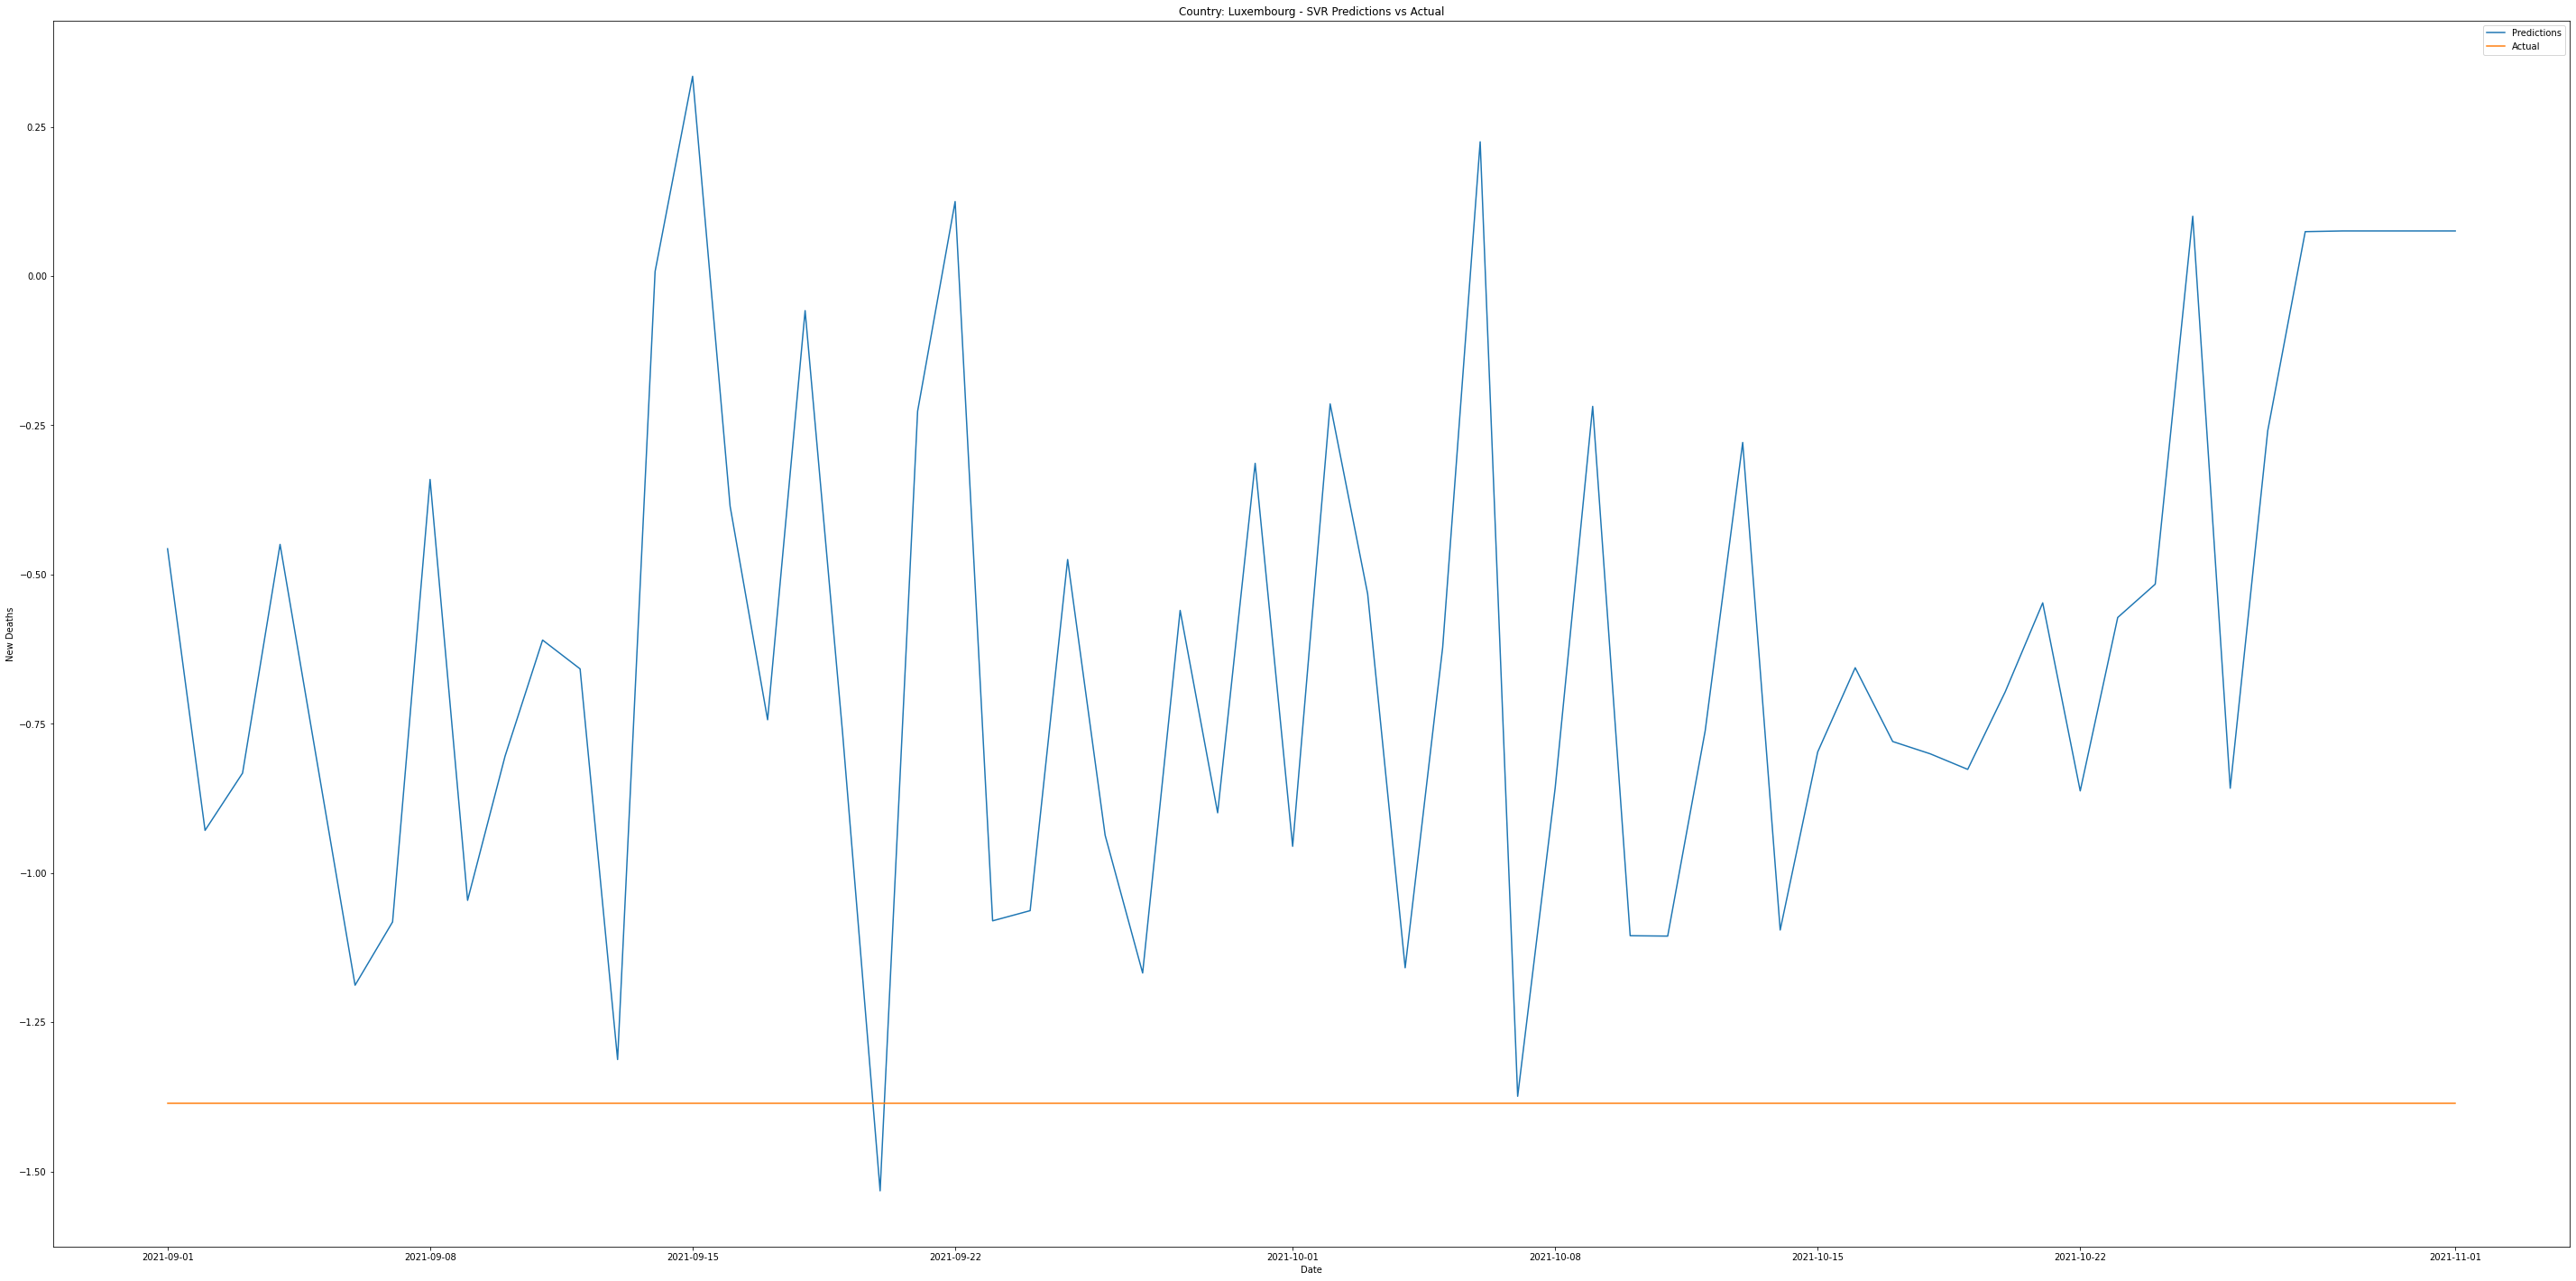

Country: Malta - C: 1 - SVR Score: -19.01007961667552


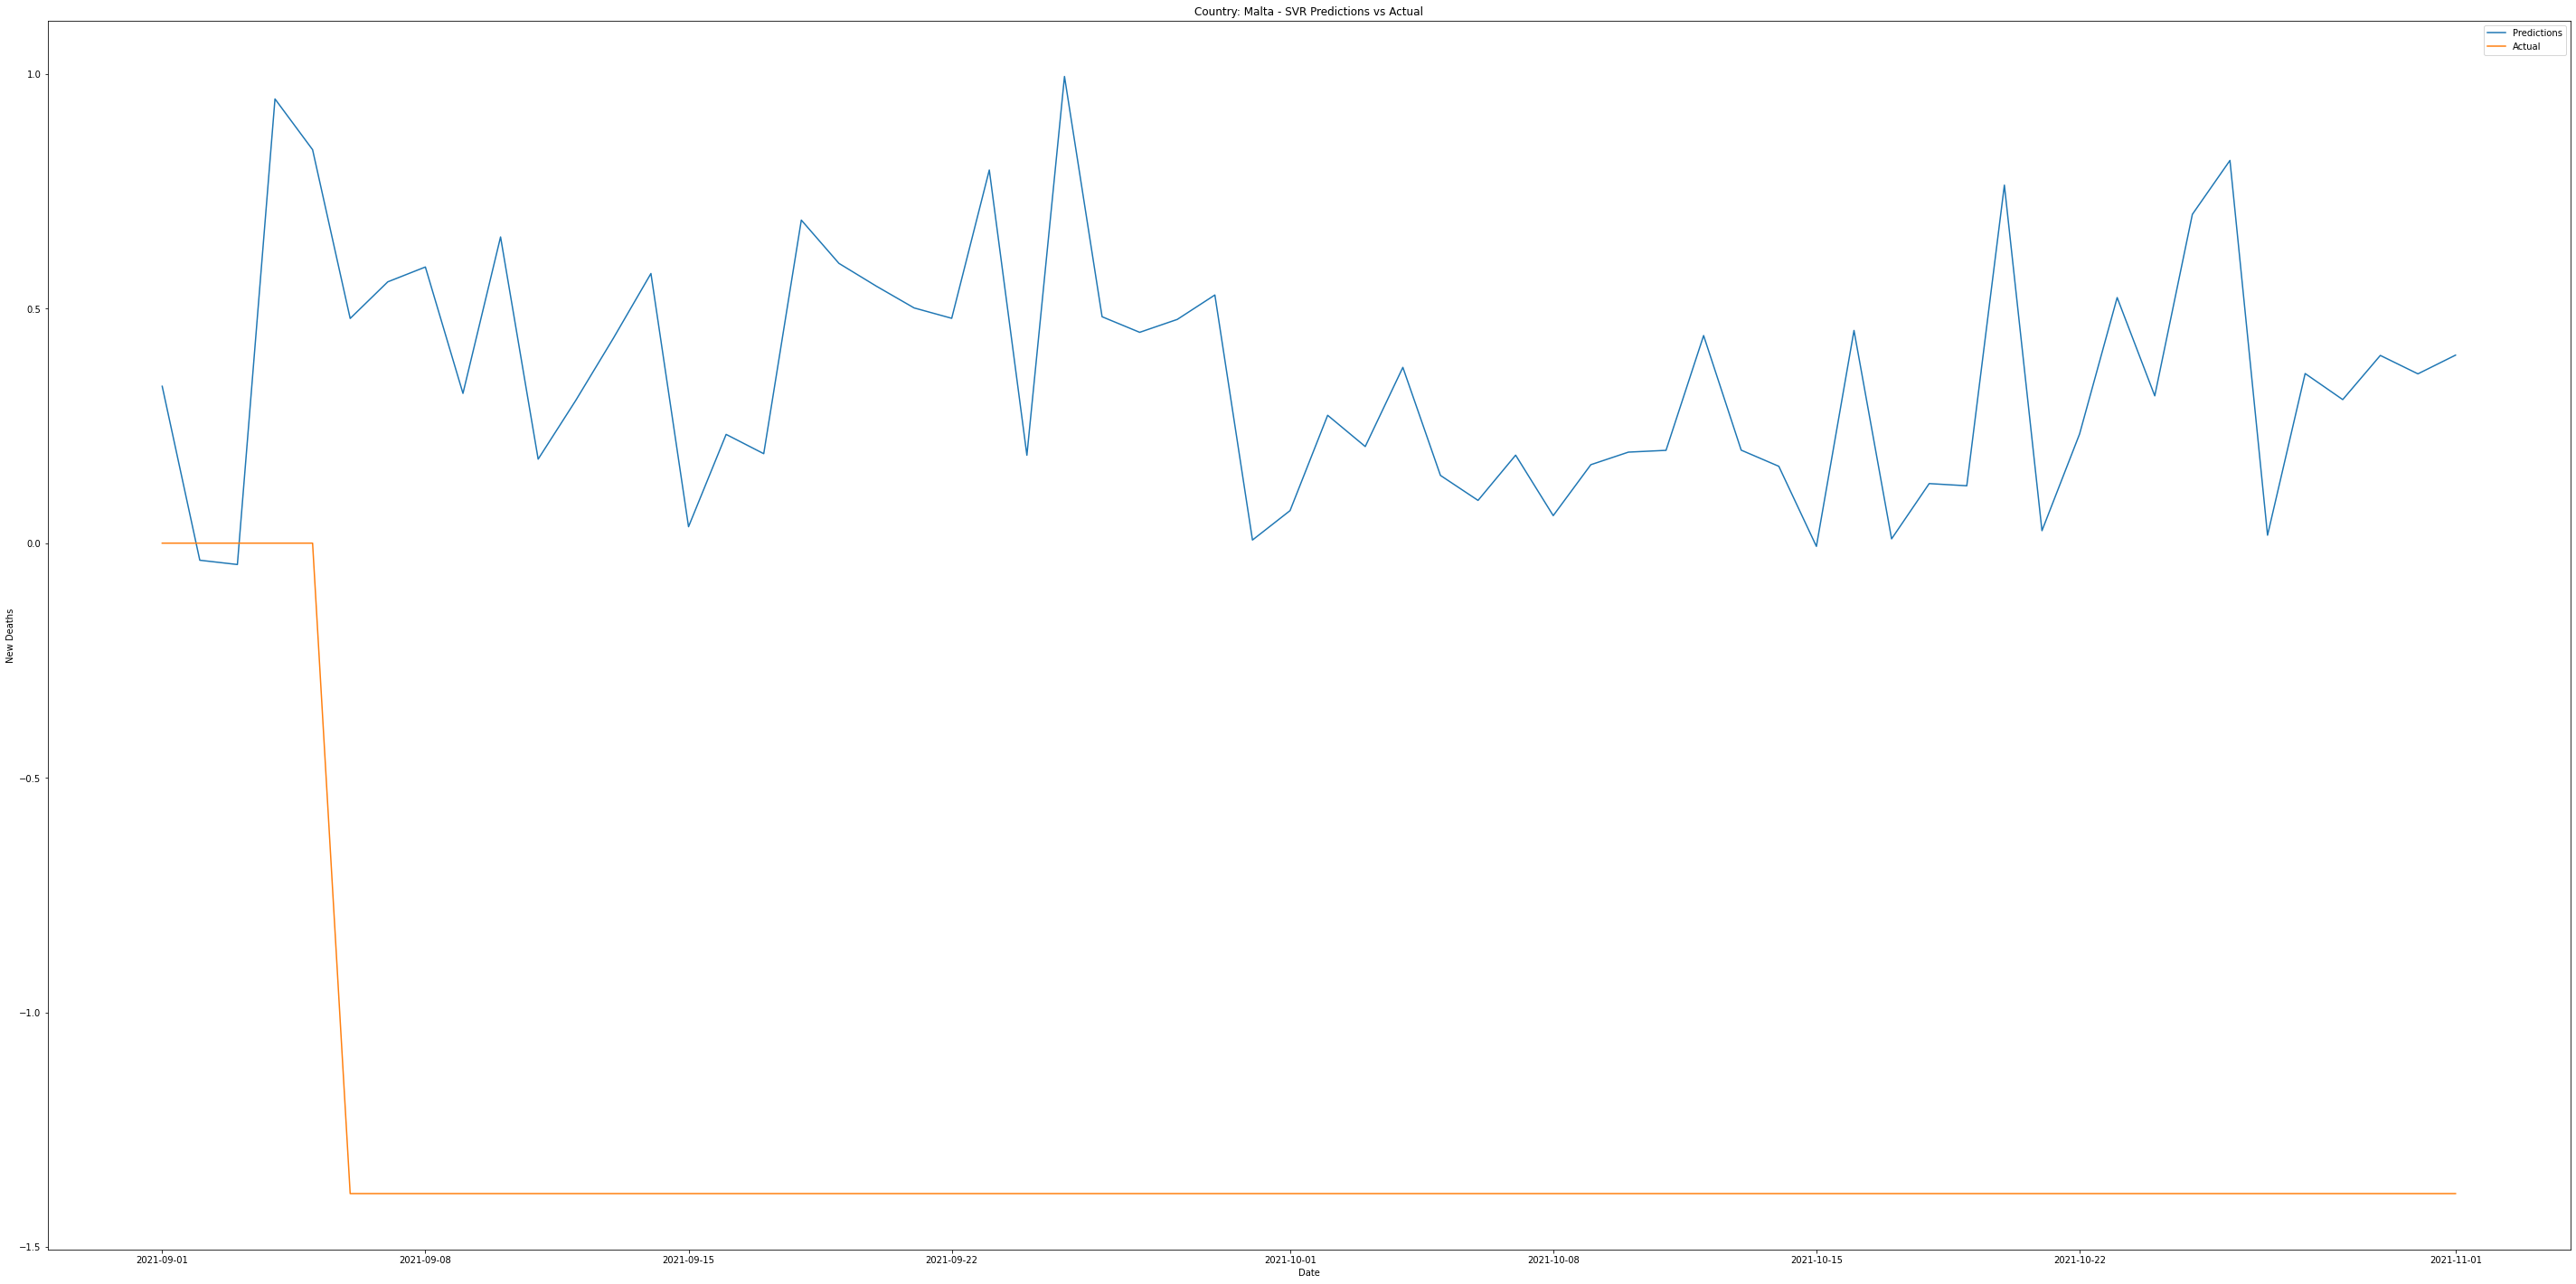

Country: Netherlands - C: 9.999999999999982 - SVR Score: 0.03572674985207869


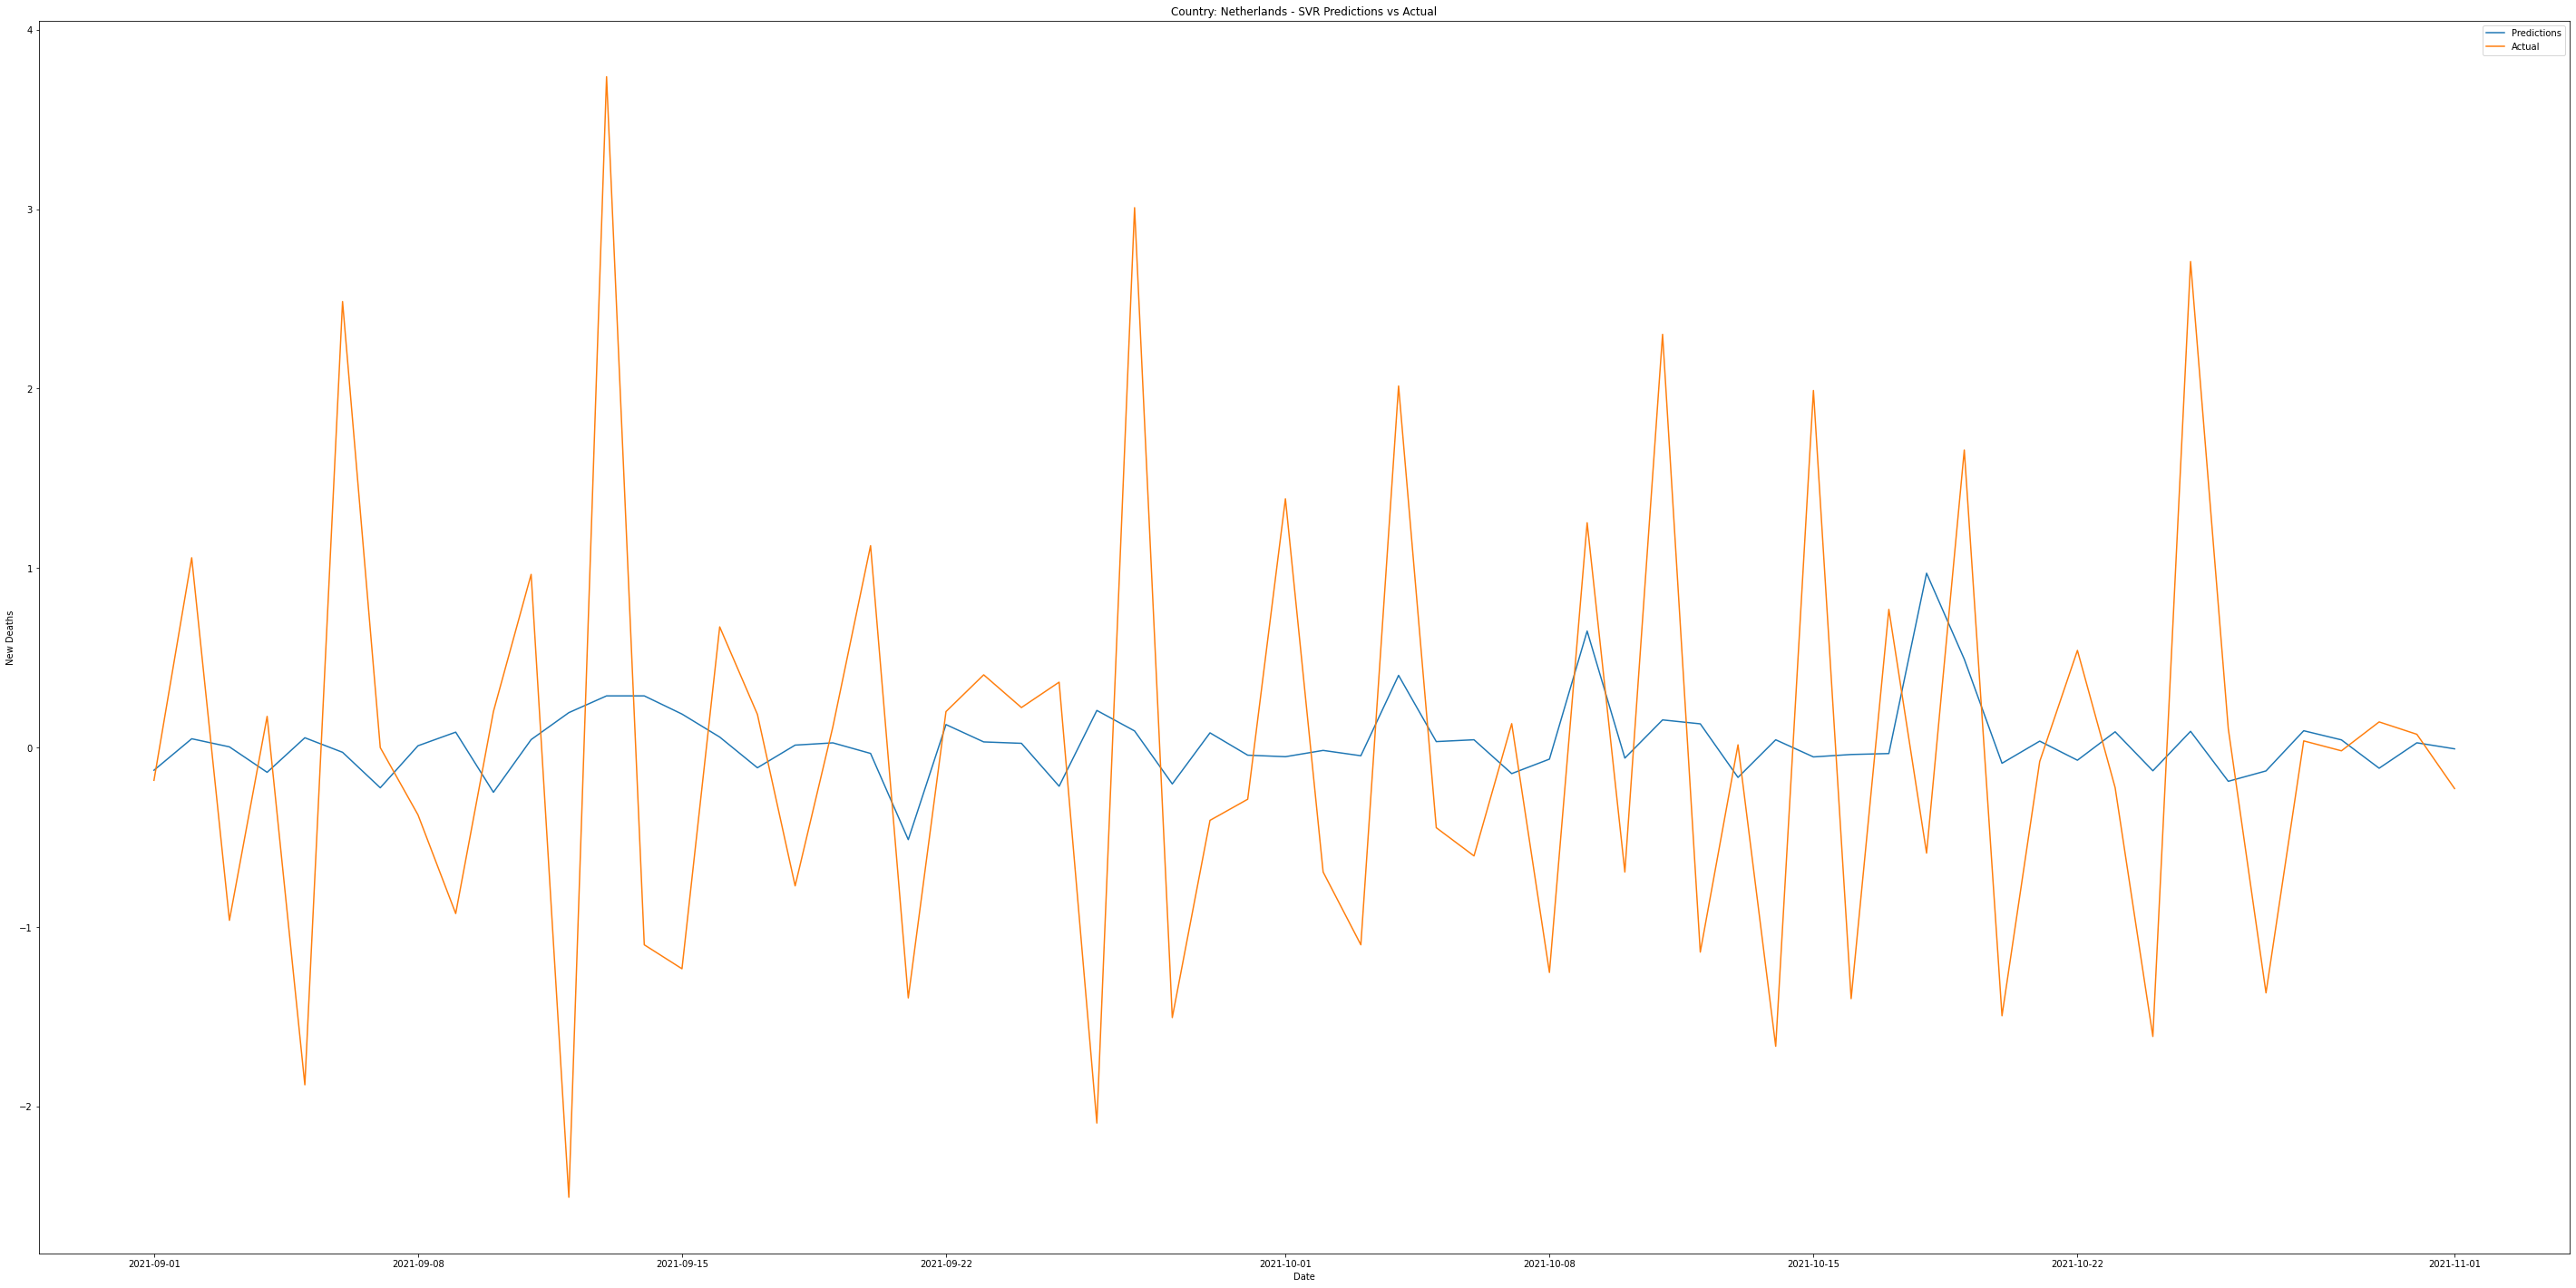

Country: Portugal - C: 1 - SVR Score: -0.04182766452993625


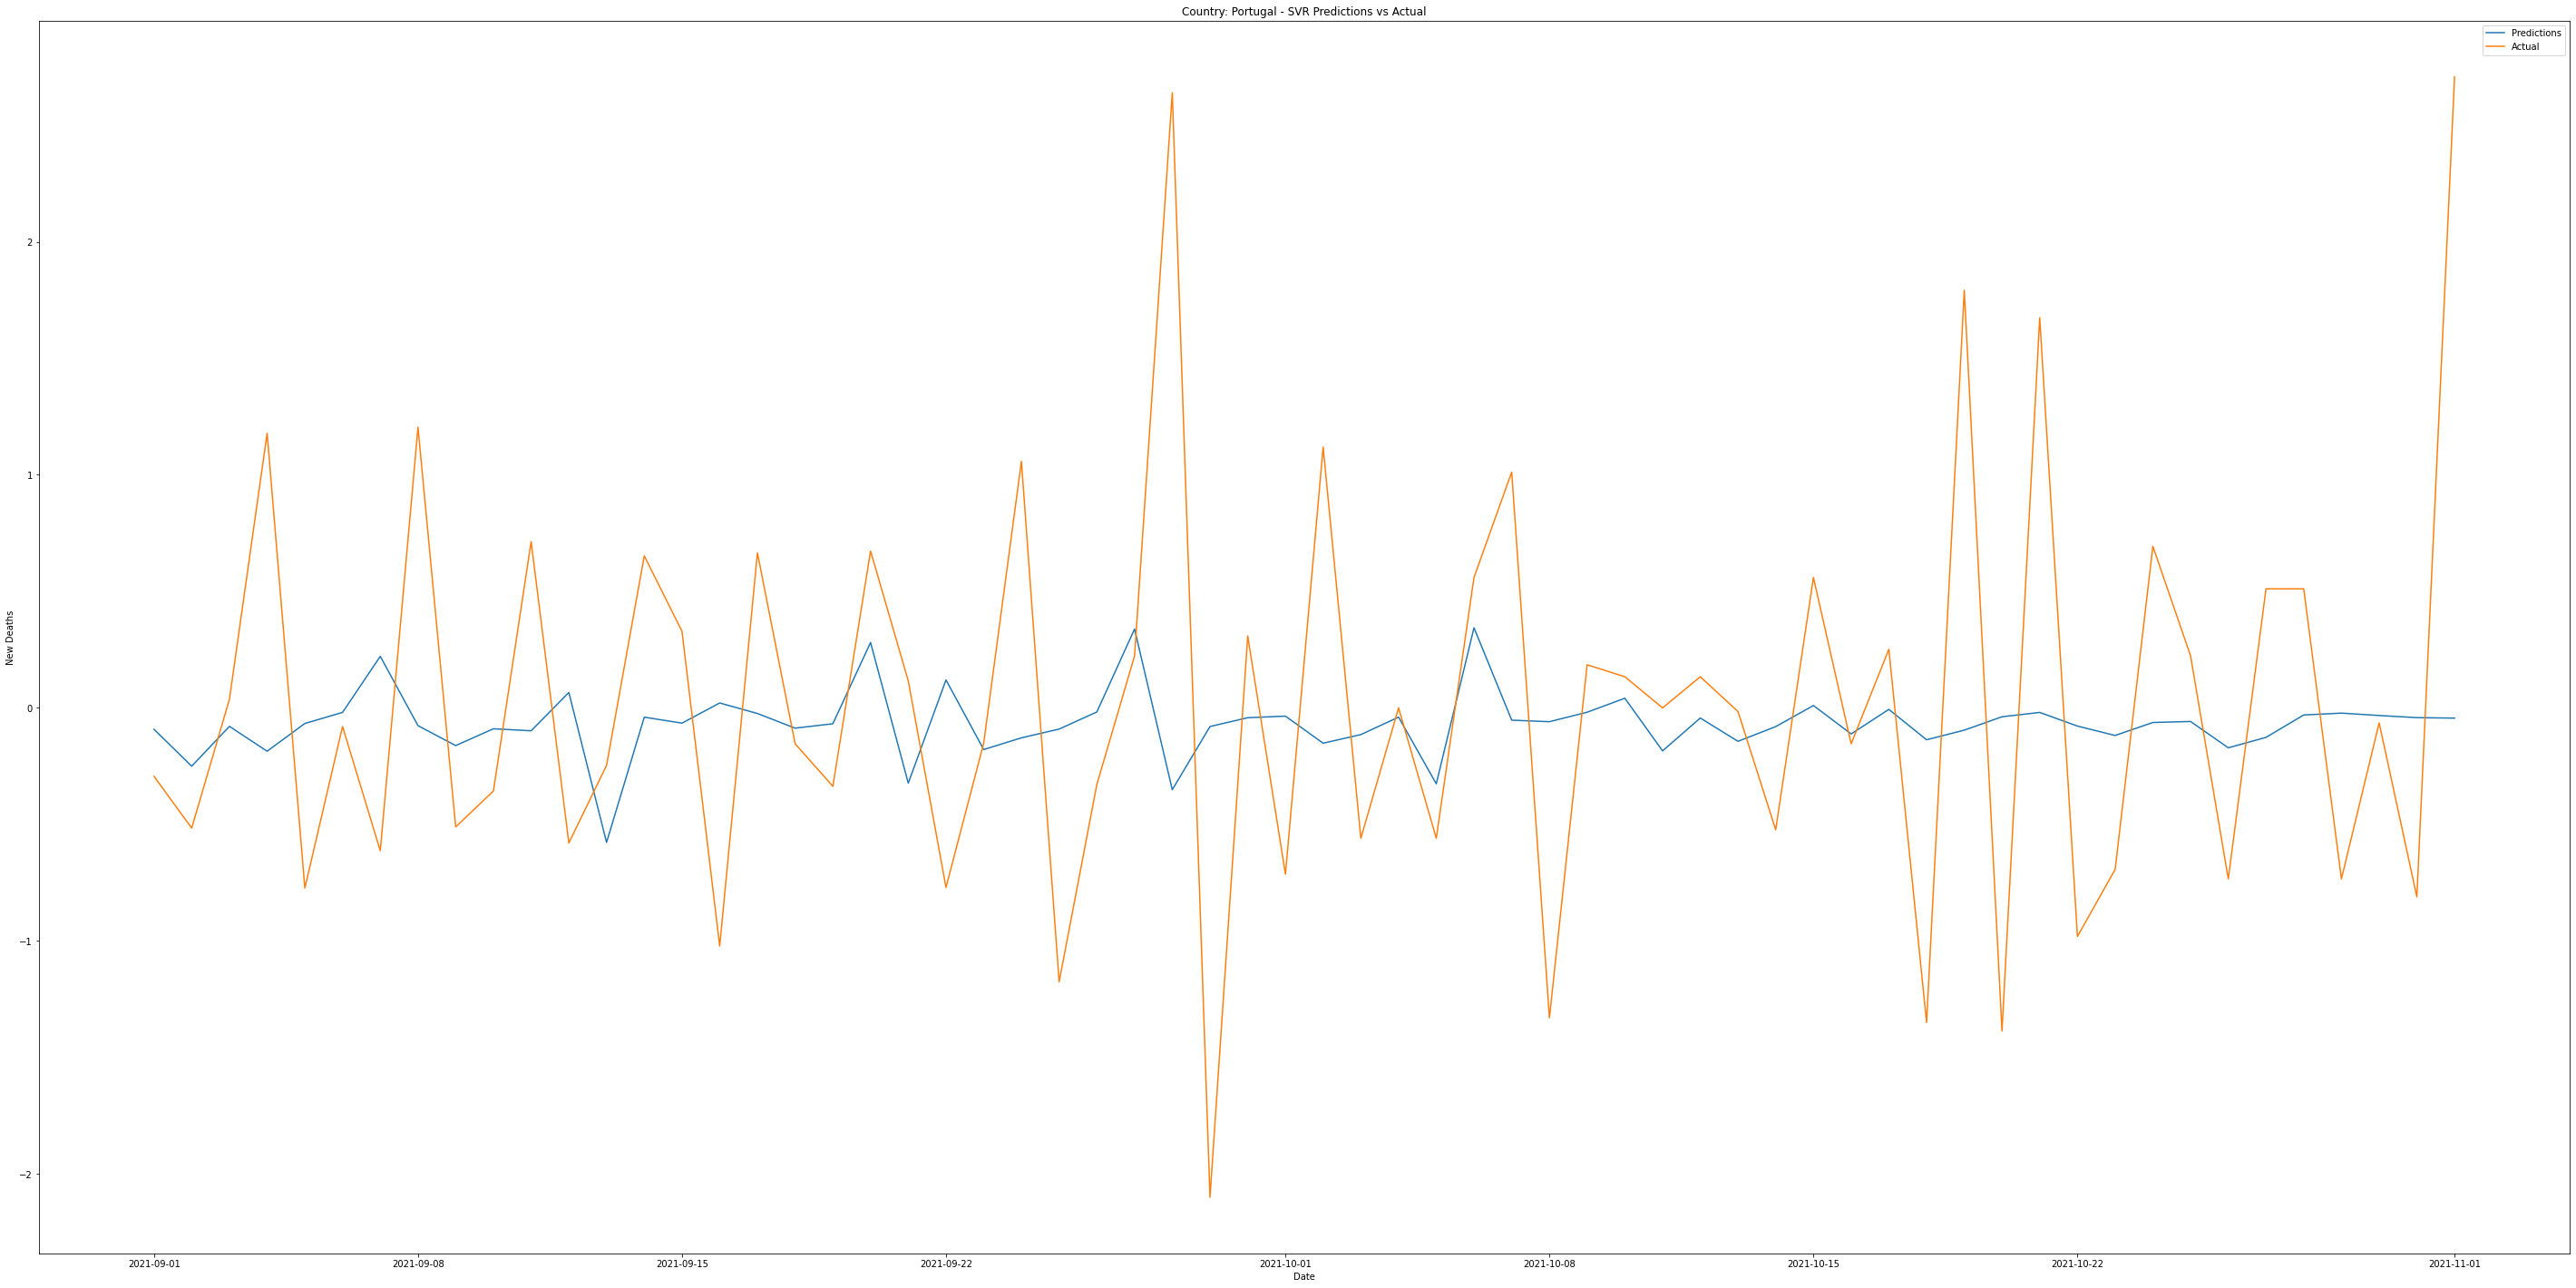

Country: Romania - C: 1 - SVR Score: -0.005853051774330265


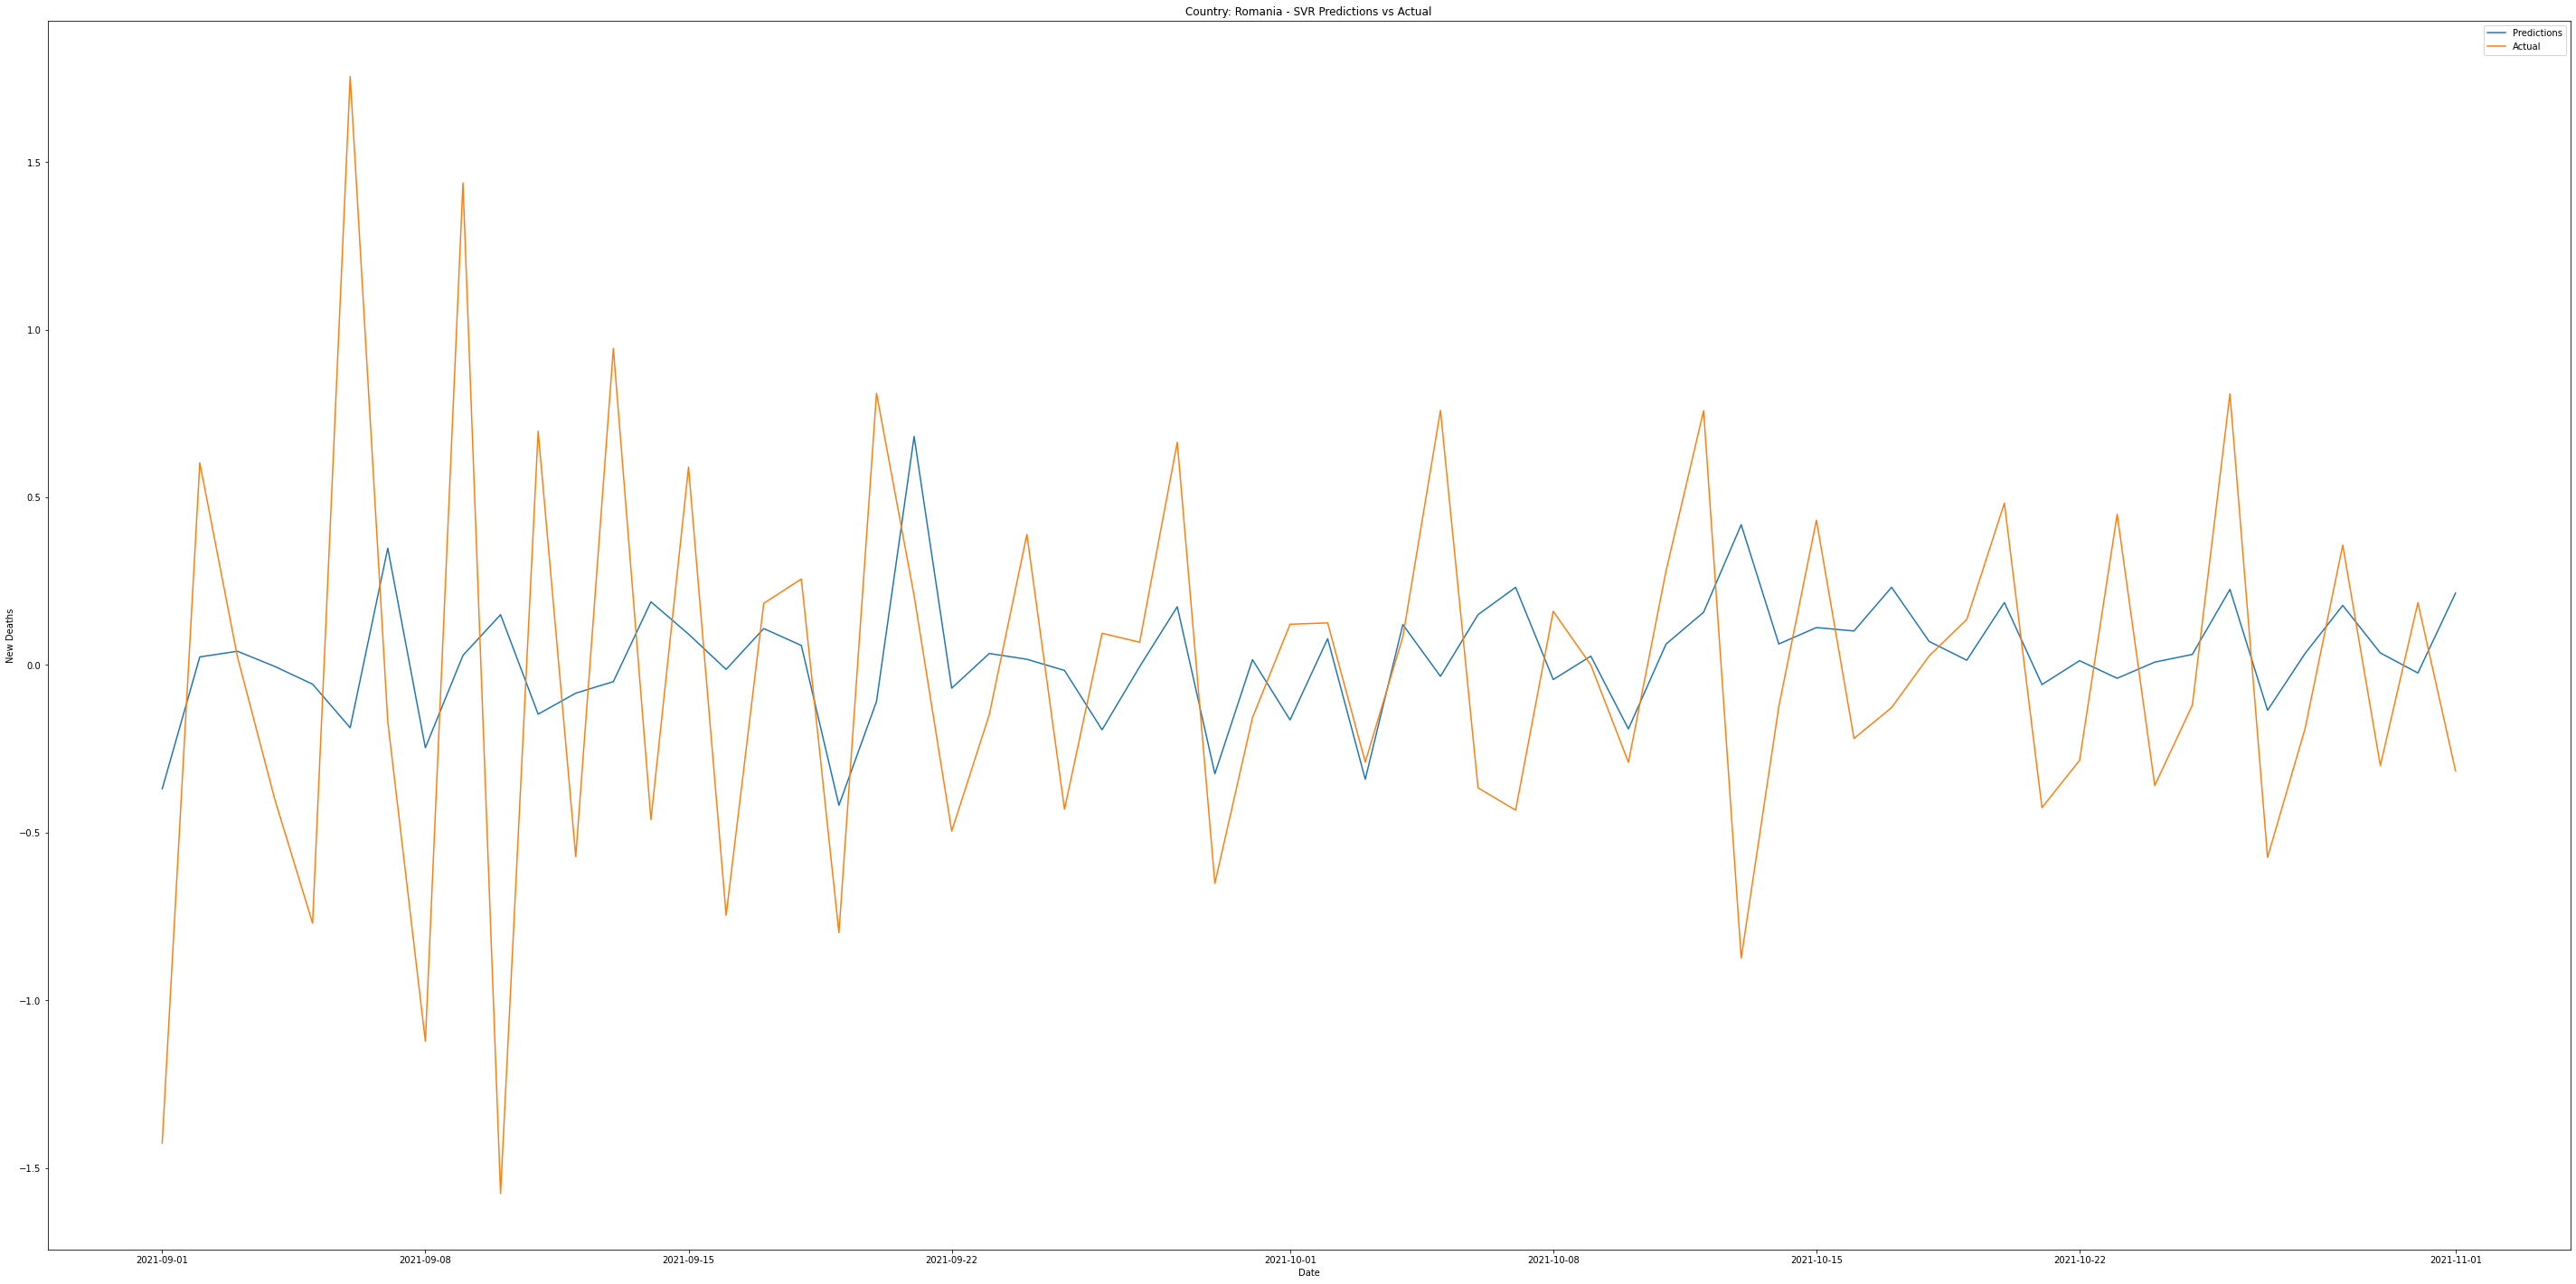

Country: Serbia - C: 1 - SVR Score: -0.28907809534525586


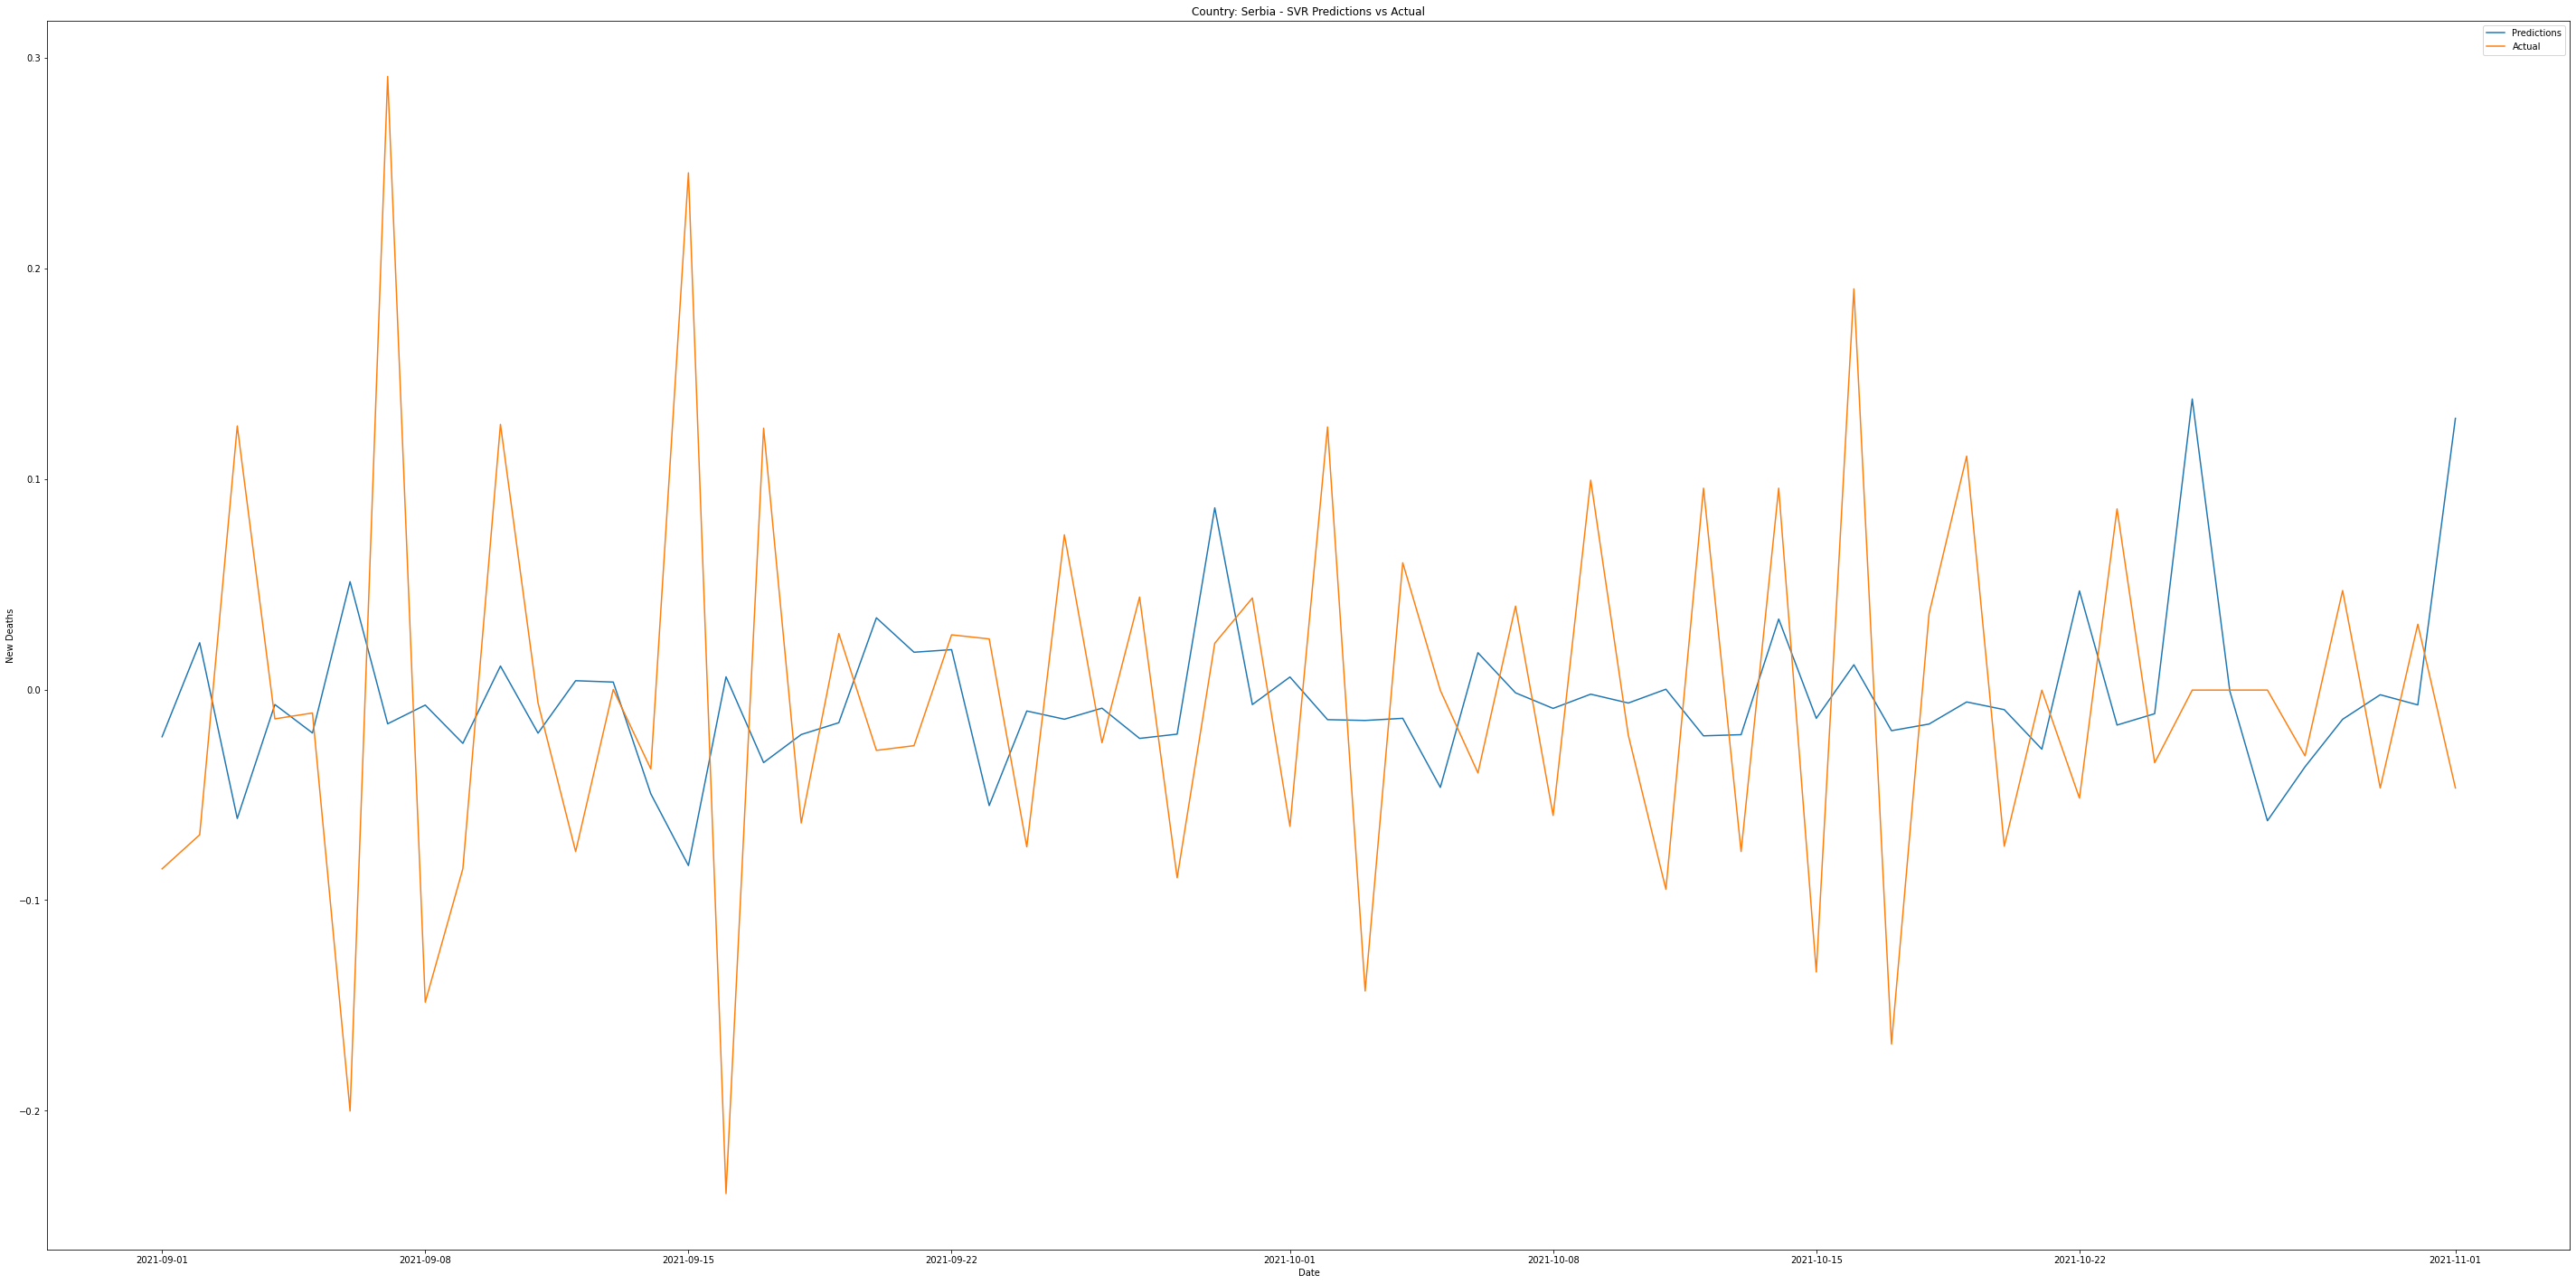

Country: Slovenia - C: 1 - SVR Score: -0.028774815663942466


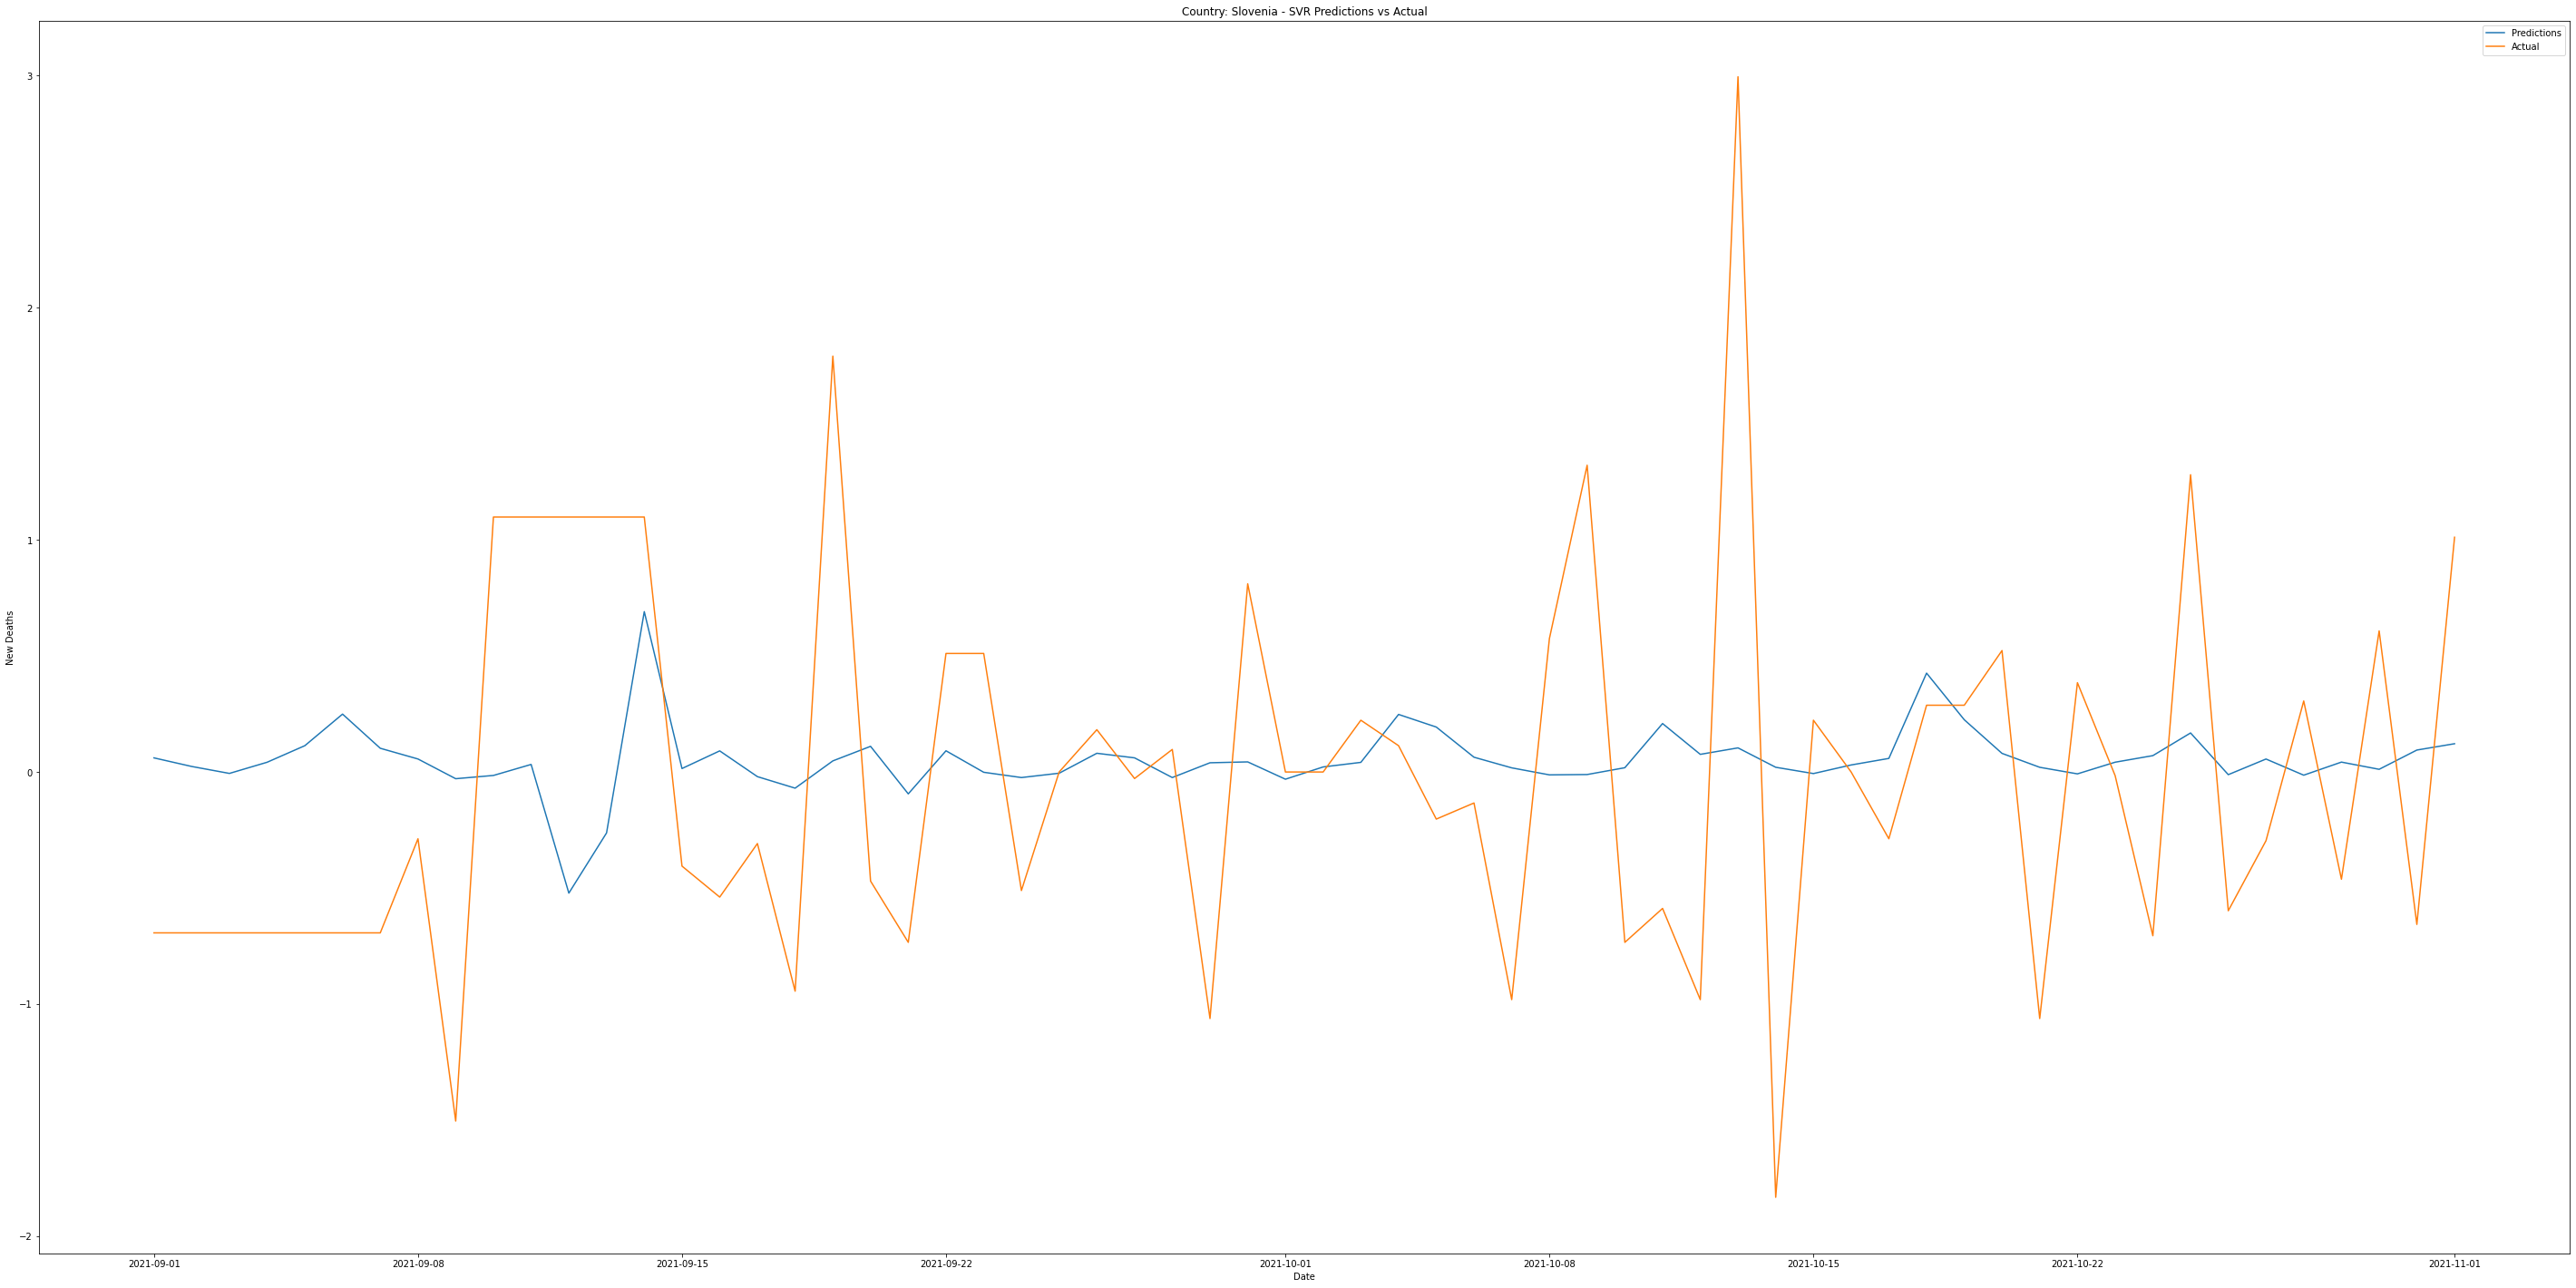

Country: Spain - C: 7.59999999999999 - SVR Score: -0.10102987852580725


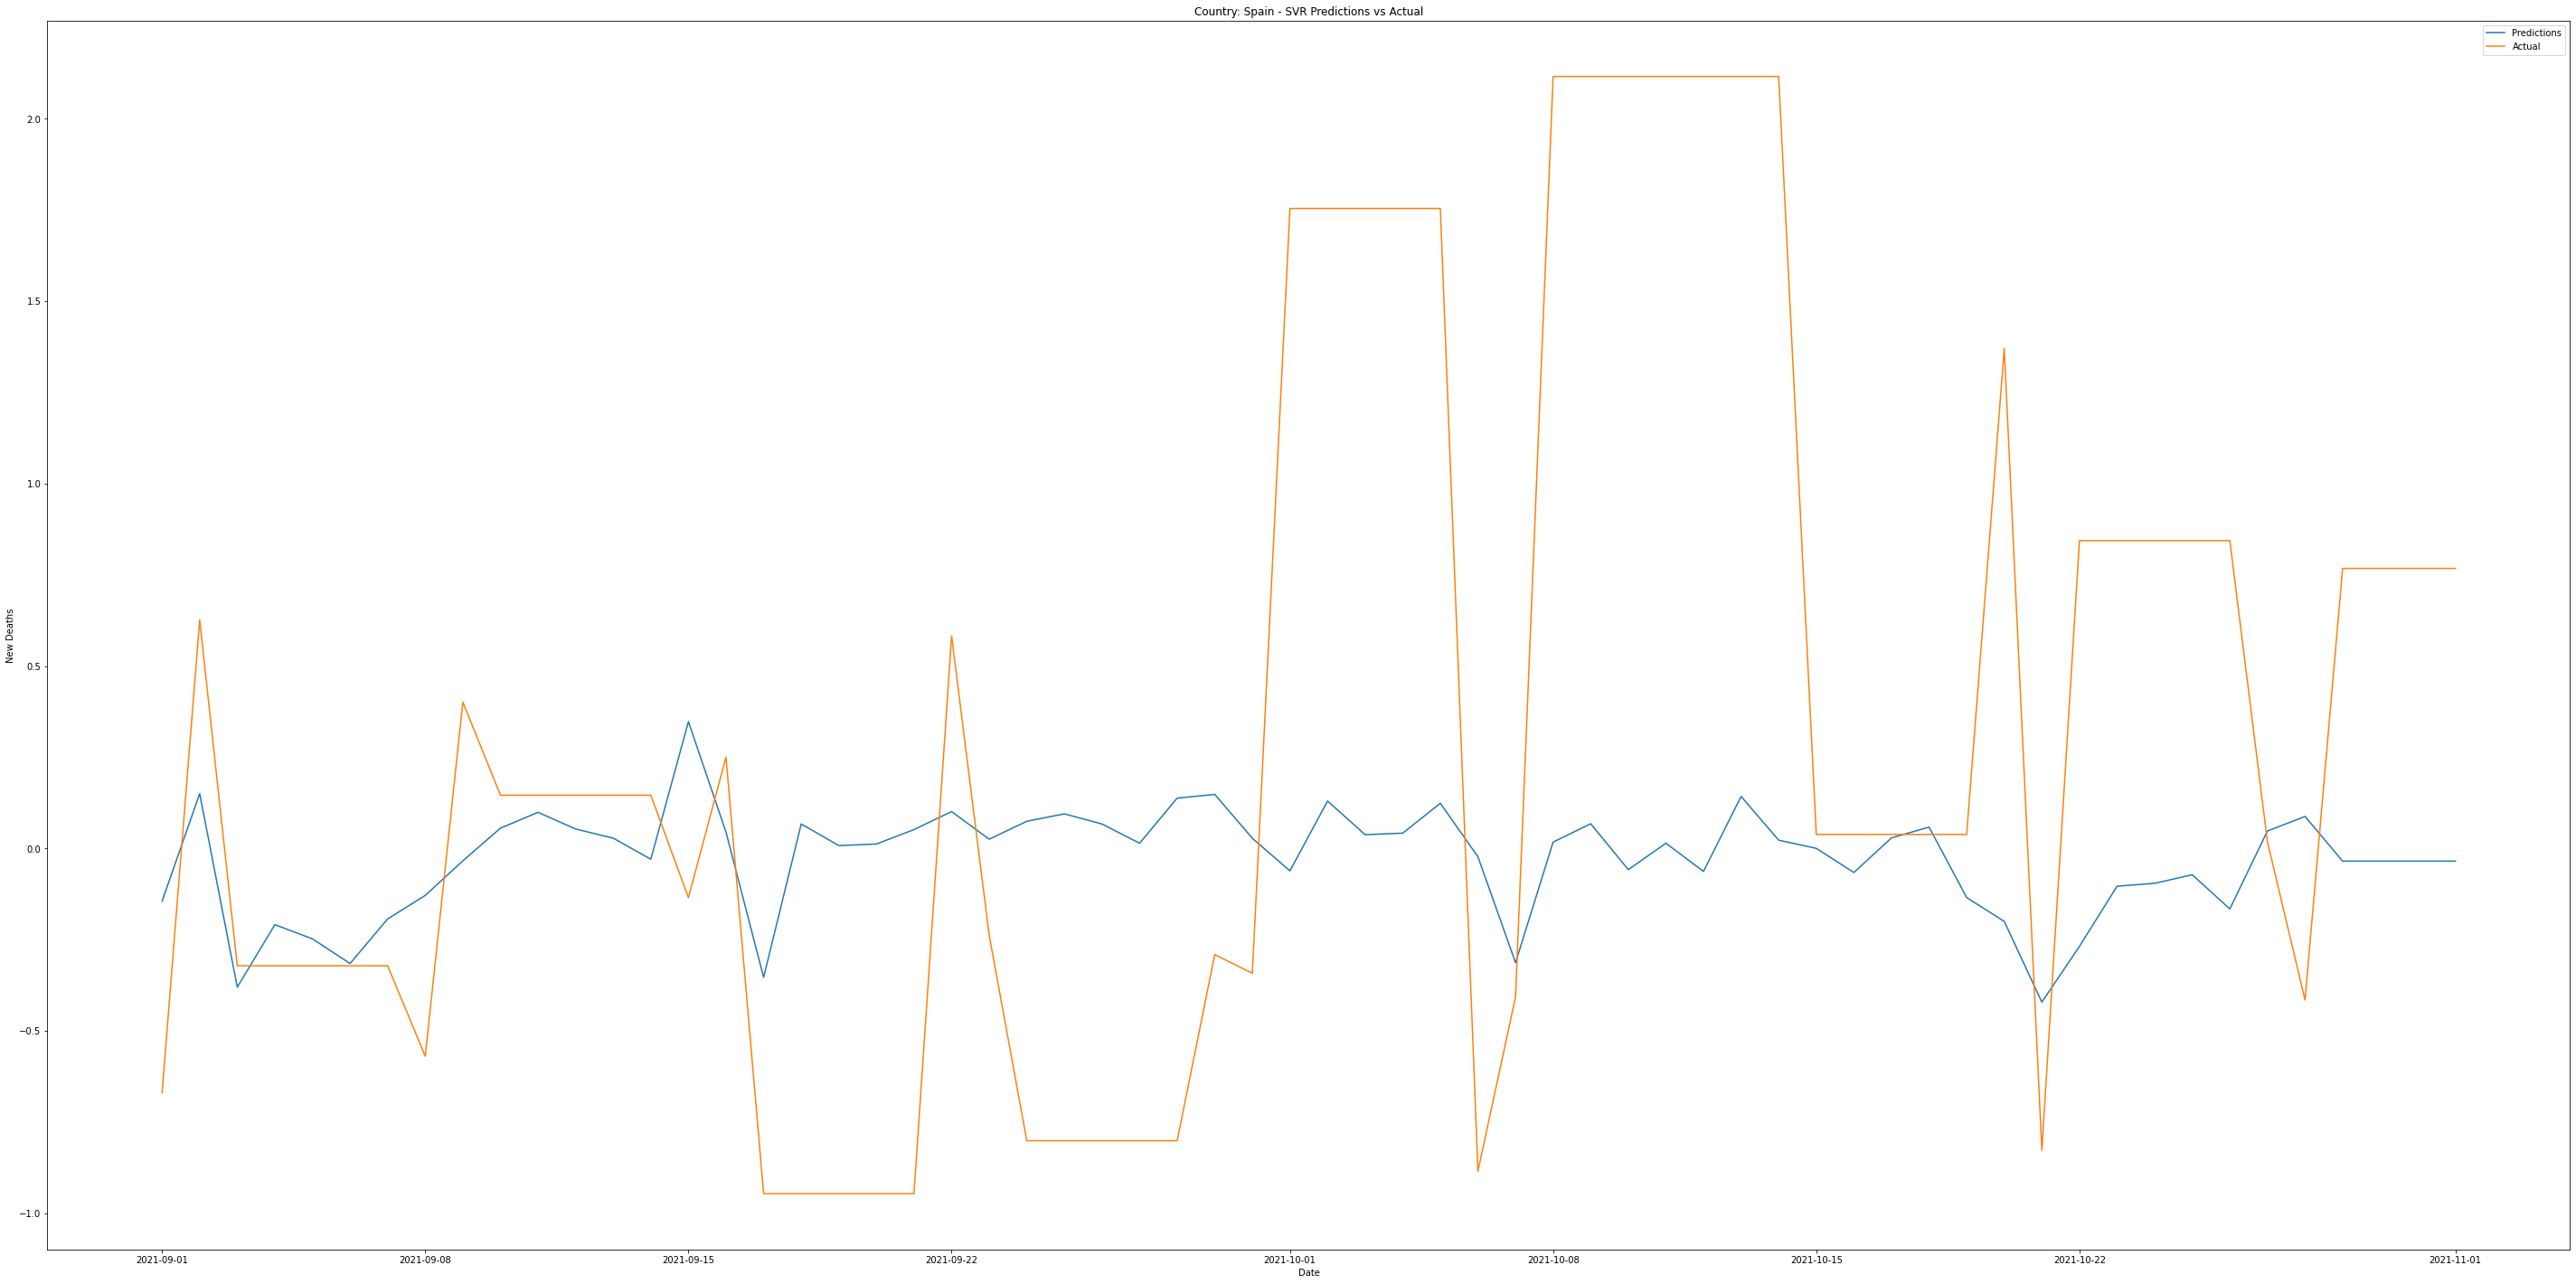

Country: Sweden - C: 1.6000000000000005 - SVR Score: -0.12063679744234701


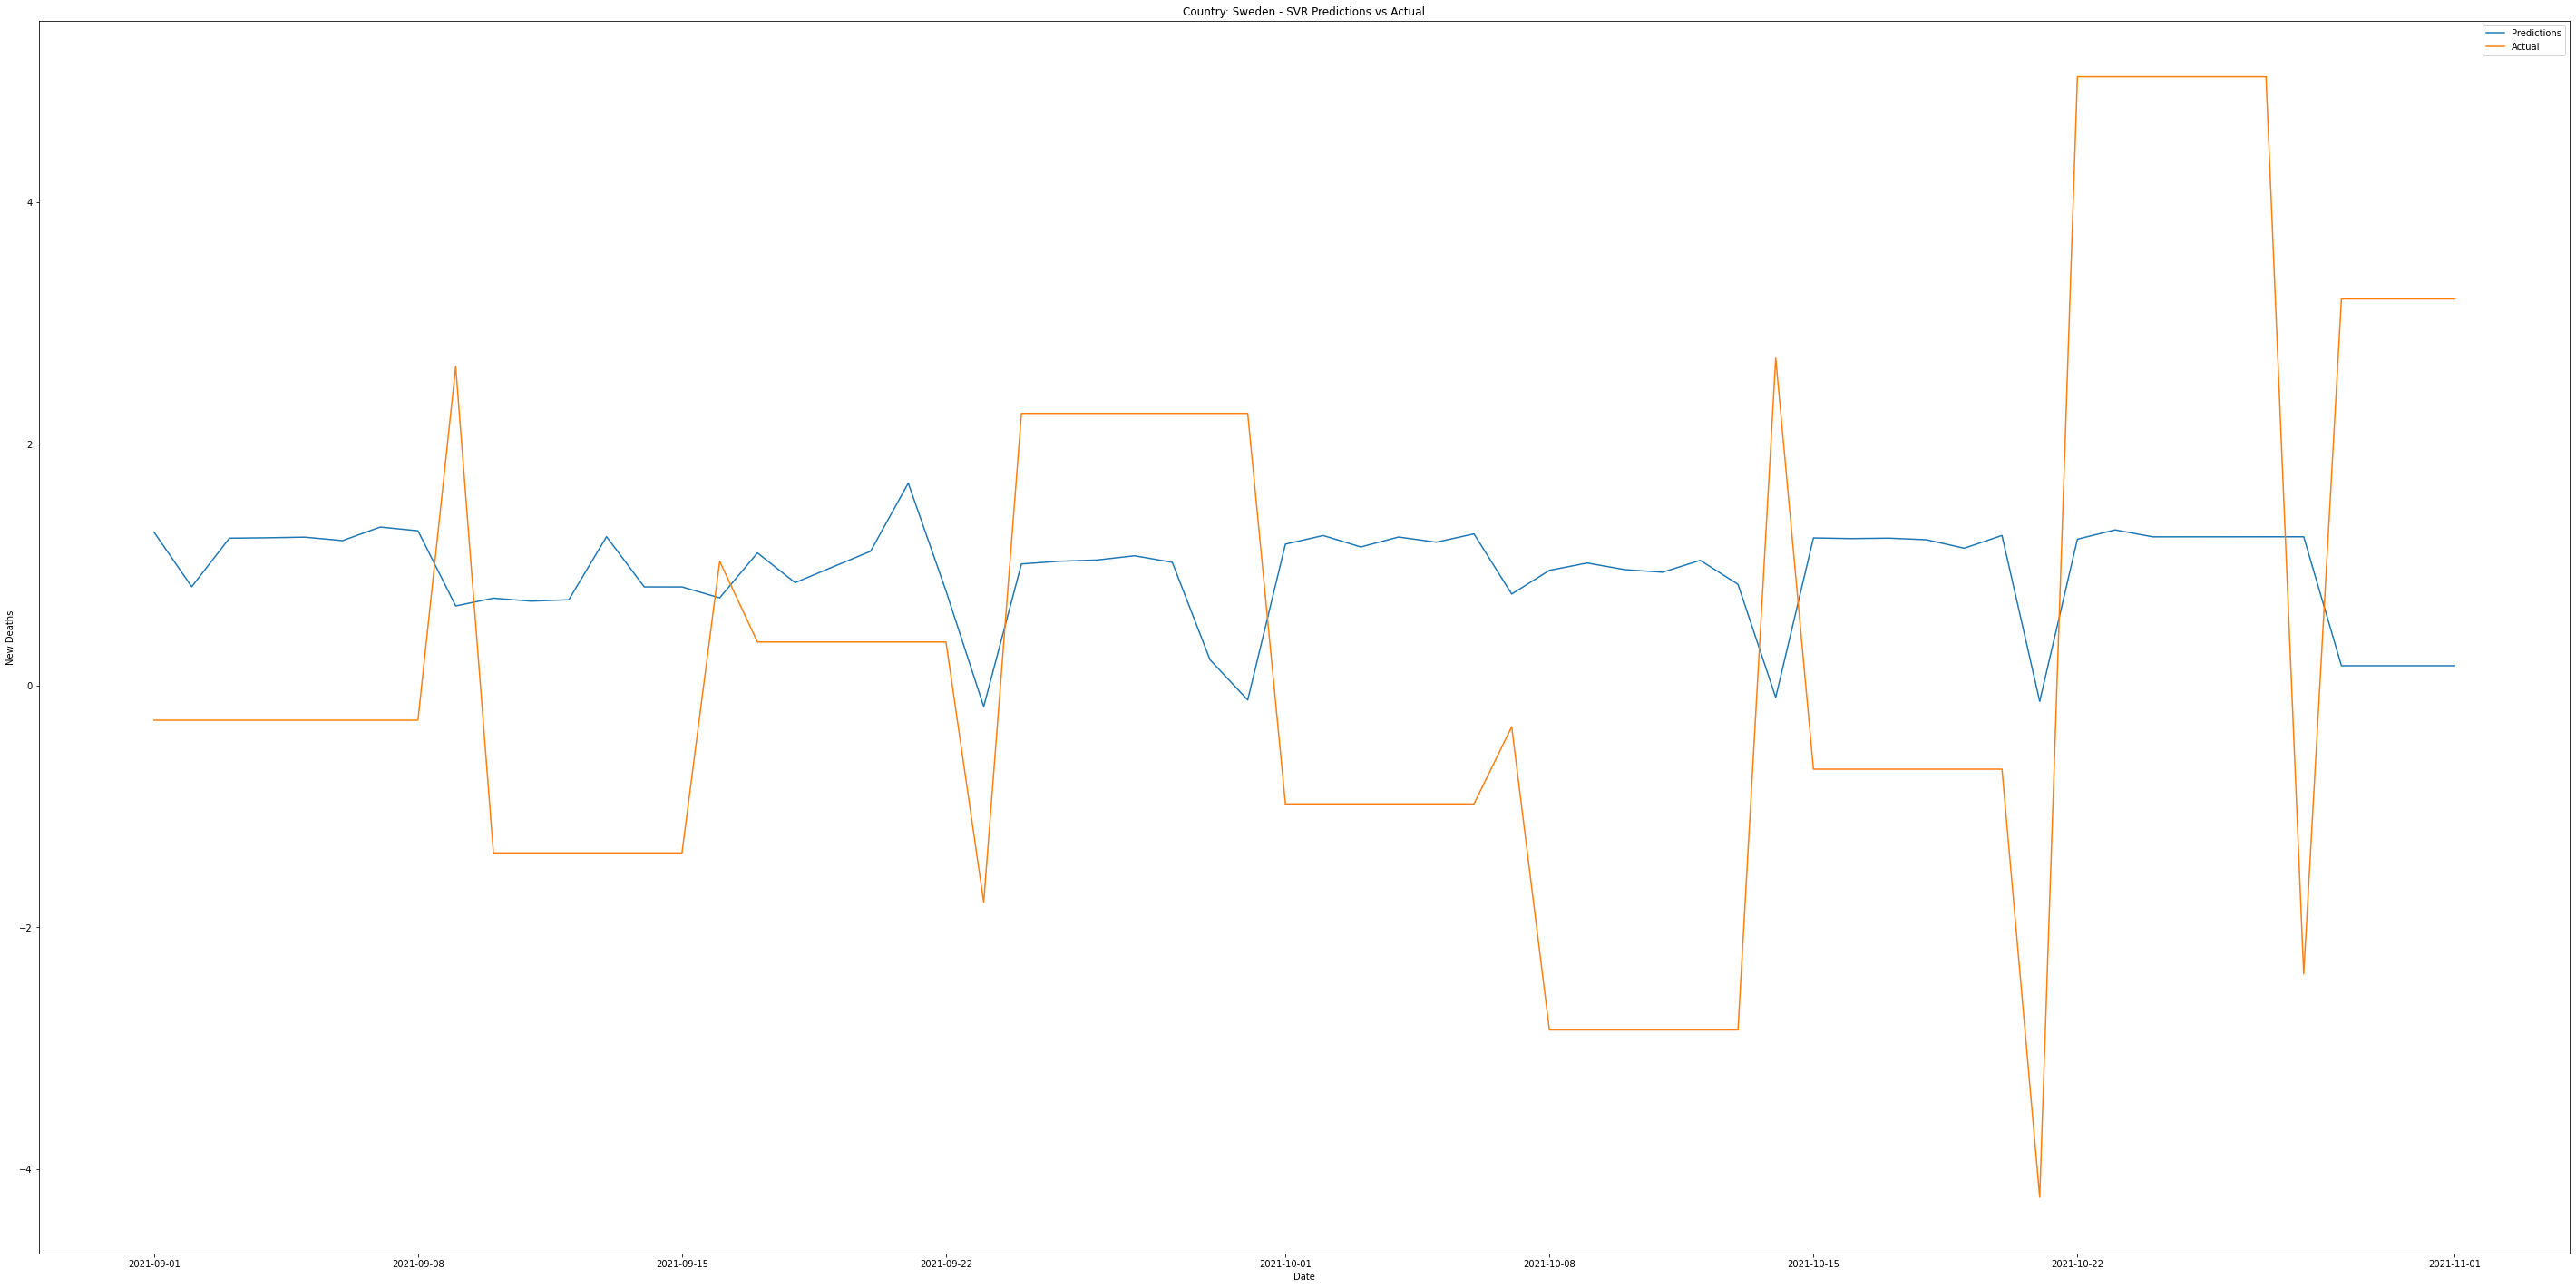

Country: Switzerland - C: 9.999999999999982 - SVR Score: 0.011362897705299746


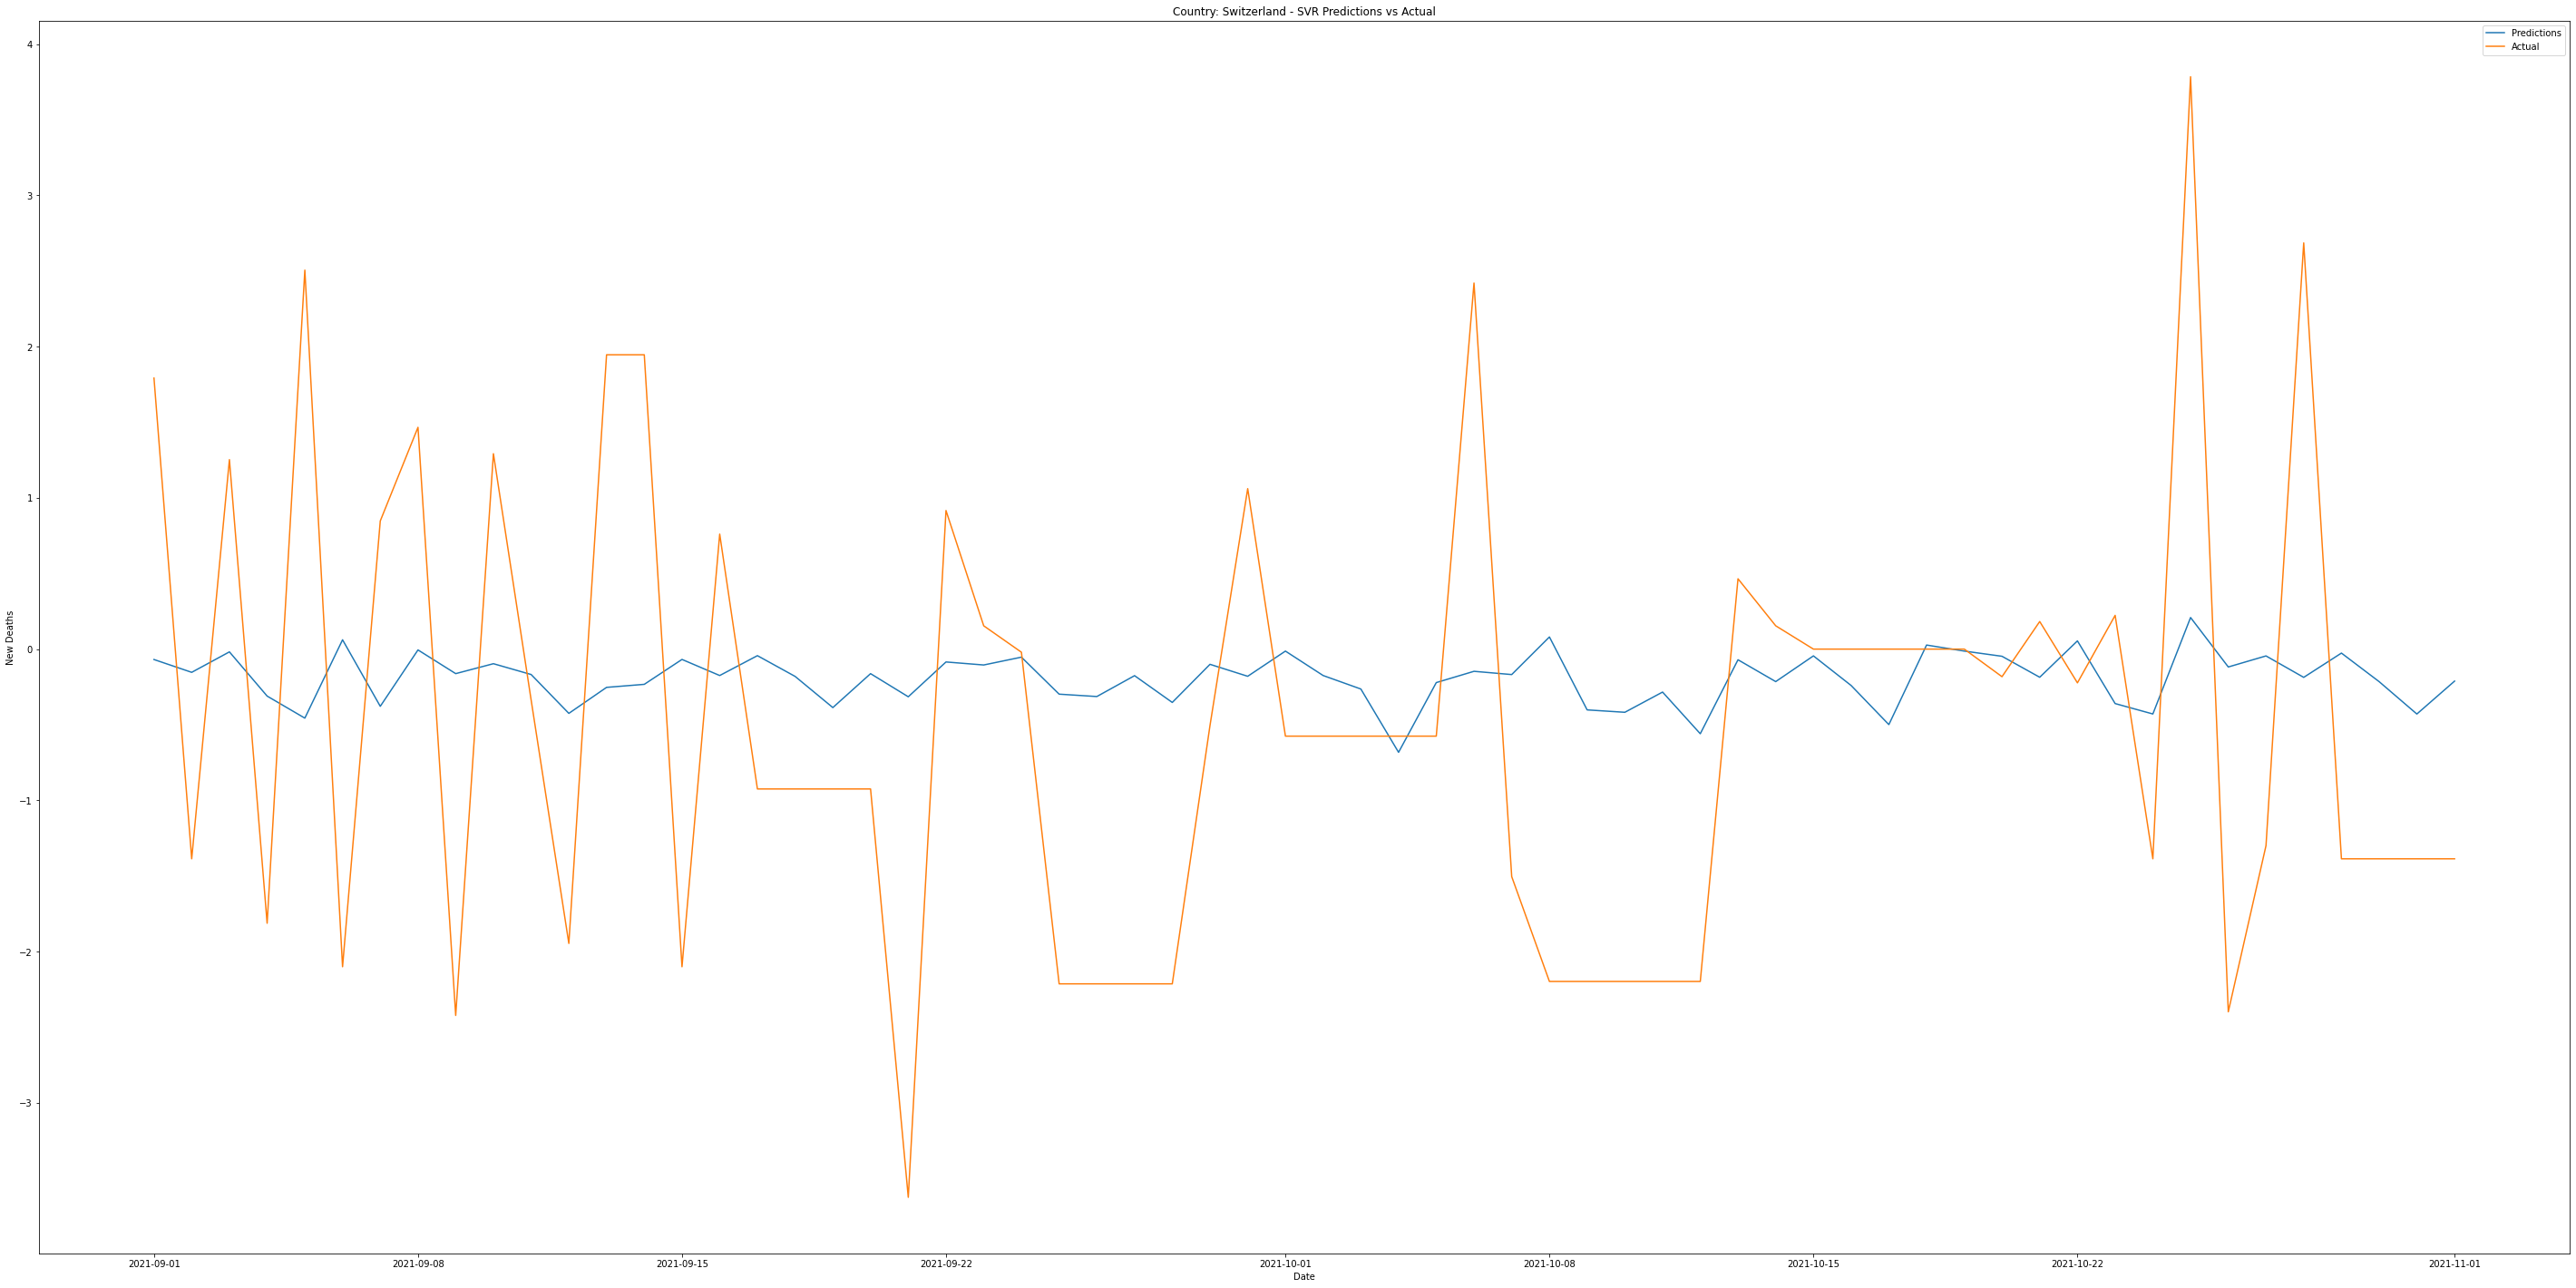

Country: United Kingdom - C: 1 - SVR Score: -0.05569486420862502


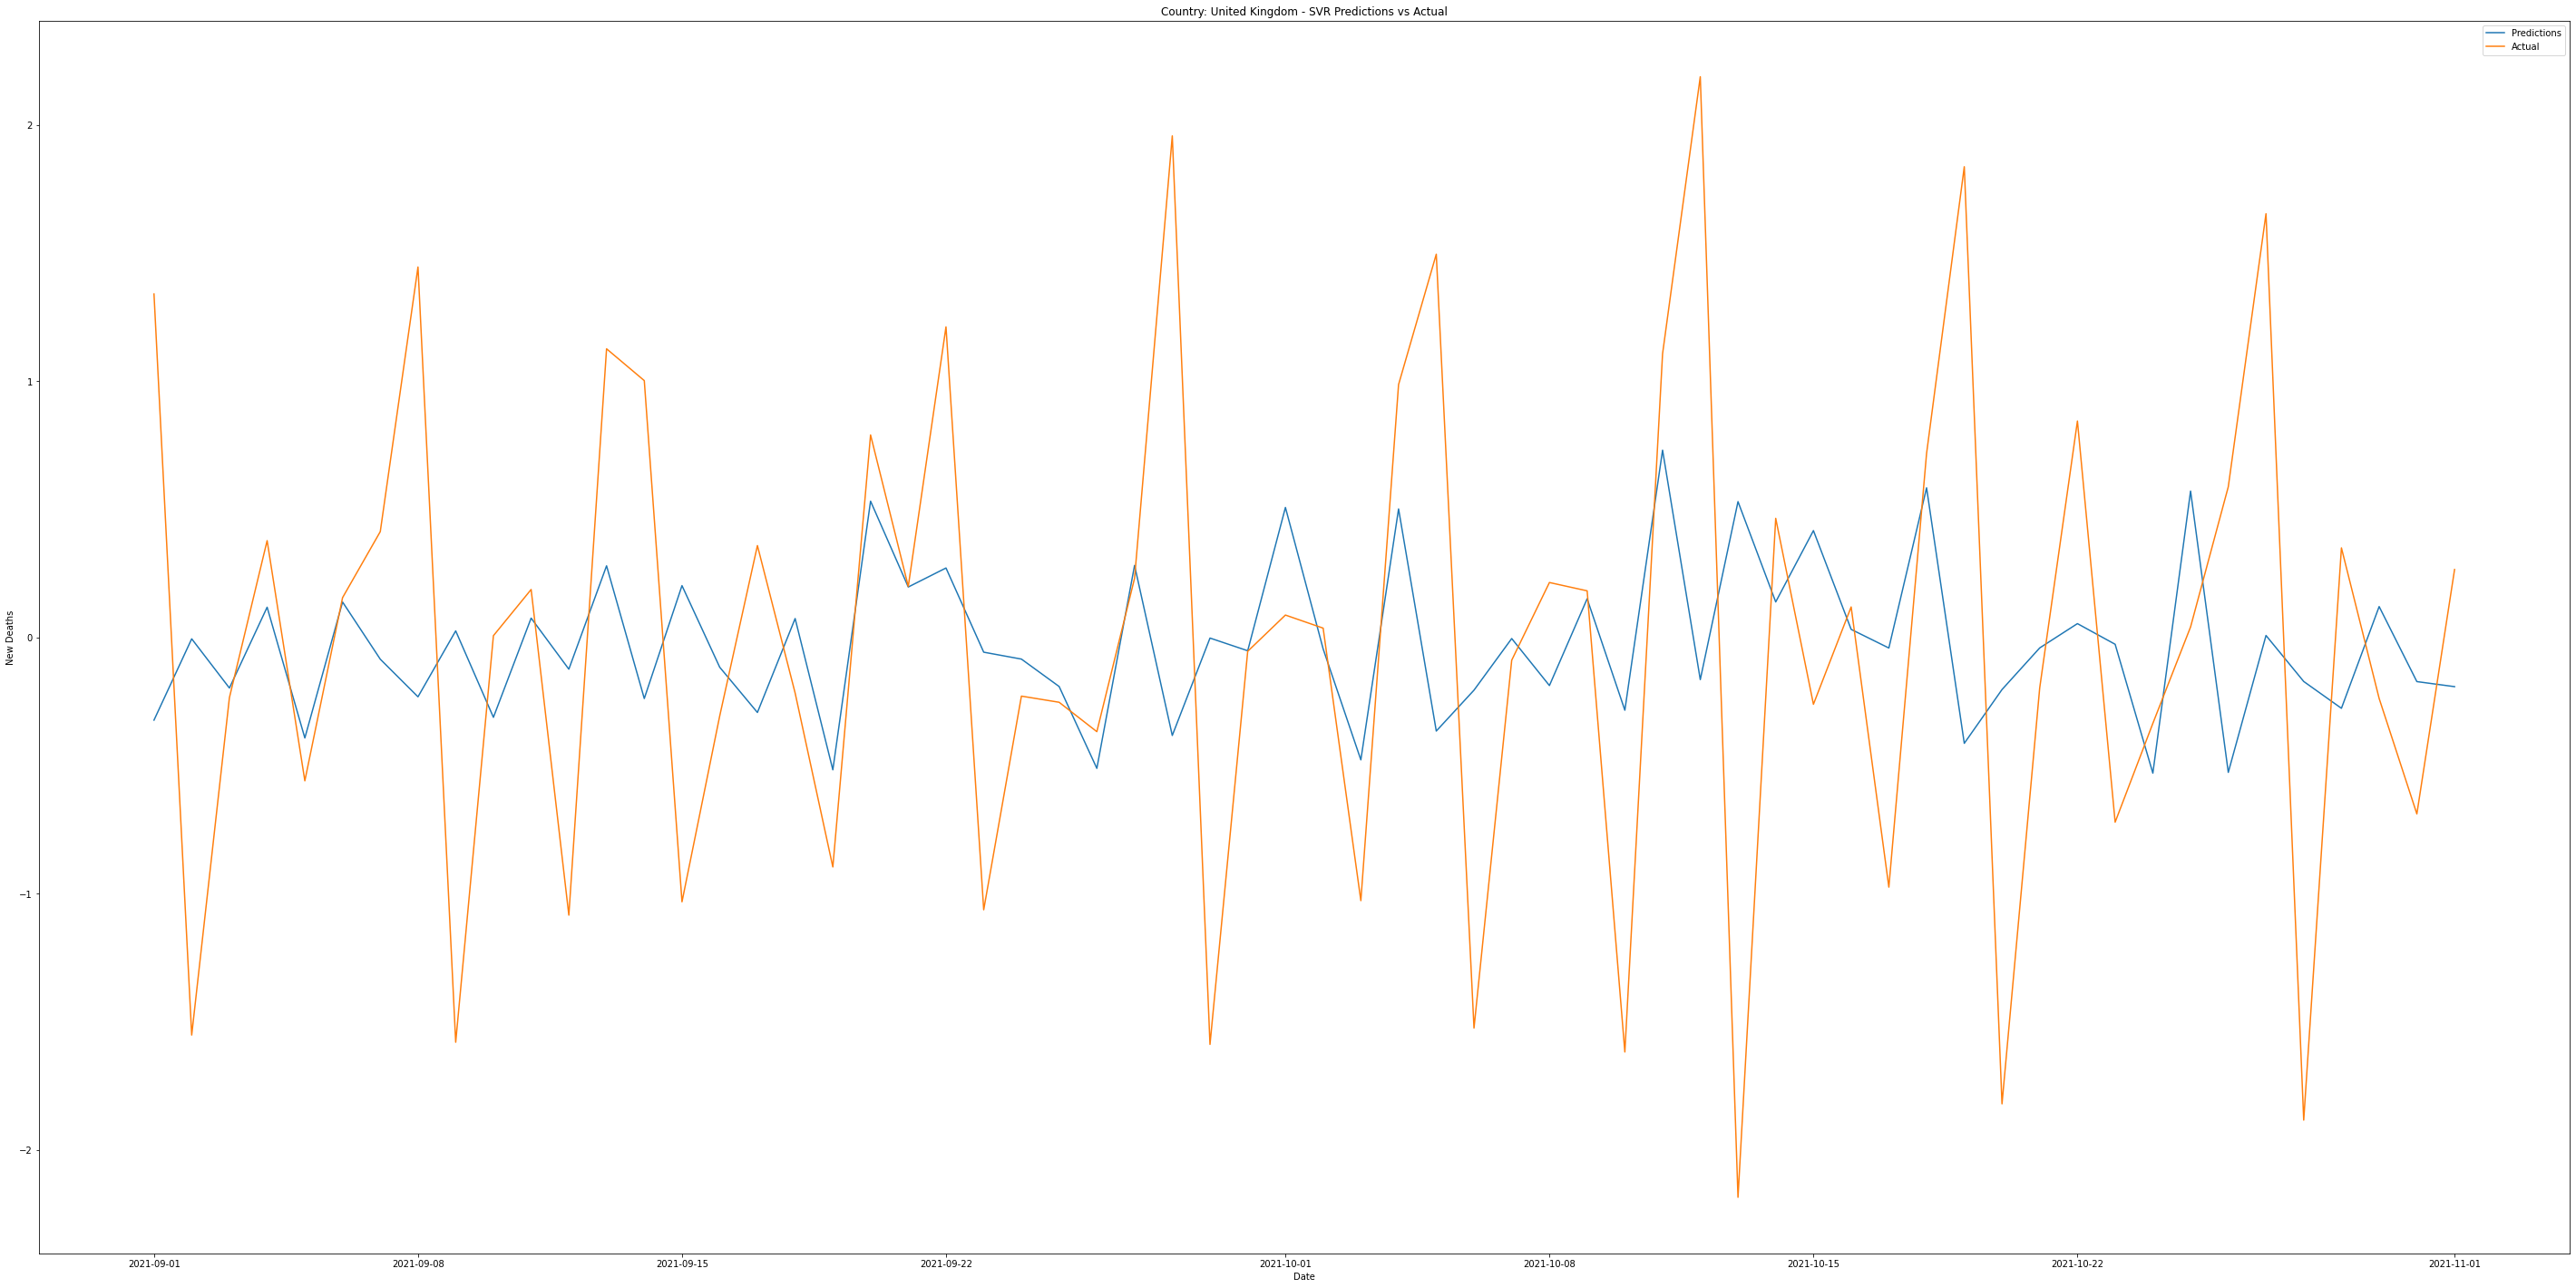

Country: United States - C: 1 - SVR Score: 0.4808185651143344


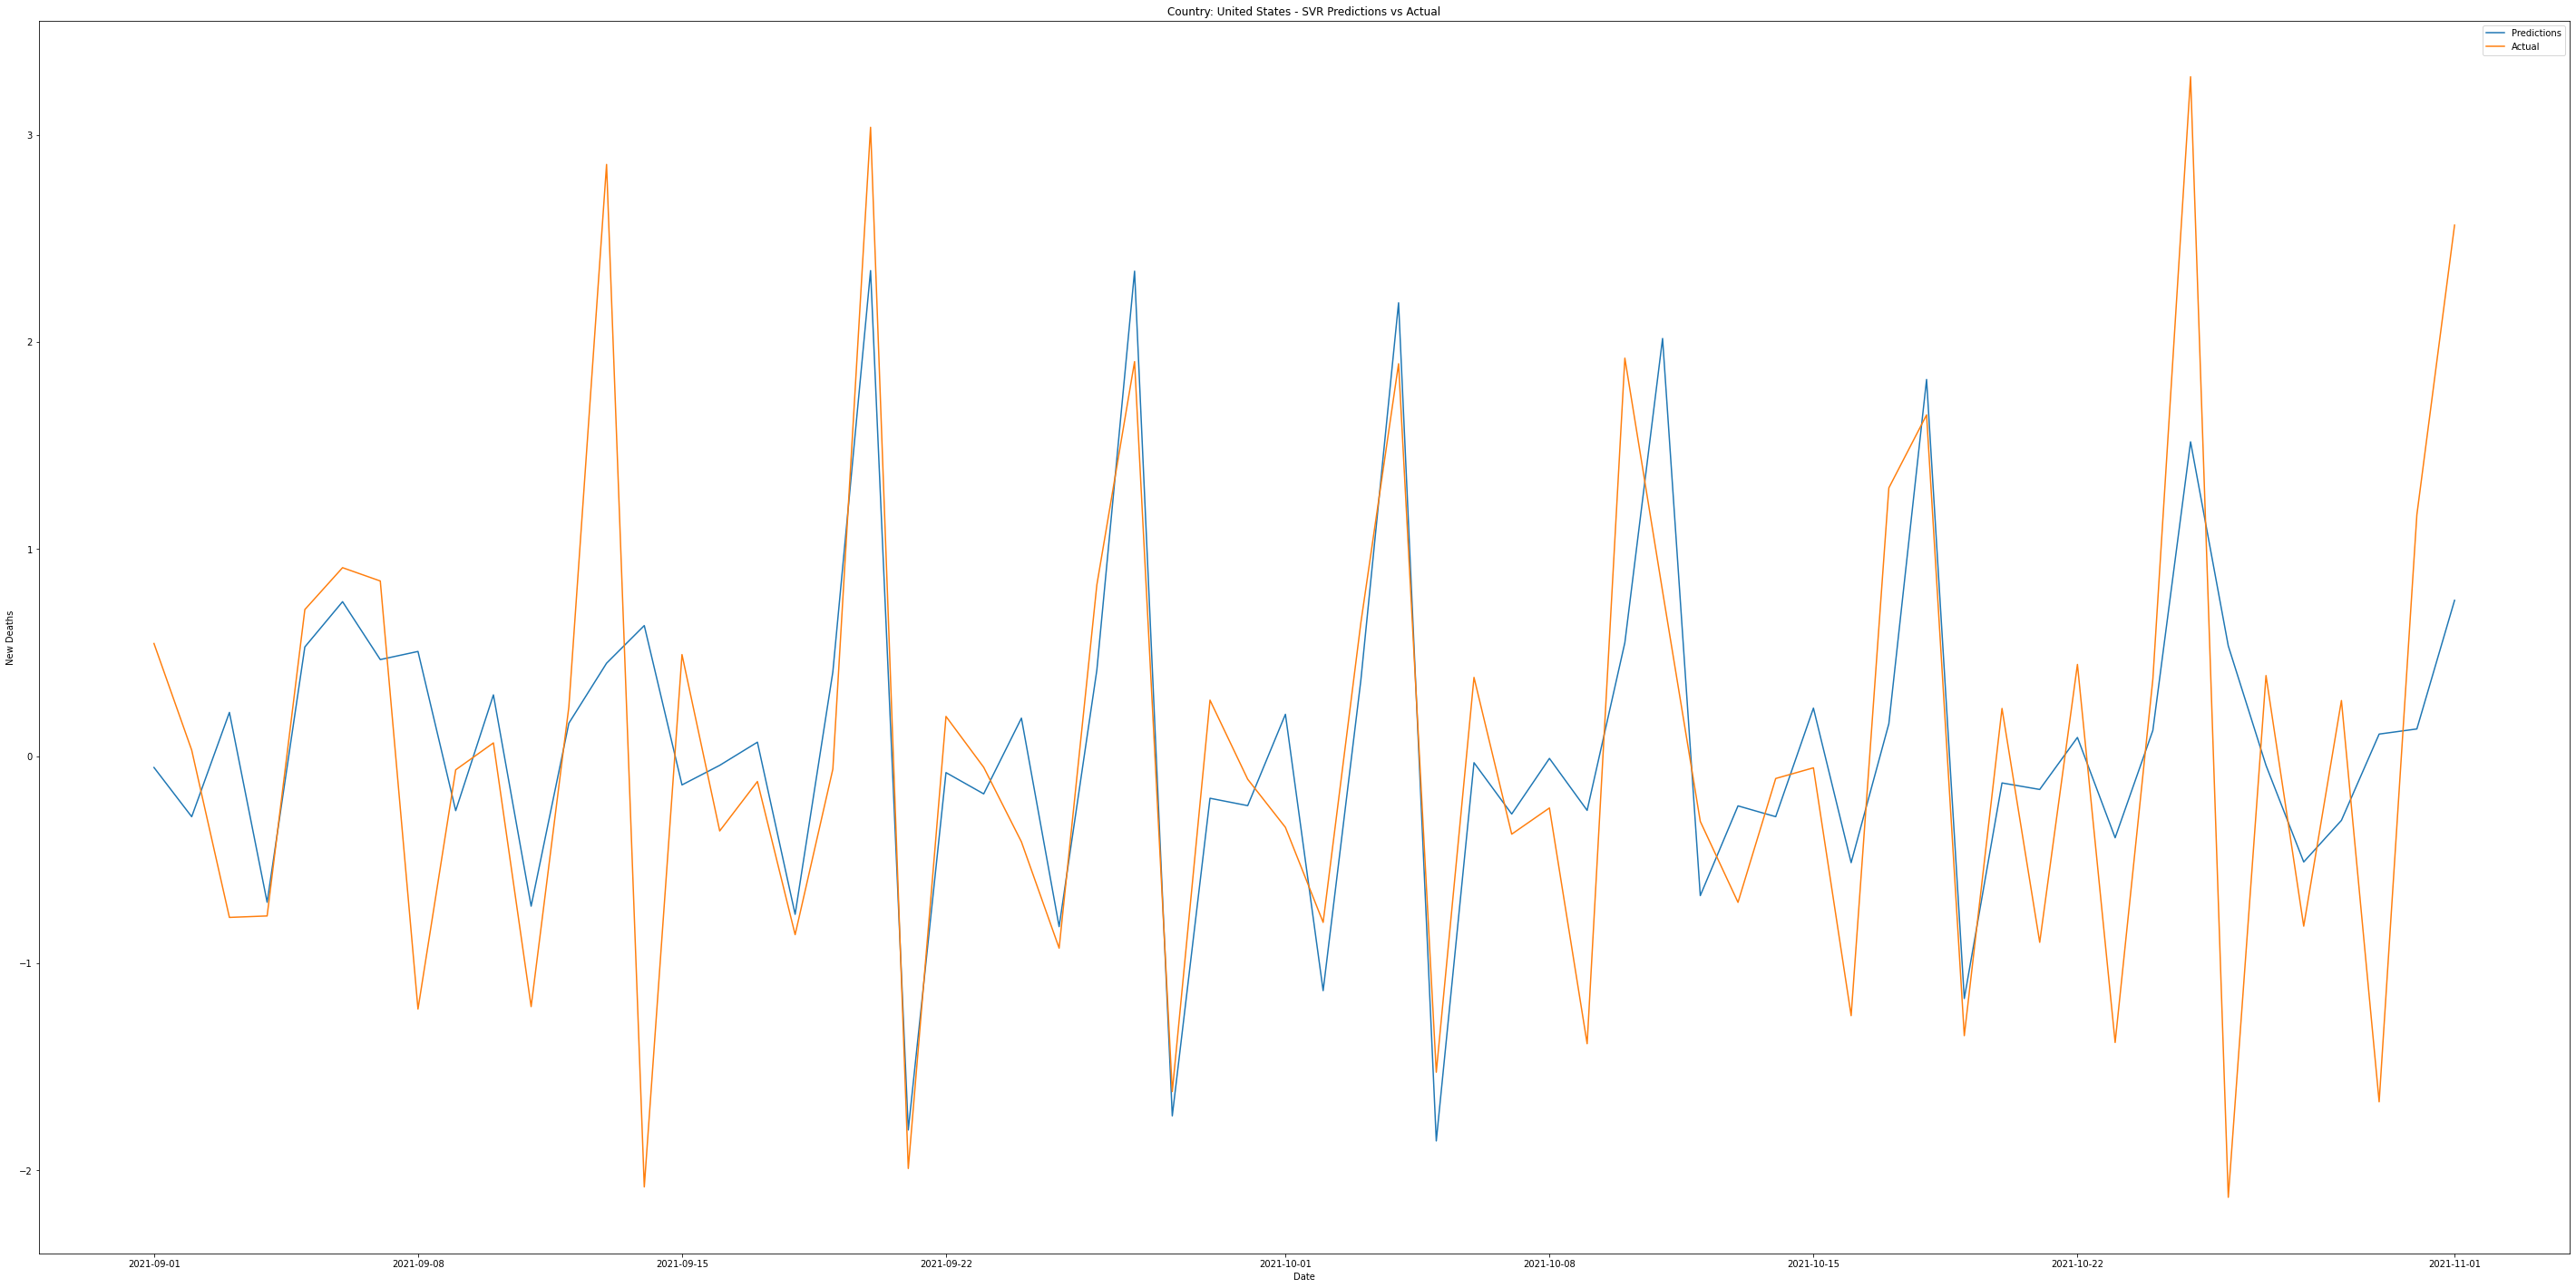

In [45]:
# for each country
for country in svr_dataset['location'].unique():
    svr_predictions = svr(country)